# Starting Polars

## 읽기 & 쓰기
Polars는 일반적인 파일 형식(예: csv, json, parquet), 클라우드 스토리지(S3, Azure Blob, BigQuery) 및 데이터베이스(예: postgres, mysql)에 대한 읽기 및 쓰기를 지원합니다. 아래에서 작은 데이터프레임을 만들고 디스크에 쓰고 다시 읽는 방법을 보여줍니다.

In [ ]:
import polars as pl
import datetime as dt

df = pl.DataFrame({
        "name": ["Alice Archer", "Ben Brown", "Chloe Cooper", "Daniel Donovan"],
        "birthdate": [
            dt.date(1997, 1, 10),
            dt.date(1985, 2, 15),
            dt.date(1983, 3, 22),
            dt.date(1981, 4, 30),
        ],
        "weight": [57.9, 72.5, 53.6, 83.1],  # (kg)
        "height": [1.56, 1.77, 1.65, 1.75],  # (m)
})

In [ ]:
print(df)

1. 데이터프레임을 .csv 파일로 내보내기 `output.csv`

2. 그 후, `read_csv`를 사용하여 다시 읽은 다음, 결과를 print

In [ ]:
df.write_csv("/Users/ijian/Documents/Polars/output.csv")
df_csv = pl.read_csv("output.csv", try_parse_dates=True)
print(df_csv)

## 표현과 맥락

표현식은 Polars의 주요 장점 중 하나로, 데이터 변환을 표현하는 모듈식이고 유연한 방식을 제공합니다.

다음은 Polars 표현식의 예입니다.

In [ ]:
pl.col('weight') / pl.col('height') ** 2

추측할 수 있겠지만, 이 표현식은 "체중"이라는 열을 가져와서 그 값을 "키" 열의 값의 제곱으로 나누어 사람의 BMI를 계산합니다. 위의 코드는 추상적인 계산을 표현한다는 점에 유의하세요. 표현식이 결과를 가진 시리즈로 구체화되는 것은 Polars 컨텍스트 내에서만 가능합니다.

아래에서는 다양한 맥락 내에서 극점 표현의 예를 보여드리겠습니다.

`select`

`with_columns`

`filter`

`group_by`

### `select`
컨텍스트를 select사용하면 데이터 프레임에서 열을 선택하고 조작할 수 있습니다. 

가장 간단한 경우, 제공하는 각 표현식은 결과 데이터 프레임의 열에 매핑됩니다.

In [ ]:
result = df.select(
    pl.col('name'),
    pl.col('birthdate').dt.year().alias('birth_year'),
    (pl.col('weight') / pl.col('height') **2).alias('bmi')
)

print(result)

Polars는 또한 하나의 표현식이 여러 표현식의 단축형으로 작용하는 "표현식 확장"이라는 기능을 지원합니다.

 아래 예에서 표현식 확장을 사용하여 단일 표현식으로 "weight" 및 "height" 열을 조작합니다.
 
  표현식 확장을 사용할 때 를 사용하여 .name.suffix원래 열의 이름에 접미사를 추가할 수 있습니다.

📌 `.name.suffix(" ")`는 언제 사용할까?

✅ 컬럼명을 동적으로 변경할 때

✅ 여러 개의 컬럼에 일괄적으로 접미사를 추가할 때

✅ Pandas의 df.add_suffix("_new")와 비슷한 역할

In [ ]:
result = df.select(
    pl.col('name'), 
    (pl.col('weight', 'height') * 0.95).round(2).name.suffix('-5%'),
)

print(result)

### `with_columns`
`select` 컨텍스트와 매우 유사하지만 열을 선택하는 대신 데이터프레임에 열을 추가합니다. 

결과 데이터프레임에 원래 데이터프레임의 4개 열과 다음 표현식에서 도입된 2개의 새 열이 포함되어 있는지 확인하세요 

group_by도 명명된 표현식을 허용합니다.

In [ ]:
result = df.with_columns(
    birth_year = pl.col('birthdate').dt.year(),
    bmi = (pl.col('weight') / pl.col('height') ** 2).round(2)
)

print(result)

In [ ]:
result.select(pl.all())

In [ ]:
print(df)

### `filter`
컨텍스트를 filter사용하면 원본 데이터 프레임의 행 하위 집합을 사용하여 두 번째 데이터 프레임을 만들 수 있습니다.

In [ ]:
result = df.filter(pl.col('birthdate').dt.year() > 1990)

In [ ]:
print(result)

In [ ]:
result.select(pl.all())

### `group by`
아래 예는 각 10년 동안 태어난 사람의 수를 계산합니다.


In [ ]:
result = df.group_by(
    (pl.col('birthdate').dt.year() // 10 * 10).alias('decade'),
    maintain_order=True   # maintain_order 옵션은 그룹화된 결과를 그룹화된 순서대로 반환, 기본값은 False
).len() # 그룹화된 결과의 행 수를 반환

print(result)

컨텍스트를 사용한 후 결과 그룹에 대한 집계를 계산하는 데 group_by 사용할 수 있습니다 (.agg)

In [ ]:
result  = df.group_by(
    (pl.col('birthdate').dt.year() // 10 * 10).alias('decade')
).agg(
    pl.len().alias('sample_size'),
    pl.mean('weight').round(2).alias('mean_weight'),
    pl.max('height').alias('tallest')
)

In [ ]:
print(result)

더 복잡한 쿼리

컨텍스트와 그 안의 표현식은 필요에 따라 더 복잡한 쿼리를 만들기 위해 체인으로 연결할 수 있습니다. 

아래 예에서 우리는 지금까지 본 컨텍스트 중 일부를 결합하여 더 복잡한 쿼리를 만듭니다.

In [ ]:
df.select(pl.all())

In [ ]:
result = (
    df.with_columns(
        (pl.col('birthdate').dt.year() // 10 * 10).alias('decade'),
        pl.col('name').str.split(by=' ').list.first().alias('first_name'),  
    )  # with_columns 메서드를 사용하여 새로운 열을 추가
    .select(
        pl.all().exclude('birthdate')  # birthdate 열을 제외한 모든 열을 선택
    )
    .group_by(
        pl.col('decade'),
        maintain_order=True ,
    )   # decade 열로 그룹화
    .agg(
        pl.col('name'),
        pl.col('weight', 'height').mean().round(2).name.suffix('_avg'),
    )
)
print(result)

## 데이터 프레임 결합
Polars는 두 개의 데이터프레임을 결합하는 여러 도구를 제공합니다. 이 섹션에서는 조인의 예와 연결의 예를 보여줍니다.

### 데이터 프레임 Join

Polars는 다양한 조인 알고리즘을 제공합니다. 

아래 예는 열을 고유 식별자로 사용하여 데이터 프레임 간의 행 간 대응 관계를 설정할 수 있는 경우 두 데이터 프레임을 결합하기 위해 왼쪽 외부 조인을 사용하는 방법을 보여줍니다.

In [ ]:
df2 = pl.DataFrame({
        "name": ["Ben Brown", "Daniel Donovan", "Alice Archer", "Chloe Cooper"],
        "parent": [True, False, False, False],
        "siblings": [1, 2, 3, 4],
})

print(df.join(df2, on='name', how = 'left'))

### 데이터 프레임 Concatenating 
데이터 프레임을 연결하면 사용된 방법에 따라 더 높거나 더 넓은 데이터 프레임이 생성됩니다. 

다른 사람의 데이터가 있는 두 번째 데이터 프레임이 있다고 가정하면 수직 연결을 사용하여 더 높은 데이터 프레임을 만들 수 있습니다.

In [ ]:
df3 = pl.DataFrame(
    {
        "name": ["Ethan Edwards", "Fiona Foster", "Grace Gibson", "Henry Harris"],
        "birthdate": [
            dt.date(1977, 5, 10),
            dt.date(1975, 6, 23),
            dt.date(1973, 7, 22),
            dt.date(1971, 8, 3),
        ],
        "weight": [67.9, 72.5, 57.6, 93.1],  # (kg)
        "height": [1.76, 1.6, 1.66, 1.8],  # (m)
    }
)

print(pl.concat([df, df3], how = 'vertical'))

---

# 개념(Concept)

## 데이터 유형 및 구조

### 데이터 유형
Polars는 다음 범주에 속하는 다양한 데이터 유형을 지원합니다.

- 숫자형 데이터 유형: 부호 있는 정수, 부호 없는 정수, 부동 소수점 숫자 및 소수점.
- 중첩된 데이터 유형: 목록, 구조체, 배열.
- 시간적: 날짜, 날짜시간, 시간, 시간 델타.
- 기타: 문자열, 이진 데이터, 부울, 범주형, 열거형 및 객체.

모든 유형은 특수 값으로 표현되는 누락된 값을 지원합니다 . 이것은 부동 소수점 데이터 유형의 null특수 값과 혼동되어서는 안 됩니다 .

### Series
Polars에서 제공하는 핵심 기본 데이터 구조는 시리즈와 데이터프레임입니다. 

시리즈는 1차원 동질 데이터 구조입니다. "동질"이란 시리즈 내의 모든 요소가 동일한 데이터 유형을 갖는다는 것을 의미합니다. 

아래 스니펫은 명명된 시리즈를 만드는 방법을 보여줍니다.

In [ ]:
import polars as pl

s = pl.Series('ints', [1, 2, 3, 4, 5])
print(s)

- 시리즈를 만들 때 Polars는 제공한 값에서 데이터 유형을 추론합니다. 
- 추론 메커니즘을 재정의하기 위해 구체적인 데이터 유형을 지정할 수 있습니다.

In [ ]:
s1 = pl.Series('ints', [1, 2, 3, 4, 5]) 
s2 = pl.Series('units', [1,2,3,4,5], dtype = pl.UInt64)
print(s1.dtype, s2.dtype)

### DataFrame
- 데이터 프레임은 고유하게 명명된 시리즈를 포함하는 2차원  heterogeneous 데이터 구조입니다. 

- 데이터 프레임에 데이터를 보관하면 Polars API를 사용하여 데이터를 조작하는 쿼리를 작성할 수 있습니다. 
- 다음에 설명할 Polars에서 제공하는 컨텍스트와 표현식을 사용하여 이를 수행할 수 있습니다.

- 아래 스니펫은 목록 사전에서 데이터 프레임을 만드는 방법을 보여줍니다.

In [ ]:
from datetime import date

df = pl.DataFrame(
    {
        "name": ["Alice Archer", "Ben Brown", "Chloe Cooper", "Daniel Donovan"],
        "birthdate": [
            date(1997, 1, 10),
            date(1985, 2, 15),
            date(1983, 3, 22),
            date(1981, 4, 30),
        ],
        "weight": [57.9, 72.5, 53.6, 83.1],  # (kg)
        "height": [1.56, 1.77, 1.65, 1.75],  # (m)
    }
)

print(df)

#### 데이터 프레임 검사
이 하위 섹션에서는 데이터프레임을 빠르게 검사하는 데 유용한 몇 가지 방법을 보여드리겠습니다. 우리는 앞서 만든 데이터프레임을 시작점으로 사용할 것입니다.

#### `head`
이 함수는 데이터 프레임의 첫 번째 행을 보여줍니다. 기본적으로 첫 번째 5개 행을 얻지만 원하는 행 수를 지정할 수도 있습니다.

In [ ]:
print(df.head(3))

#### `Glimpse`
이 함수 glimpse는 데이터 프레임의 처음 몇 행의 값을 보여주는 또 다른 함수이지만,
head와 출력을 다르게 포맷합니다. 

여기서 출력의 각 줄은 단일 열에 해당하므로 더 넓은 데이터 프레임을 검사하기가 더 쉽습니다.

In [ ]:
print(df.glimpse(return_as_string=True))

#### `tail`

이 함수는 tail데이터 프레임의 마지막 행을 보여줍니다. 

기본적으로 마지막 5개 행을 얻지만 원하는 행 수를 지정할 수도 있습니다.

 head작동 방식과 유사합니다.

In [ ]:
print(df.tail(3))

#### `sample`
데이터프레임의 첫 번째 또는 마지막 행이 데이터를 대표하지 않는다고 생각되면 `sample`을 사용하여 데이터프레임에서 임의로 선택된 행의 임의의 개수를 가져올 수 있습니다. 

행이 데이터프레임에 나타나는 순서와 반드시 동일한 순서로 반환되는 것은 아니라는 점에 유의하세요.

In [ ]:
import random
random.seed(42)
print(df.sample(2))

#### `describe`
 데이터 프레임의 모든 열에 대한 요약 통계를 계산하는 데 사용할 수 있습니다 .

In [ ]:
print(df.describe())

#### Schema
데이터(데이터프레임 또는 기타)에 대해 이야기할 때 우리는 스키마를 참조할 수 있습니다. 

스키마는 열 또는 시리즈 이름을 동일한 열 또는 시리즈의 데이터 유형에 매핑하는 것입니다.

다음을 사용하여 데이터 프레임의 스키마를 확인할 수 있습니다 

In [ ]:
print(df.schema)

In [ ]:
df = pl.DataFrame({
        "name": ["Alice", "Ben", "Chloe", "Daniel"],
        "age": [27, 39, 41, 43],   
}, schema={'name':None, 'age':pl.UInt32})

print(df)

일부 열의 추론만 재정의해야 하는 경우 매개변수를 사용하면 `schema_overrides`추론을 재정의하지 않으려는 열을 생략할 수 있으므로 더 편리합니다.

In [ ]:
df = pl.DataFrame(
    {
        "name": ["Alice", "Ben", "Chloe", "Daniel"],
        "age": [27, 39, 41, 43],
    },
    schema_overrides={"age": pl.UInt8},
)

print(df)

#### 데이터 유형 내부
Polars는 데이터 방향에 Arrow Columnar Format을 사용합니다 . 

이 사양을 따르면 Polars는 Arrow 사양을 사용하는 다른 도구와 데이터를 거의 또는 전혀 오버헤드 없이 전송할 수 있습니다.

Polars는 대부분의 성능을 쿼리 엔진, 쿼리 계획에 대해 수행하는 최적화, 표현식을 실행할 때 사용하는 병렬화에서 얻습니다 .

#### 부동 소수점 숫자
Float32극좌표는 일반적으로 및 에 대한 IEEE 754 부동 소수점 표준을 따르지만 Float64몇 가지 예외가 있습니다.

- 모든 것은 NaN다른 모든 것과 동등하게 비교되고 NaN, 모든 비- NaN값보다 크다.
- 연산은 0 또는 의 부호에 대한 특정 동작을 보장하지 않으며 NaN, 값의 페이로드에 대해서도 보장하지 않습니다 NaN. 이는 산술 연산에만 국한되지 않습니다. 예를 들어 정렬 또는 그룹화 연산은 효율적인 동등성 검사를 위해 페이로드 없이 모든 0을 +0으로, 모든 NaNs를 양수로 정규화할 수 있습니다 NaN.


Polars는 항상 부동 소수점 계산에 대해 상당히 정확한 결과를 제공하려고 하지만 달리 언급되지 않는 한 오류에 대한 보장은 제공하지 않습니다. 일반적으로 100% 정확한 결과를 얻는 데는 실현 불가능할 정도로 비용이 많이 들며(64비트 부동 소수점보다 훨씬 더 큰 내부 표현이 필요함) 따라서 어느 정도의 오류는 항상 예상할 수 있습니다.

#### 부록: 전체 데이터 유형 표


| **유형(들)**       | **세부** |
|--------------------|------------------------------------------------------------|
| **Boolean**       | 효율적으로 비트 패킹된 부울 유형입니다. |
| **Int8, Int16, Int32, Int64** | 가변 정밀도의 부호 있는 정수 유형입니다. |
| **UInt8, UInt16, UInt32, UInt64** | 가변 정밀도의 부호 없는 정수 유형입니다. |
| **Float32, Float64** | 가변 정밀도의 부호 있는 부동 소수점 숫자. |
| **Decimal**       | 128비트 10진수 유형이며, 선택적인 정밀도와 음수가 아닌 스케일이 있습니다. 부동 소수점의 정밀도와 부동 소수점에서 수행하는 연산을 세부적으로 제어해야 하는 경우 이 유형을 사용합니다. 10진수 데이터 유형이 무엇인지에 대한 설명서는 Python을 참조하세요. |
| **String**        | 가변 길이 UTF-8 인코딩 문자열 데이터, 일반적으로 사람이 읽을 수 있습니다. |
| **Binary**        | 임의의 다양한 길이의 원시 바이너리 데이터를 저장합니다. |
| **Date**          | 달력 날짜를 나타냅니다. |
| **Time**          | 하루 중 시간을 나타냅니다. |
| **Datetime**      | 달력의 날짜와 시간을 나타냅니다. |
| **Duration**      | 시간의 지속을 나타냅니다. |
| **Array**         | 시리즈당 알려진 고정된 모양을 가진 배열. numpy 배열과 유사합니다. 배열과 리스트의 차이점과 둘 다 사용하는 방법에 대해 자세히 알아보세요. |
| **List**         | 가변 길이의 균질 1D 컨테이너. 배열과 목록의 차이점과 두 가지를 모두 사용하는 방법에 대해 자세히 알아보세요. |
| **Object**        | 임의의 Python 객체를 래핑합니다. |
| **Categorical**   | 범주가 런타임에 추론되는 문자열 데이터의 효율적인 인코딩. 범주형과 열거형의 차이점과 두 가지를 모두 사용하는 방법에 대해 자세히 알아보세요. |
| **Enum**         | 미리 정해진 문자열 범주 집합의 효율적인 정렬된 인코딩. 범주형과 열거형의 차이점과 두 가지를 모두 사용하는 방법에 대해 자세히 알아보세요. |
| **Struct**       | 여러 필드를 저장할 수 있는 복합 제품 유형입니다. 전용 설명서 섹션에서 데이터 유형에 대해 자세히 알아보세요. |
| **Null**         | null 값을 나타냅니다. |


## 표현과 맥락
- Expressions and contexts

Polars는 데이터를 변환하기 위한 자체 도메인 특정 언어(DSL)를 개발했습니다. 

이 언어는 사용하기 매우 쉽고 사람이 읽을 수 있는 복잡한 쿼리를 허용합니다.

 여기에서 소개할 표현식과 컨텍스트는 이러한 가독성을 달성하는 데 매우 중요하며 Polars 쿼리 엔진이 쿼리를 최적화하여 가능한 한 빨리 실행할 수 있도록 합니다.

### 표현(Expression)

Polars에서 표현식은 데이터 변환의 lazy representation입니다. 

표현식은 모듈식이고 유연하므로 더 복잡한 표현식을 빌드하기 위한 빌딩 블록으로 사용할 수 있습니다. 

다음은 Polars 표현식의 예입니다.

In [ ]:
import polars as pl

pl.col("weight") / (pl.col("height") ** 2)

추측할 수 있겠지만, 이 표현식은 "체중"이라는 열을 취하고 해당 값을 "키" 열에 있는 값의 제곱으로 나누어 사람의 BMI를 계산합니다.

위의 코드는 변수에 저장하거나 추가로 조작하거나 그냥 인쇄할 수 있는 추상적인 계산을 표현합니다.

In [ ]:
bmi_expr = pl.col('weight') / pl.col('height') ** 2
print(bmi_expr)

표현식이 lazy 하기 때문에 아직 계산이 이루어지지 않았습니다. 그래서 컨텍스트(context)가 필요한 것입니다.

### 맥락(Context)
Polars 표현식은 결과를 생성하기 위해 실행되는 컨텍스트가 필요합니다 .

 사용되는 컨텍스트에 따라 동일한 Polars 표현식이 다른 결과를 생성할 수 있습니다. 
 
 이 섹션에서는 Polars가 제공하는 네 가지 가장 일반적인 컨텍스트에 대해 알아봅니다.

- `select`
- `with_columns`
- `filter`
- `group_by`

아래의 데이터프레임을 사용하여 각 컨텍스트가 어떻게 작동하는지 보여줍니다.

In [ ]:
from datetime import date

# 데이터프레임 생성
df = pl.DataFrame(
    {
        "name": ["Alice Archer", "Ben Brown", "Chloe Cooper", "Daniel Donovan"],
        "birthdate": [
            date(1997, 1, 10),
            date(1985, 2, 15),
            date(1983, 3, 22),
            date(1981, 4, 30),
        ],
        "weight": [57.9, 72.5, 53.6, 83.1],  # (kg)
        "height": [1.56, 1.77, 1.65, 1.75],  # (m)
    }
)

print(df)

#### `select`
선택 컨텍스트는 `select`열에 표현식을 적용합니다. 컨텍스트는 `select`집계, 다른 열의 조합 또는 리터럴인 새 열을 생성할 수 있습니다.

In [ ]:
bmi_expr = pl.col('weight') / pl.col('height') ** 2

In [ ]:
result = df.select(
    bmi = bmi_expr,
    avg_bmi = bmi_expr.mean().round(2),
    ideal_max_bmi = 25
)
print(result)

컨텍스트 선택(context select)에서 사용되는 표현식들은 모두 동일한 길이의 시리즈(series)를 생성해야 하며, 또는 스칼라(scalar)를 생성해야 합니다. 스칼라는 나머지 시리즈의 길이에 맞게 자동으로 확장(broadcast)됩니다. 숫자와 같은 리터럴(literal) 값도 동일하게 확장됩니다.

또한, 브로드캐스팅(broadcasting)은 표현식 내부에서도 발생할 수 있습니다. 예를 들어, 아래 표현식을 고려해 보세요.

In [ ]:
result = df.select(
    deviation = (bmi_expr - bmi_expr.mean() / bmi_expr.std())
)
print(result)

뺄셈과 나누기는 모두 표현식 내에서 브로드캐스팅을 사용하는데, 이는 평균과 표준 편차를 계산하는 하위 표현식이 단일 값으로 평가되기 때문입니다.

컨텍스트는 `select`는 매우 유연하고 강력하며, 서로 독립적으로, 그리고 서로 병렬로 임의의 표현식을 평가할 수 있습니다. 이는 우리가 다음에 볼 다른 컨텍스트에도 해당합니다.

#### `with_columns`
`with_columns` 컨텍스트는 `select `컨텍스트와 매우 유사합니다.

두 컨텍스트의 주요 차이점은 `with_columns`는 원본 데이터프레임의 기존 열과 입력된 표현식에 따라 생성된 새로운 열을 포함하는 새로운 데이터프레임을 생성하는 반면,
`select`는 입력된 표현식으로 선택된 열만 포함하는 데이터프레임을 생성한다는 점입니다.

In [ ]:
result = df.with_columns(
    bmi = bmi_expr,
    avg_bmi = bmi_expr.mean(),
    ideal_max_bmi = 25
)
print(result)

이러한 차이로 인해 `select`와 `with_columns`의 동작 방식이 달라집니다.

`with_columns` 컨텍스트에서는 **원본 데이터프레임의 기존 열과 동일한 길이의 시리즈(series)** 를 생성해야 합니다.
반면, `select` 컨텍스트에서는 선택된 시리즈들끼리만 같은 길이를 가지면 충분합니다.

#### `filter`
컨텍스트는 `filter`부울 데이터 유형으로 평가되는 하나 이상의 표현식을 기준으로 데이터 프레임의 행을 필터링합니다.

In [ ]:
result = df.filter(
    pl.col('birthdate').is_between(date(1982, 12, 31), date(1996, 1, 1)),
    pl.col('height') > 1.7
)
print(result)

#### `group_by` 및 집계(aggregations)
`group_by` 컨텍스트에서는 지정된 그룹화 기준(표현식)의 고유한 값에 따라 행이 그룹화됩니다.
이렇게 그룹이 만들어진 후, 각 그룹에 대해 다양한 표현식을 적용할 수 있으며, 그룹별 행 개수는 다를 수 있습니다.

#### 동적 그룹화(`group_by`)
`group_by`를 사용할 때는 표현식을 활용하여 동적으로 그룹을 생성할 수도 있습니다.

그룹이 만들어진 후에는 agg를 사용하여 그룹에 대해 집계 연산을 적용합니다.
위 예제에서 특정 열의 이름만 지정했을 경우, 해당 열의 값들이 그룹별 리스트 형태로 반환됩니다.

In [ ]:
result = df.group_by(
    (pl.col('birthdate').dt.year() // 10 * 10).alias('decade'),
    (pl.col('height') < 1.7).alias('short')
).agg(pl.col('name'))

print(result)

- 여러 개의 그룹화 표현식 사용

하나의 group_by 문에서 여러 개의 그룹화 표현식을 지정할 수 있으며,
지정한 모든 표현식의 조합에 따라 행이 그룹화됩니다.

예를 들어, 아래처럼 출생 연도의 10년 단위(디케이드)와 키가 1.7m 미만인지 여부를 조합하여 그룹을 만들 수도 있습니다.

In [ ]:
result = df.group_by(
    (pl.col('birthdate').dt.year() // 10 * 10).alias('decade'),
    (pl.col('height') < 1.7).alias('short')
).agg(
    pl.len(),
    pl.col('height').max().alias('tallest'),
    pl.col('weight', 'height').mean().name.prefix('avg_')
)

print(result)

다른 그룹화 맥락에 대해서는 및 `group_by_dynamic, rolling`를 참조하세요 

#### 표현식 확장(Expression Expansion)
이전 예제에서 두 개의 그룹화 표현식과 세 개의 집계 표현식을 사용했음에도, 결과 데이터프레임에는 다섯 개가 아닌 여섯 개의 열이 생성되었습니다.

그 이유는 마지막 집계 표현식이 "weight"과 "height"라는 두 개의 다른 열을 포함하고 있었기 때문입니다.

**표현식 확장이란?**

Polars는 표현식 확장(Expression Expansion) 기능을 지원합니다.

이 기능을 사용하면 여러 개의 열에 동일한 변환을 한 번에 적용할 수 있으며, Polars가 이를 자동으로 확장합니다.

예제 1: 평균(mean) 연산 적용

아래 두 표현식은 동일한 작업을 수행합니다.

표현식 확장을 사용한 코드

In [ ]:
pl.col('weight', 'height').mean().name.prefix('avg_')

#"weight"과 "height" 두 열의 평균을 계산
#결과 열 이름을 각각 "avg_weight", "avg_height"로 변경

In [ ]:
# 2. 일반적인 코드

[
    pl.col('weight').mean().alias('avg_weight'),
    pl.col('height').mean().alias('avg_height'),    
]

# 위 표현식은 개별적으로 "weight"과 "height"의 평균을 계산하는 코드
# 두 개의 독립적인 표현식으로 분리되어 실행됨

- Polars는 첫 번째 방법을 사용하면 자동으로 두 개의 독립적인 표현식으로 확장하고, 이를 병렬로 실행하여 성능을 최적화합니다.

예제 2: 특정 데이터 타입(Float64)에 연산 적용

아래 표현식은 데이터프레임 내 모든 Float64 타입의 열 값에 1.1을 곱하는 코드입니다.

In [ ]:
(pl.col(pl.Float64) * 1.1 ).name.suffix('*1.1')

데이터프레임(df2) 적용 결과

반면, df2에는 Float64 타입의 열이 없으므로 아무 열도 생성되지 않습니다.

In [ ]:
df2 = pl.DataFrame(
    {
        "ints": [1, 2, 3, 4],
        "letters": ["A", "B", "C", "D"],
    }
)
result = df2.select((pl.col(pl.Float64) * 1.1 ).name.suffix('*1.1'))
print(result)


**표현식 확장의 장점**
1. 코드 간결화
- 여러 개의 열을 대상으로 한 줄의 코드만으로 동일한 연산을 적용 가능
2. 자동 확장
- 적용 대상 열의 개수가 변해도 자동으로 처리됨
    - 예를 들어, 특정 타입(Float64)을 기준으로 연산하면 데이터프레임의 스키마에 따라 동적으로 확장됨
3. 병렬 실행(Parallel Execution) 최적화
- Polars는 각 표현식을 독립적으로 병렬 처리하므로 속도 향상 가능

#### 결론
- Polars의 표현식(Expression)은 지연 실행(lazy execution) 방식을 따릅니다.
즉, 표현식을 컨텍스트 내에서 사용하면, Polars는 실행 전에 이를 최적화하여 연산 속도를 개선할 수 있습니다.

- 또한, 컨텍스트 내의 개별 표현식들은 병렬 실행(Parallel Execution)이 가능하므로,
Polars는 이를 최대한 활용하여 성능을 높입니다.
특히 표현식 확장(Expression Expansion) 을 사용하면, 여러 개의 열에 대한 연산을 자동으로 확장 및 병렬 처리할 수 있습니다.

- 더 나아가, Lazy API를 활용하면 추가적인 성능 향상을 기대할 수 있습니다.
이는 Polars가 전체 데이터 변환 과정을 한 번에 최적화하고 실행할 수 있도록 도와줍니다.

- 우리는 지금까지 Polars 표현식의 일부 기능만 살펴보았습니다.
Polars에는 훨씬 더 많은 종류의 표현식이 존재하며,
이들을 조합하여 다양한 방식으로 활용할 수 있습니다.

- 더 깊이 있는 내용을 원한다면, 표현식(Expression) 관련 문서를 참고하면 좋습니다.

## lazy API

Polars는 두 가지 작동 모드, 즉 lazy와 eager를 지원합니다. 

지금까지의 예제에서는 쿼리가 즉시 실행되는 eager API를 사용했습니다. lazy API에서 쿼리는 수집된 후에만 평가됩니다. 

실행을 마지막 순간까지 미루면 상당한 성능 이점이 있을 수 있으며, 대부분의 경우 lazy API가 선호되는 이유입니다. 예를 들어 설명하겠습니다.

In [ ]:
import polars as pl
from sklearn.datasets import load_iris

# 1️⃣ Iris 데이터 로드
iris = load_iris()

# 2️⃣ Target(0, 1, 2)을 품종 이름으로 변환
species_names = [iris.target_names[i] for i in iris.target]

# 3️⃣ Polars DataFrame 생성 (컬럼명 포함)
df = pl.DataFrame(
    iris.data,
    schema=iris.feature_names
).with_columns(
    pl.Series("target", iris.target),          # 숫자형 타겟 컬럼 추가
    pl.Series("species", species_names)        # 문자형 품종 컬럼 추가
)

# 4️⃣ 결과 출력
print(df)

In [ ]:
df_small = df.filter(pl.col("sepal length (cm)") > 5)
df_agg = df_small.group_by("species").agg(pl.col("sepal width (cm)").mean())
print(df_agg)

- 이 예제에서는 eager API를 사용하여 다음과 같은 작업을 수행합니다:

1. 아이리스 데이터셋을 읽기
2. 꽃받침 길이를 기준으로 데이터를 필터링
3. 꽃받침 너비의 평균을 품종별로 계산

각 단계는 즉시 실행되어 중간 결과를 반환합니다. 
그러나 이렇게 하면 사용되지 않는 데이터나 불필요한 작업을 로드할 수 있기 때문에 비효율적일 수 있습니다. 

대신 lazy API를 사용하여 모든 단계가 정의될 때까지 실행을 기다리면, 쿼리 계획자가 여러 가지 최적화를 수행할 수 있습니다. 


이 경우에는 다음과 같은 최적화가 이루어집니다:

- 프레디케이트 푸시다운(Predicate Pushdown): 데이터를 읽을 때 가능한 한 빨리 필터를 적용하여 꽃받침 길이가 5보다 큰 행만 읽도록 합니다.
- 프로젝션 푸시다운(Projection Pushdown): 필요한 열만 선택하여 데이터를 읽음으로써, 불필요한 열(예: 꽃잎 길이, 꽃잎 너비)을 로드할 필요가 없도록 합니다.

In [ ]:
q = (
    pl.scan_csv('/Users/ijian/Documents/Polars/IRIS.csv')
    .filter(pl.col('sepal_length') > 5)
    .group_by('species')
    .agg(pl.col('sepal_width').mean())
)

df = q.collect()
print(df)

이 최적화는 메모리와 CPU의 부담을 크게 줄여주어 더 큰 데이터셋을 메모리에 적재하고 더 빠르게 처리할 수 있게 합니다. 

쿼리가 정의되면 `collect`를 호출하여 Polars에 실행을 요청합니다. lazy API에 대해 더 자세히 알고 싶다면 해당 장을 참고하면 좋습니다.


**Eager API**

대부분의 경우, eager API는 실제로 lazy API를 내부적으로 호출하고 결과를 즉시 수집합니다. 이는 쿼리 내에서 쿼리 계획자가 최적화를 수행할 수 있다는 장점을 가지고 있습니다.

#### 언제 어떤 API를 사용할지

일반적으로 lazy API가 선호되어야 합니다. 다만, 중간 결과가 필요하거나, 탐색적 작업을 진행 중이고 쿼리가 어떻게 될지 모를 때는 eager API가 유용할 수 있습니다.

**쿼리 계획 미리보기 (Previewing the Query Plan)**

lazy API를 사용할 때는 explain 함수를 이용해 쿼리가 실행되기 전에 Polars가 최적화하는 방법을 설명하는 쿼리 계획을 미리 볼 수 있습니다.
이 기능은 쿼리의 최적화 방식을 확인하고 싶을 때 유용합니다. 예를 들어, 이전에 정의한 쿼리 q에 대해 Polars에 쿼리 계획을 설명하도록 요청할 수 있습니다.

In [ ]:
print(q.explain())

즉시, 설명을 통해 **Polars가 프레디케이트 푸시다운(Predicate Pushdown)** 을 적용했음을 확인할 수 있습니다. 

이는 꽃받침 길이가 5보다 큰 행만 읽고 있다는 것을 의미하며, 

또한 **프로젝션 푸시다운(Projection Pushdown)** 이 적용되어 쿼리에서 필요한 열만 읽고 있다는 점도 확인할 수 있습니다.

explain 함수는 **표현식 확장(Expression Expansion)** 이 주어진 스키마에서 어떻게 펼쳐질지 확인하는 데에도 사용될 수 있습니다. 

예를 들어, 표현식 확장에 관한 섹션에서 다룬 예제 표현식을 고려해 보겠습니다:

In [ ]:
df.select((pl.col(pl.Float64) * 1.1).name.suffix('*1.1'))

`explain`이 표현식이 임의의 스키마에 대해 어떻게 평가되는지 확인하려면 다음을 사용할 수 있습니다 .

In [ ]:
schema = pl.Schema(
    {
        "int_1": pl.Int16,
        "int_2": pl.Int32,
        "float_1": pl.Float64,
        "float_2": pl.Float64,
        "float_3": pl.Float64,
    }
)

print(
    pl.LazyFrame(schema=schema)
    .select((pl.col(pl.Float64) * 1.1).name.suffix("*1.1"))
    .explain()
)

# **표현식(Expressions)**

앞서 "표현식"의 개념을 소개한 바 있습니다. 이번 섹션에서는 Polars가 제공하는 다양한 **표현식의 종류**에 대해 탐구합니다. 각 섹션에서는 표현식의 개요를 설명하고 추가적인 예시를 제공합니다.

---

 **필수적인 내용:**

1. **기본 연산 (Basic operations)**  
   - 데이터프레임 열에서 **산술 계산**, **비교**, 기타 일반적인 연산을 수행하는 방법에 대해 다룹니다.

2. **표현식 확장 (Expression Expansion)**  
   - **표현식 확장**이란 무엇이며, 이를 어떻게 활용할 수 있는지에 대해 설명합니다.

3. **형 변환 (Casting)**  
   - 값을 다른 **데이터 타입**으로 변환하는 방법을 다룹니다.

4. **특정 데이터 타입 또는 데이터 타입 네임스페이스 작업:**
   - **문자열 (Strings)**: 문자열을 처리하는 방법과 **str** 네임스페이스 사용법.
   - **리스트와 배열 (Lists and Arrays)**: **List**와 **Array** 데이터 타입의 차이점, 사용 시기 및 사용 방법.
   - **범주형 데이터와 열거형 (Categorical data and enums)**: **Categorical**과 **Enum** 데이터 타입의 차이점, 사용 시기 및 사용 방법.
   - **구조체 (Structs)**: **Struct** 데이터 타입을 사용하는 시기와 방법.
   - **누락된 데이터 (Missing data)**: 누락된 데이터를 처리하는 방법과 이를 채우는 방법.

---

**작업의 종류:**

1. **집계 (Aggregation)**  
   - `group_by`와 같은 집계 작업을 다루는 방법.

2. **윈도우 함수 (Window functions)**  
   - 데이터프레임 열에서 **윈도우 함수**를 적용하는 방법.

3. **폴드 (Folds)**  
   - 열을 가로로 가로지르는 임의의 계산을 수행하는 방법.

4. **사용자 정의 파이썬 함수 (User-defined Python functions)**  
   - **사용자 정의 파이썬 함수**를 데이터프레임 열 또는 열 값에 적용하는 방법.

5. **넘파이 함수 (Numpy functions)**  
   - Polars 데이터프레임과 시리즈에서 **넘파이**의 기본 함수를 사용하는 방법.

---

이러한 다양한 표현식들을 이해하고 활용함으로써, Polars를 통해 효율적으로 데이터 작업을 수행할 수 있습니다. 각 표현식은 데이터 처리 과정에서 특정한 역할을 하며, 적절한 상황에 맞춰 사용하면 성능 최적화와 코드 간결성을 가져올 수 있습니다.


## **기본 연산 (Basic operations)** 

이 섹션에서는 데이터프레임 열에서 **기본 산술 계산**, **비교 연산**, 기타 **일반적인 연산**을 수행하는 방법을 다룹니다. 아래 데이터프레임을 예시로 사용하여 진행할 것입니다:

In [ ]:
import polars as pl
import numpy as np

np.random.seed(42)  # For reproducibility.

df = pl.DataFrame(
    {
        "nrs": [1, 2, 3, None, 5],
        "names": ["foo", "ham", "spam", "egg", "spam"],
        "random": np.random.rand(5),
        "groups": ["A", "A", "B", "A", "B"],
    }
)
print(df)

### **기본 산술 연산 (Basic Arithmetic)**

Polars는 **동일한 길이의 시리즈** 간의 기본 산술 연산과 **시리즈와 리터럴** 간의 연산을 지원합니다. 리터럴이 시리즈와 결합될 때, 리터럴은 시리즈의 길이에 맞게 **브로드캐스트(broadcast)** 됩니다.


In [ ]:
result = df.select(
    (pl.col('nrs') + 5).alias('nrs_plus_5'),
    (pl.col('nrs') - 5).alias('nrs_minus_5'),
    (pl.col('nrs') * pl.col('random')).alias('nrs_times_random'),
    (pl.col('nrs') / pl.col('random')).alias('nrs_divided_by_random'),
    (pl.col('nrs') ** 2).alias('nrs_squared'),
    (pl.col('nrs') % 3).alias('nrs_mod_3'),
)
print(result)

위 예시는 산술 연산에서 피연산자 중 하나가 null일 경우 결과가 null이 된다는 것을 보여줍니다.

Polars는 연산자 오버로딩을 사용하여 언어의 기본 산술 연산자를 표현식 내에서 사용할 수 있도록 합니다. 원한다면, Python에서는 아래 코드 조각처럼 해당하는 이름의 함수를 사용할 수도 있습니다.


In [ ]:
# Python only:
result_named_operators = df.select(
    (pl.col("nrs").add(5)).alias("nrs + 5"),
    (pl.col("nrs").sub(5)).alias("nrs - 5"),
    (pl.col("nrs").mul(pl.col("random"))).alias("nrs * random"),
    (pl.col("nrs").truediv(pl.col("random"))).alias("nrs / random"),
    (pl.col("nrs").pow(2)).alias("nrs ** 2"),
    (pl.col("nrs").mod(3)).alias("nrs % 3"),
)

print(result_named_operators)

### **비교 연산 (Comparisons)**

산술 연산과 마찬가지로, Polars는 오버로딩된 연산자 또는 이름이 지정된 함수를 통해 비교 연산을 지원합니다.


In [ ]:
result = df.select(
    (pl.col('nrs') > 1).alias('nrs > 1'),   # nrs 열의 값이 1보다 큰지 여부
    (pl.col('nrs') < 5).alias('nrs < 5'),   # nrs 열의 값이 5보다 작은지 여부
    (pl.col('nrs') == 3).alias('nrs == 3'),  # nrs 열의 값이 3과 같은지 여부
    (pl.col('nrs') != 2).alias('nrs != 2'),  # nrs 열의 값이 2와 다른지 여부
    (pl.col('names') == 'spam').alias('names == "spam"'),  # names 열의 값이 "spam"과 같은지 여부
    (pl.col('groups') == 'A').alias('groups == "A"'),  # groups 열의 값이 "A"와 같은지 여부
)
print(result)

### **불리언 및 비트 연산 (Boolean and Bitwise Operations)**

언어에 따라 불리언 연산 **"and"**, **"or"**, **"not"**에 대해 각각 연산자 **`&`**, **`|`**, **`~`** 를 사용할 수 있으며, 동일한 기능을 하는 함수도 제공합니다.


In [ ]:
# Boolean operators & | ~
result = df.select(
    ((pl.col('nrs').is_null()) & (pl.col('groups') == 'A')).alias('number not null and group A'),  # nrs 열의 값이 null이고 groups 열의 값이 "A"와 같은지 여부
    ((pl.col('random') < 0.5) | (pl.col('groups') == 'B')).alias('random < 0.5 or group B'),  # random 열의 값이 0.5보다 작거나 groups 열의 값이 "B"와 같은지 여부


)
print(result)

In [ ]:
# Corresponding named functions `and_`, `or_`, and `not_`.
result2 = df.select(
    (pl.col("nrs").is_null().not_().and_(pl.col("groups") == "A")).alias(
        "number not null and group A"
    ),
    ((pl.col("random") < 0.5).or_(pl.col("groups") == "B")).alias(
        "random < 0.5 or group B"
    ),
)
print(result)

#### **Python 상식 (Python Trivia)**

Python에서는 함수 이름 **`and_`**, **`or_`**, **`not_`** 을 사용하는데, 이는 **`and`**, **`or`**, **`not`** 이 Python의 예약어(keyword)이기 때문입니다.

마찬가지로, 불리언 연산자로 **`and`**, **`or`**, **`not`** 을 사용할 수 없습니다. 이러한 키워드는 피연산자를 **Truthy** 또는 **Falsy** 값으로 해석하는 **`__bool__`** 메서드를 사용하기 때문입니다.

따라서, **`&`**, **`|`**, **`~`** 연산자를 불리언 연산자로 오버로딩하며, 이는 두 번째로 적절한 선택입니다.

이 연산자와 함수는 비트 연산에도 사용할 수 있으며, **비트 XOR** 연산에는 연산자 **`^`** 또는 함수 **`xor`** 을 사용할 수 있습니다.

In [ ]:
result = df.select(
    pl.col("nrs"),                 # 원래 nrs 컬럼 선택
    (pl.col("nrs") & 6).alias("nrs & 6"),  # 비트 AND 연산
    (pl.col("nrs") | 6).alias("nrs | 6"),  # 비트 OR 연산
    (~pl.col("nrs")).alias("not nrs"),     # 비트 NOT 연산
    (pl.col("nrs") ^ 6).alias("nrs ^ 6"),  # 비트 XOR 연산
)
print(result)


### **고유 값 개수 세기 (Counting (Unique) Values)**

Polars는 **시리즈(Series)** 내 고유 값의 개수를 세는 두 가지 함수를 제공합니다.

- **`n_unique`**: 시리즈에서 **정확한 고유 값 개수**를 계산합니다. 그러나 데이터셋이 매우 클 경우, 이 작업은 상당히 느릴 수 있습니다.
- **`approx_n_unique`**: 알고리즘 **HyperLogLog++** 을 사용하여 **고유 값 개수를 추정** 합니다. 매우 큰 데이터셋에 적합하며 빠르지만, 약간의 오차가 있을 수 있습니다.
 
아래 예제에서는 약 **0.9%의 오차**가 발생한 경우를 보여줍니다.


In [ ]:
long_df = pl.DataFrame({'numbers': np.random.randint(0, 100_000, 100_100)})

result = long_df.select(
    pl.col('numbers').n_unique().alias('n_unique'),
    pl.col('numbers').approx_n_unique().alias('approx_n_unique'),
)

print(result)

### **고유 값과 개수 확인하기 (Value Counts)**

Polars는 **`value_counts`** 함수를 제공하여 **고유 값과 각 값의 등장 횟수** 에 대한 정보를 얻을 수 있습니다.

이 함수는 시리즈의 각 고유 값과 그 값이 나타난 횟수를 반환합니다.



In [ ]:
result  = df.select(
    pl.col('names').value_counts().alias('value_counts'),
)
print(result)

**`value_counts`** 함수는 결과를 **Structs** 데이터 타입으로 반환합니다. 이 데이터 타입에 대한 자세한 설명은 이후 섹션에서 다룰 예정입니다.

만약 **고유 값만 반환** 하거나 **고유 값의 개수만 반환** 하려면 각각 아래 함수로 간단히 얻을 수 있습니다:

- **`unique()`**: 고유 값만 반환
- **`n_unique()`**: 고유 값의 개수만 반환
- **`unique_counts()`**: 해당 값의 개수 (value_counts)


In [ ]:
result  = df.select(
    pl.col('names').unique().alias('name_unique'),
    pl.col('names').n_unique().alias('name_n_unique'),  
    pl.col('names').unique_counts().alias('name_unique_count'),
)
print(result)

**고유 값 순서 유지 및 조건문 사용**

**고유 값 순서 유지**
**`unique()`** 함수를 사용할 때 **`maintain_order=True`** 옵션을 지정해야 `unique_counts`의 결과 순서와 일관되게 유지됩니다. 자세한 내용은 API 문서를 참고하세요.


### **조건문 (Conditionals)**
Polars는 **삼항 연산자(ternary operator)** 와 유사한 기능을 지원합니다. 이를 위해 다음과 같은 함수들이 사용됩니다.

- **`when(condition)`**: 조건을 설정
- **`then(value_if_true)`**: 조건이 참(True)일 때 반환할 값 지정
- **`otherwise(value_if_false)`** (선택적): 조건이 거짓(False)일 때 반환할 값 지정 (미지정 시 `null` 반환)

아래 예제는 **Collatz 추측**의 한 단계를 `nrs` 열에 적용한 것입니다.

In [ ]:
result = df.select(
    pl.col('nrs'),
    pl.when(pl.col('nrs') % 2 == 1) # nrs 열의 값이 홀수인 경우
    .then(3 * pl.col('nrs') + 1)    # 홀수값인 경우, 3 * nrs + 1 반환
    .otherwise(pl.col('nrs') // 2) # 짝수값인 경우, nrs // 2 반환
    .alias('Collats')
)
print(result)

Polars에서는 **elif** 문과 유사하게 임의의 조건문 체인을 구현할 수 있습니다. 이를 위해 연속적인 **`.when(...).then(...)`** 블록을 여러 번 연결합니다.

이 경우 특정 값에 대해 이전 조건들이 모두 실패했을 때만 다음 조건문의 표현식을 평가합니다.

아래와 같은 형식으로 사용할 수 있습니다:

```python
pl.when(condition1).then(value1)
 .when(condition2).then(value2)
 .otherwise(default_value)
```

## 표현 확장 (Expression Expansion)

**Expression expansion** 은 하나의 표현식을 여러 개의 다른 표현식으로 확장하도록 하는 기능입니다. 이는 표현식이 사용되는 컨텍스트의 스키마에 따라 달라질 수 있습니다.

이 기능은 단순한 문법적 편의성을 넘어서, 코드에서 **DRY (Don't Repeat Yourself)** 원칙을 강력하게 적용할 수 있게 합니다. 여러 열에 대해 단일 표현식을 작성하면 Polars가 이를 표현식 목록으로 확장하여 동일한 연산을 재사용할 수 있습니다.

이 섹션에서는 다양한 형태의 **Expression Expansion**을 보여줍니다. 다음 데이터프레임을 예제로 사용합니다:


In [ ]:
import polars as pl

df = pl.DataFrame(
    {  # As of 14th October 2024, ~3pm UTC
        "ticker": ["AAPL", "NVDA", "MSFT", "GOOG", "AMZN"],
        "company_name": ["Apple", "NVIDIA", "Microsoft", "Alphabet (Google)", "Amazon"],
        "price": [229.9, 138.93, 420.56, 166.41, 188.4],
        "day_high": [231.31, 139.6, 424.04, 167.62, 189.83],
        "day_low": [228.6, 136.3, 417.52, 164.78, 188.44],
        "year_high": [237.23, 140.76, 468.35, 193.31, 201.2],
        "year_low": [164.08, 39.23, 324.39, 121.46, 118.35],
    }
)

print(df)

### **Function `col`**

`col` 함수는 Polars에서 **Expression Expansion** 기능을 가장 일반적으로 사용하는 방법입니다. 보통 데이터프레임의 특정 열을 참조하는 데 사용되며, 이번 섹션에서는 `col` (또는 Rust에서는 `when`)을 사용하는 다른 방법들을 살펴봅니다.

#### 열 이름을 통한 명시적 확장

가장 간단한 형태의 **Expression Expansion**은 여러 개의 열 이름을 `col` 함수에 제공하는 것입니다.

다음 예제는 `col` 함수에 여러 열 이름을 전달하여 USD를 EUR로 변환하는 작업을 보여줍니다:

In [ ]:
eur_usd_rate = 1.09 # 1 유로 당 1.09 달러

result = df.with_columns(
    (pl.col(
        'price',
        'day_high',
        'day_low',
        'year_high',
        'year_low'
    ) / eur_usd_rate
).round(2)
)

print(result)

**열 이름을 나열하여 확장 예측**

열 이름을 나열하면 해당 표현식이 어떻게 확장될지 예측할 수 있습니다. 이 경우, 통화 변환을 수행하는 표현식은 다섯 개의 표현식 목록으로 확장됩니다:

In [ ]:
exprs = [
    (pl.col("price") / eur_usd_rate).round(2),
    (pl.col("day_high") / eur_usd_rate).round(2),
    (pl.col("day_low") / eur_usd_rate).round(2),
    (pl.col("year_high") / eur_usd_rate).round(2),
    (pl.col("year_low") / eur_usd_rate).round(2),
]

result2 = df.with_columns(exprs)
print(result2)

**데이터 타입에 의한 확장**

이전 예제에서는 다섯 개의 열 이름을 입력해야 했지만, `col` 함수는 하나 이상의 데이터 타입을 입력받을 수 있어 매우 편리합니다. 열 이름 대신 데이터 타입을 제공하면 해당 데이터 타입과 일치하는 모든 열에 대해 표현식이 확장됩니다.

아래 예제는 이전과 동일한 계산을 수행합니다:

In [ ]:
result = df.with_columns(
    (pl.col(pl.Float64) / eur_usd_rate).round(2)
)
print(result)

**데이터 타입을 사용한 표현 확장**

데이터 타입을 표현 확장에서 사용할 때, 하나의 표현이 확장될 열의 개수를 미리 알 수 없습니다. 확장된 표현 목록을 알기 위해서는 입력 데이터프레임의 스키마가 필요합니다.

예를 들어, 만약 가격 열이 `Float64`인지 `Float32`인지 확실하지 않다면, 두 데이터 타입을 모두 지정할 수 있습니다:

In [ ]:
result = df.with_columns(
    ((pl.col(pl.Float32, pl.Float64)) / eur_usd_rate).round(2)
)

print(result)

### 패턴 매칭을 통한 표현 확장

정규 표현식을 사용하여 열 이름을 매칭하는 패턴을 지정할 수도 있습니다. 정규 표현식을 사용한 확장과 일반 열 이름을 구분하기 위해, 정규 표현식은 각각 ^와 $로 시작하고 끝납니다. 이는 패턴이 열 이름 전체와 일치해야 한다는 것을 의미합니다.

정규 표현식은 일반 열 이름과 혼합하여 사용할 수 있습니다:

In [ ]:
result = df.select(pl.col('ticker', '^.*_high$', '^.*_low$'))
print(result)

### 인수는 혼합된 유형을 가질 수 없습니다

Python에서 `col` 함수는 임의의 수의 문자열(열 이름 또는 정규 표현식) 또는 임의의 수의 데이터 유형을 받을 수 있지만, 두 가지를 동일한 함수 호출에서 혼합할 수는 없습니다:

In [ ]:
try:
    df.select(pl.col('ticker', pl.Float64))
except TypeError as err:
    print('TypeError:', err)

### 모든 열 선택하기

Polars는 데이터프레임의 모든 열을 참조하는 간편한 표기법으로 `all` 함수를 제공합니다:

In [ ]:
print(df.select(pl.all()))

**참고**

all 함수는 col("*")의 문법적 설탕(syntactic sugar)입니다. 

하지만 * 인수는 특수한 경우이며, all은 영어처럼 읽히기 때문에 all의 사용이 더 선호됩니다.

### 열 제외하기

Polars는 표현식 확장에서 특정 열을 제외하는 기능도 제공합니다. 이를 위해 `exclude` 함수를 사용하며, `col`과 동일한 유형의 인수를 받습니다:

In [ ]:
result = df.select(pl.all().exclude('^day_.*$'))
print(result)

**참고**

자연스럽게, exclude 함수는 col 함수 뒤에 사용할 수도 있습니다.

### 열 이름 변경

기본적으로 표현식을 열에 적용할 때 결과는 원래 열과 동일한 이름을 유지합니다.

하지만 열 이름을 그대로 유지하는 것이 의미상 잘못될 수 있으며, 특정 경우에는 열 이름이 중복되면 Polars가 오류를 발생시킬 수도 있습니다:

In [ ]:
from polars.exceptions import DuplicateError

gbp_usd_rate = 1.31

try:
    df.select(
        pl.col('price') / gbp_usd_rate, # This would be named "price"...
        pl.col('price') / eur_usd_rate, # ...and this would also be named "price".
    )
except DuplicateError as err:
    print('DuplicateError:', err)   

이런 오류를 방지하고, 적절할 경우 열 이름을 변경할 수 있도록 Polars는 열 또는 열 그룹의 이름을 변경할 수 있는 여러 함수를 제공합니다.

In [ ]:
result = df.select(
    (pl.col("price") / gbp_usd_rate).alias("price (GBP)"),
    (pl.col("price") / eur_usd_rate).alias("price (EUR)"),
)
print(result)

### 열 이름에 접두사 및 접미사 추가

표현식 확장을 사용할 때는 함수 `alias`를 사용할 수 없습니다. `alias` 함수는 특정 열의 이름을 변경하는 데 사용되기 때문입니다.

기존 이름에 정적 접두사나 접미사를 추가하는 것으로 충분하다면, 우리는 `name` 네임스페이스의 `prefix`와 `suffix` 함수를 사용할 수 있습니다:


In [ ]:
result = df.select(
    (pl.col("^year_.*$") / eur_usd_rate).name.prefix("in_eur_"), # prefix를 통해 열 이름에 접두사 추가
    (pl.col("day_high", "day_low") / gbp_usd_rate).name.suffix("_gbp"), # suffix를 통해 열 이름에 접미사 추가
)
print(result)

### 동적 이름 교체

정적 접두사/접미사만으로는 충분하지 않다면, `name` 네임스페이스는 열 이름을 받아 새 이름을 생성하는 호출 가능한 객체를 받는 `map` 함수를 제공합니다:


In [ ]:
result  = df.select(pl.all().name.map(str.upper))
print(result)

네임스페이스 name의 전체 내용은 API 참조에서 확인할 수 있습니다.

### 프로그래밍 방식으로 표현식 생성

표현식 확장은 매우 유용한 기능이지만 모든 문제를 해결하지는 않습니다. 예를 들어, 데이터프레임에 있는 주식 가격의 일(day)과 연(year) 범위를 계산하려면 표현식 확장이 도움이 되지 않습니다.

처음에는 for 루프를 사용하는 방법을 생각할 수 있습니다:

In [ ]:
result = df

for tp in ['day', 'year']:
    result = result.with_columns(
        (pl.col(f'{tp}_high') - pl.col(f'{tp}_low')).alias(f'{tp}_range')
    )
print(result)

이렇게 하지 마세요. 대신, 계산하고자 하는 모든 표현식을 프로그래밍 방식으로 생성하고, 그 표현식들을 하나의 컨텍스트에서 한 번만 사용하세요. 대체적으로 말하면, for 루프를 with_columns 컨텍스트로 교체하는 것입니다. 실제로는 다음과 같이 할 수 있습니다:

In [ ]:
def range_expressions(time_periods):
    for tp in time_periods:
        yield (pl.col(f'{tp}_high') - pl.col(f'{tp}_low')).alias(f'{tp}_range')

result = df.with_columns(range_expressions(['day', 'year']))
print(result)

**`yield`의 장점**

`yield`를 사용하면 메모리 효율적인 방식으로 여러 개의 값을 생성할 수 있습니다. 이는 함수가 반환해야 할 모든 값을 한 번에 메모리에 올리지 않고, 필요할 때마다 값을 생성하여 처리할 수 있도록 합니다.

특히, 표현식이 많거나 큰 데이터프레임을 처리할 때 유용합니다.

**예시 동작**
1. range_expressions(['day', 'year'])를 호출하면, 제너레이터가 두 번 실행되며 각 시간 기간에 해당하는 계산식이 생성됩니다.
2. with_columns는 각 `yield`에서 생성된 표현식을 DataFrame에 추가합니다.
3. 최종적으로 df에 day_range와 year_range라는 두 개의 새로운 컬럼이 추가된 결과가 출력됩니다.

**결론**
- `yield`는 함수가 여러 값을 순차적으로 반환하도록 돕는 역할을 합니다. 한 번에 모든 값을 생성하는 대신, 필요할 때마다 하나씩 값을 생성해 반환합니다.
- 이 방식은 메모리 효율성을 높이며, 여러 개의 표현식을 동적으로 생성하고 추가하는 데 유용합니다.


이 방식은 동일한 최종 결과를 생성하며, 모든 표현식을 한 번에 지정함으로써 Polars에게 다음과 같은 기회를 제공합니다:

- 쿼리 최적화를 더 잘 수행할 수 있음
- 실제 계산의 실행을 병렬화할 수 있음


### 더 유연한 열 선택

Polars는 표현식 확장을 위한 더 유연한 열 선택을 할 수 있도록 여러 가지 기능을 제공하는 `selectors` 서브모듈을 제공합니다.

**경고**  
이 기능은 현재 Rust에서는 사용할 수 없습니다. Polars 이슈 #10594를 참고하세요.

첫 번째 예로, 다음과 같이 `selectors`에서 제공하는 `string`과 `ends_with` 함수, 그리고 집합 연산을 사용하여 모든 문자열 열과 이름이 "_high"로 끝나는 열들을 선택할 수 있습니다:


In [ ]:
import polars.selectors as cs

result = df.select(cs.string() | cs.ends_with('_high'))
print(result)

### 선택자 조합 및 집합 연산

`selectors` 서브모듈은 열의 데이터 타입을 기준으로 일치하는 여러 가지 선택자를 제공합니다. 그 중 가장 유용한 것은 `cs.numeric`과 같이 특정 데이터 타입 범주 전체와 일치하는 함수들입니다. 예를 들어, `cs.numeric`은 모든 숫자형 데이터 타입과 일치하고, `cs.temporal`은 모든 시간 관련 데이터 타입과 일치합니다.

또한 `selectors` 서브모듈은 열 이름에서 패턴을 기준으로 일치하는 여러 가지 선택자를 제공하여, 자주 체크하고 싶은 패턴을 지정하는 데 더 편리하게 사용할 수 있습니다. 예를 들어, 위에서 소개한 `cs.ends_with` 함수는 이름이 특정 문자열로 끝나는 열을 찾을 때 유용합니다.

### 선택자와 집합 연산 결합
우리는 여러 선택자를 집합 연산과 파이썬의 일반적인 연산자를 사용하여 결합할 수 있습니다:

| 연산자 | 연산 |
|--------|------|
| A | B   | 합집합 |
| A & B  | 교집합 |
| A - B  | 차집합 |
| A ^ B  | 대칭 차집합 |
| ~A     | 여집합 |

다음 예시는 이름에 언더스코어가 포함된 모든 비문자열 열을 매칭합니다:


In [ ]:
result = df.select(cs.contains("_") - cs.string())
print(result)

연산자 모호성 해결

선택자 위에 표현식 함수를 체이닝할 수 있습니다:

In [ ]:
result = df.select((cs.contains("_") - cs.string()) / eur_usd_rate)
print(result)

### 연산자 모호성 해결

일부 연산자는 Polars 선택자와 표현식 모두에서 동작하도록 오버로드되었습니다. 예를 들어, 선택자에서 연산자 `~`는 집합 연산 "보충"을 나타내며, 표현식에서는 부울 연산 "부정"을 나타냅니다.

선택자를 사용한 후, 표현식의 문맥에서 선택자에 대해 집합 연산자로 동작하는 연산자 중 하나를 사용하고자 할 때는 `as_expr` 함수를 사용할 수 있습니다.

아래에서는 "has_partner", "has_kids", "has_tattoos" 열에서 부울 값을 부정하려고 합니다. 만약 우리가 주의하지 않으면, `~` 연산자와 선택자 `cs.starts_with("has_")`의 조합은 우리가 신경 쓰지 않는 열들을 선택하게 될 수 있습니다:


In [ ]:
people = pl.DataFrame(
    {
        "name": ["Anna", "Bob"],
        "has_partner": [True, False],
        "has_kids": [False, False],
        "has_tattoos": [True, False],
        "is_alive": [True, True],
    }
)
print(people)

In [ ]:
wrong_result = people.select((~cs.starts_with('has_')).name.prefix('not_'))
print(wrong_result)

- 원하는 결과가 나오지 않음(원래 값의 not 값을 반환하고싶음)
- 원하는 결과를 얻기 위해 `as_expr` 사용:

In [ ]:
result = people.select(cs.starts_with('has_').as_expr().name.prefix('not_'))
print(result)

### 선택자 디버깅

Polars 선택자가 있는지 확실하지 않은 경우, `cs.is_selector` 함수를 사용하여 확인할 수 있습니다:


In [ ]:
print(cs.is_selector(~cs.starts_with('has_').as_expr()))

이것은 표현식으로 작업하고 있다고 생각하지만 실제로는 선택자로 작업하는 혼란스러운 상황을 피하는 데 도움이 됩니다.

또 다른 유용한 디버깅 도구는 `expand_selector` 함수입니다. 주어진 데이터프레임 또는 스키마에 대해, 특정 선택자가 어떤 열로 확장되는지 확인할 수 있습니다:


In [ ]:
print(
    cs.expand_selector(
        people,
        cs.starts_with('has_')
    )
)

### 완전한 참조
아래 표는 `selectors` 서브모듈에서 사용할 수 있는 함수들을 그 동작 유형에 따라 그룹화한 것입니다.

#### 데이터 타입에 대한 선택자
열의 데이터 타입을 기준으로 일치하는 선택자들:

| 선택자 함수         | 일치하는 데이터 타입      |
|-------------------|-----------------------|
| binary            | Binary                |
| boolean           | Boolean               |
| by_dtype          | 인수로 지정된 데이터 타입들 |
| categorical       | Categorical           |
| date              | Date                  |
| datetime          | Datetime, 선택적으로 시간 단위/존을 필터링 |
| decimal           | Decimal               |
| duration          | Duration, 선택적으로 시간 단위 필터링 |
| float             | 모든 float 타입, 정밀도에 관계없이 |
| integer           | 모든 정수형 타입, 부호가 있거나 없거나 정밀도에 관계없이 |
| numeric           | 모든 숫자형 타입, 즉 정수, 부동소수점, Decimal |
| signed_integer    | 모든 부호 있는 정수형 타입, 정밀도에 관계없이 |
| string            | String                |
| temporal          | 모든 시간 관련 데이터 타입, 즉 Date, Datetime, Duration |
| time              | Time                  |
| unsigned_integer  | 모든 부호 없는 정수형 타입, 정밀도에 관계없이 |

#### 열 이름 패턴에 대한 선택자
열 이름 패턴을 기준으로 일치하는 선택자들:

| 선택자 함수       | 선택된 열               |
|-------------------|-----------------------|
| alpha             | 알파벳으로 이루어진 이름을 가진 열  |
| alphanumeric      | 알파벳과 숫자(0-9)로 이루어진 이름을 가진 열 |
| by_name           | 인수로 지정된 이름을 가진 열       |
| contains          | 지정된 부분 문자열을 포함하는 이름을 가진 열 |
| digit             | 숫자로만 이루어진 이름을 가진 열 |
| ends_with         | 지정된 접미사로 끝나는 이름을 가진 열 |
| matches           | 주어진 정규 표현식 패턴과 일치하는 이름을 가진 열 |
| starts_with       | 지정된 접두사로 시작하는 이름을 가진 열 |

#### 위치 기반 선택자
열의 위치를 기준으로 일치하는 선택자들:

| 선택자 함수       | 선택된 열               |
|-------------------|-----------------------|
| all               | 모든 열                |
| by_index          | 지정된 인덱스에 있는 열 |
| first             | 첫 번째 열              |
| last              | 마지막 열              |

#### 기타 함수들
`selectors` 서브모듈은 또한 다음과 같은 함수를 제공합니다:

| 함수              | 동작                    |
|-------------------|-----------------------|
| as_expr*          | 선택자를 표현식으로 변환 |
| exclude           | 지정된 이름, 데이터 타입, 선택자와 일치하지 않는 모든 열을 선택 |
| expand_selector   | 특정 프레임이나 목표 스키마에 대해 선택자를 일치하는 열로 확장 |
| is_selector       | 주어진 객체/표현식이 선택자인지 확인 |

> *as_expr은 `selectors` 서브모듈에서 정의된 함수가 아니라 선택자에서 정의된 메소드입니다.*


## 타입 변환 (Casting)
타입 변환은 열의 기본 데이터 타입을 새로운 데이터 타입으로 변환하는 과정입니다. 타입 변환은 `cast` 함수로 사용할 수 있습니다.

`cast` 함수에는 `strict`라는 매개변수가 포함되어 있으며, 이는 Polars가 소스 데이터 타입에서 대상 데이터 타입으로 변환할 수 없는 값을 만났을 때 어떻게 동작할지를 결정합니다. 

기본 동작은 `strict=True`이며, 이는 변환에 실패할 경우 Polars가 오류를 발생시켜 사용자에게 변환이 실패한 값을 상세히 알려줍니다.

 반면, `strict=False`로 설정하면 변환할 수 없는 값들은 조용히 `null`로 변환됩니다.


### 기본 예제
다음은 정수와 부동소수점 숫자가 모두 포함된 데이터프레임을 살펴보겠습니다:

In [ ]:
import polars as pl

df = pl.DataFrame(
    {
        "integers": [1, 2, 3],
        "big_integers": [10000002, 2, 30000003],
        "floats": [4.0, 5.8, -6.3],
    }
)

print(df)

부동소수점 숫자와 정수 간의 타입 변환을 수행하려면 `cast` 함수를 사용합니다:

In [ ]:
result = df.select(
    pl.col('integers').cast(pl.Float32).alias('integers_as_float'),
    pl.col('floats').cast(pl.Int32).alias('floats_as_integers'),
)
print(result)

정수형 데이터 타입으로 변환할 때는 부동소수점 숫자가 잘린다는 점에 유의하세요.

### 숫자 타입의 다운캐스팅
숫자 데이터 타입의 정밀도를 낮추면 컬럼의 메모리 사용량을 줄일 수 있습니다. 아래 코드는 `Int64`에서 `Int16`으로, 그리고 `Float64`에서 `Float32`로 변환하여 메모리 사용량을 줄이는 예시를 보여줍니다:


In [ ]:
print(f"Before downcasting: {df.estimated_size()} bytes")
result = df.with_columns(
    pl.col("integers").cast(pl.Int16),
    pl.col("floats").cast(pl.Float32),
)
print(f"After downcasting: {result.estimated_size()} bytes")

**다운캐스팅 시 정밀도 확인**

다운캐스팅을 수행할 때는 선택한 비트 수(예: 64, 32, 16)가 컬럼에 있는 가장 큰 값과 작은 값을 충분히 수용할 수 있는지 확인하는 것이 중요합니다. 예를 들어, 32비트 부호 있는 정수(Int32)는 -2147483648에서 2147483647 사이의 정수를 나타내며, 8비트 부호 있는 정수는 -128에서 127 사이의 정수만 나타냅니다. 만약 충분한 정밀도를 가진 데이터 타입으로 다운캐스팅을 시도하지 않으면 Polars는 오류를 발생시킵니다.


In [ ]:
from polars.exceptions import InvalidOperationError

try: 
    result = df.select(pl.col('big_integers').cast(pl.Int8))
    print(result)
except InvalidOperationError as err:    
    print(err)

`strict` 파라미터를 `False`로 설정하면, 값이 오버플로우되거나 언더플로우되는 경우 해당 값들이 `null`로 변환됩니다. 이 방식은 값을 무시하고 오류를 발생시키지 않으므로, 변환할 수 없는 값들이 `null`로 처리되기를 원할 때 유용합니다.

### 문자열을 숫자 데이터 타입으로 변환하기
숫자를 나타내는 문자열은 캐스팅을 통해 적절한 데이터 타입으로 변환할 수 있습니다. 반대 방향의 변환도 가능합니다.


In [ ]:
df = pl.DataFrame(
    {
        "integers_as_strings": ["1", "2", "3"],
        "floats_as_strings": ["4.0", "5.8", "-6.3"],
        "floats": [4.0, 5.8, -6.3],
    }
)

result = df.select(
    pl.col("integers_as_strings").cast(pl.Int32),
    pl.col("floats_as_strings").cast(pl.Float64),
    pl.col("floats").cast(pl.String),
)
print(result)

**숫자가 아닌 값 또는 잘못된 형식의 값이 있을 경우**

열에 숫자가 아닌 값이나 잘못된 형식의 값이 포함되어 있을 경우, Polars는 변환 오류에 대한 세부 사항과 함께 오류를 발생시킵니다.  `strict=False`로 설정하면 오류를 우회하고 대신 null 값을 반환할 수 있습니다.


In [ ]:
df = pl.DataFrame(
    {
        "floats": ["4.0", "5.8", "- 6 . 3"],
    }
)
try:
    result = df.select(pl.col("floats").cast(pl.Float64))
except InvalidOperationError as err:
    print(err)

### 불린(Boolean) 값
불린 값은 1(True) 또는 0(False)로 표현할 수 있습니다. 숫자형 데이터 타입과 불린 값 간에 형 변환을 수행할 수 있습니다.

숫자를 불린 값으로 변환할 때, 숫자 0은 False로 변환되고, 그 외의 모든 숫자는 True로 변환됩니다. 이는 Python의 Truthy와 Falsy 값 처리와 일치합니다.


In [ ]:
df = pl.DataFrame(
    {
        "integers": [-1, 0, 2, 3, 4],
        "floats": [0.0, 1.0, 2.0, 3.0, 4.0],
        "bools": [True, False, True, False, True],
    }
)

result = df.select(
    pl.col('integers').cast(pl.Boolean),
    pl.col('floats').cast(pl.Boolean),
    pl.col('bools').cast(pl.Int8)
)
print(result)

### 시간 데이터 타입 파싱 / 포매팅
모든 시간 관련 데이터 타입은 내부적으로 기준 시점(epoch) 이후 경과된 시간 단위의 수로 표현됩니다. 예를 들어, Date 데이터 타입의 값은 기준 시점 이후의 일수로 저장됩니다. Datetime 데이터 타입은 마이크로초(us)를 시간 단위로 사용하고, Time 데이터 타입은 나노초(ns)를 사용합니다.

숫자형 데이터 타입과 시간 데이터 타입 간의 형 변환은 허용되며, 이는 이러한 관계를 나타냅니다:


In [ ]:
from datetime import date, datetime, time

df = pl.DataFrame(
    {
        "date": [
            date(1970, 1, 1),  # epoch
            date(1970, 1, 10),  # 9 days later
        ],
        "datetime": [
            datetime(1970, 1, 1, 0, 0, 0),  # epoch
            datetime(1970, 1, 1, 0, 1, 0),  # 1 minute later
        ],
        "time": [
            time(0, 0, 0),  # reference time
            time(0, 0, 1),  # 1 second later
        ],
    }
)
print(df)

In [ ]:
result = df.select(
    pl.col('date').cast(pl.Int64).alias('date_as_int'),
    pl.col('datetime').cast(pl.Int64).alias('datetime_as_int'), 
    pl.col('time').cast(pl.Int64).alias('time_as_int')    
)
print(result)

시간 데이터 타입을 문자열로 포맷하려면 `dt.to_string` 함수를 사용할 수 있습니다. 문자열에서 시간 데이터 타입을 파싱하려면 `str.to_datetime` 함수를 사용할 수 있습니다. 두 함수 모두 시간 포맷을 위한 chrono 형식 문법을 채택합니다.

In [ ]:
df = pl.DataFrame(
    {
        "date": [date(2022, 1, 1), date(2022, 1, 2)],
        "string": ["2022-01-01", "2022-01-02"],
    }
)

result = df.select(
    pl.col("date").dt.to_string("%Y-%m-%d"),
    pl.col("string").str.to_datetime("%Y-%m-%d"),
)
print(result)

`str.to_datetime` 함수는 추가적인 옵션을 제공하여 시간대 기능을 지원합니다. 자세한 내용은 API 문서를 참조하세요.

## 문자열 처리 (Strings)

다음 섹션에서는 데이터프레임 작업 시 자주 사용되는 데이터 유형인 문자열 데이터에 대해 다룹니다. 문자열 처리 함수는 `str` 네임스페이스에서 제공됩니다.

다른 데이터프레임 라이브러리에서는 문자열이 예측할 수 없는 길이를 가지기 때문에 비효율적일 수 있습니다. 그러나 Polars는 Arrow Columnar Format 사양을 따르기 때문에 문자열 데이터에 대해서도 효율적인 데이터 쿼리를 작성할 수 있습니다.


### 문자열 네임스페이스

문자열 데이터를 처리할 때는 `str` 네임스페이스에 접근할 필요가 있습니다. 이 네임스페이스는 문자열과 관련된 40개 이상의 함수를 제공합니다. 아래의 예시는 `str` 네임스페이스에서 함수를 어떻게 사용하는지 보여주며, 문자열 열에서 바이트 수와 문자 수를 기준으로 문자열의 길이를 계산하는 방법을 예시로 제공합니다:

In [ ]:
import polars as pl

df = pl.DataFrame(
    {
        "language": ["English", "Dutch", "Portuguese", "Finish"],
        "fruit": ["pear", "peer", "pêra", "päärynä"],
    }
)

result = df.with_columns(
    pl.col("fruit").str.len_bytes().alias("byte_count"),
    pl.col("fruit").str.len_chars().alias("letter_count"),
)
print(result)

**참고**

만약 ASCII 텍스트만 작업하고 있다면, 두 계산의 결과는 동일할 것입니다. 이 경우 `len_bytes`를 사용하는 것이 더 빠르기 때문에 권장됩니다.

### 문자열 파싱

Polars는 문자열 열의 요소를 확인하고 파싱하는 다양한 방법을 제공합니다. 주어진 부분 문자열이나 패턴의 존재 여부를 확인하거나, 이를 세거나, 추출하거나, 교체하는 등의 작업을 할 수 있습니다. 이 작업들은 다음 예제에서 시연할 예정입니다.

### 패턴 존재 여부 확인

`contains` 함수를 사용하여 문자열 내에서 패턴의 존재 여부를 확인할 수 있습니다. 기본적으로 `contains` 함수의 인자는 정규 표현식으로 해석됩니다. 만약 문자 그대로의 부분 문자열을 지정하려면, `literal` 파라미터를 `True`로 설정하면 됩니다.

문자열이 고정된 부분 문자열로 시작하거나 끝나는지를 확인하려면, 각각 `starts_with`와 `ends_with` 함수를 사용할 수 있습니다.


In [ ]:
result = df.select(
    pl.col('fruit'),
    pl.col('fruit').str.starts_with('p').alias('starts_with_p'),
    pl.col('fruit').str.contains('p..r').alias('contains_p..r'),
    pl.col('fruit').str.contains('e+').alias('contains_e+'),
    pl.col('fruit').str.ends_with('r').alias('ends_with_r'),
)
print(result)

### 정규 표현식 사양

Polars는 정규 표현식 작업을 위해 Rust 크레이트 `regex`를 사용하므로, 어떤 기능과 플래그가 지원되는지 확인하려면 문법 문서를 참조해야 할 수 있습니다. 특히, Polars에서 지원하는 정규 표현식 문법은 Python의 `re` 모듈과 다르다는 점에 유의해야 합니다.

### 패턴 추출

`extract` 함수는 열의 문자열 값에서 패턴을 추출할 수 있게 해줍니다. 이 함수는 하나 이상의 캡처 그룹을 포함하는 정규 표현식 패턴을 받아들이고, 두 번째 인자로 지정된 캡처 그룹을 추출합니다.


In [ ]:
df = pl.DataFrame(
    {
        "urls": [
            "http://vote.com/ballon_dor?candidate=messi&ref=polars",
            "http://vote.com/ballon_dor?candidat=jorginho&ref=polars",
            "http://vote.com/ballon_dor?candidate=ronaldo&ref=polars",
        ]
    }
)
result = df.select(
    pl.col("urls").str.extract(r"candidate=(\w+)", group_index=1),
)
print(result)

문자열 내에서 패턴의 모든 발생을 추출하려면 `extract_all` 함수를 사용할 수 있습니다. 아래 예시에서는 정규 표현식 패턴 `(\d+)`을 사용하여 문자열에서 모든 숫자를 추출합니다. 이 패턴은 하나 이상의 숫자에 매칭됩니다. `extract_all` 함수의 결과 출력은 문자열 내에서 매칭된 패턴의 모든 인스턴스를 포함하는 리스트입니다.

In [ ]:
df = pl.DataFrame({"text": ["123 bla 45 asd", "xyz 678 910t"]})
result = df.select(
    pl.col("text").str.extract_all(r"(\d+)").alias("extracted_nrs"),
)
print(result)

### 패턴 교체

`extract`와 `extract_all` 함수와 유사하게, Polars는 `replace`와 `replace_all` 함수를 제공합니다. 이 함수들은 정규 표현식 패턴이나 리터럴 문자열(매개변수 `literal`을 True로 설정한 경우)을 받아 지정된 교체를 수행합니다. `replace` 함수는 최대 한 번만 교체를 수행하는 반면, `replace_all` 함수는 찾은 모든 비겹치는 교체를 수행합니다.


In [ ]:
df = pl.DataFrame({"text": ["123abc", "abc456"]})
result = df.with_columns(
    pl.col("text").str.replace(r"\d", "-"),
    pl.col("text").str.replace_all(r"\d", "-").alias("text_replace_all"),
)
print(result)

### 문자열 수정

**대소문자 변환**

문자열의 대소문자를 변환하는 것은 일반적인 작업이며, Polars는 `to_lowercase`, `to_titlecase`, `to_uppercase` 함수로 이를 기본적으로 지원합니다.


In [ ]:
addresses = pl.DataFrame(
    {
        "addresses": [
            "128 PERF st",
            "Rust blVD, 158",
            "PoLaRs Av, 12",
            "1042 Query sq",
        ]
    }
)

addresses = addresses.select(
    pl.col('addresses').alias('original'),
    pl.col('addresses').str.to_titlecase(),
    pl.col('addresses').str.to_lowercase().alias('lowercase'),
    pl.col('addresses').str.to_uppercase().alias('uppercase'),  
)

print(addresses)

### 문자열 양끝에서 문자 제거

Polars는 문자열 양끝에서 문자를 제거할 수 있는 다섯 가지 함수를 `str` 네임스페이스에 제공합니다:

| 함수                | 동작                                                         |
|---------------------|--------------------------------------------------------------|
| `strip_chars`        | 지정된 문자들을 문자열의 양끝에서 제거합니다.               |
| `strip_chars_end`    | 지정된 문자들을 문자열의 끝에서 제거합니다.                |
| `strip_chars_start`  | 지정된 문자들을 문자열의 시작에서 제거합니다.             |
| `strip_prefix`       | 지정된 접두사가 있으면 이를 제거합니다.                     |
| `strip_suffix`       | 지정된 접미사가 있으면 이를 제거합니다.                     |


> **Python 문자열 메소드와의 유사성**

첫 번째 세 함수는 문자열 인자를 문자 집합으로 해석하지만, `strip_prefix`와 `strip_suffix` 함수는 문자열 인자를 리터럴 문자열로 해석한다는 점에서 차이가 있습니다.

In [ ]:
addr = pl.col("addresses")
chars = ", 0123456789"
result = addresses.select(
    addr.str.strip_chars(chars).alias("strip"),
    addr.str.strip_chars_end(chars).alias("end"),
    addr.str.strip_chars_start(chars).alias("start"),
    addr.str.strip_prefix("128 ").alias("prefix"),
    addr.str.strip_suffix(", 158").alias("suffix"),
)
print(result)

인자 없이 호출 시 기본 동작

`strip_chars`, `strip_chars_end`, `strip_chars_start` 함수에 인자가 제공되지 않으면, 기본적으로 공백을 제거합니다.


### 슬라이싱

정규 표현식에 의해 지정된 패턴으로 서브스트링을 추출하는 것 외에도, 지정된 오프셋에서 문자열을 슬라이싱하여 서브스트링을 생성할 수 있습니다. 슬라이싱을 위한 일반적인 함수는 `slice`이며, 이는 시작 오프셋과 선택적인 슬라이스 길이를 인자로 받습니다. 만약 슬라이스 길이가 지정되지 않거나 문자열의 끝을 초과하는 경우, Polars는 문자열의 끝까지 슬라이싱합니다.

`head`와 `tail` 함수는 각각 문자열의 시작과 끝을 슬라이싱하는 데 사용되는 특수화된 버전입니다.

In [ ]:
df = pl.DataFrame(
    {
        "fruits": ["pear", "mango", "dragonfruit", "passionfruit"],
        "n": [1, -1, 4, -4],
    }
)

result = df.with_columns(
    pl.col("fruits").str.slice(pl.col("n")).alias("slice"),
    pl.col("fruits").str.head(pl.col("n")).alias("head"),
    pl.col("fruits").str.tail(pl.col("n")).alias("tail"),
)
print(result)

### API 문서

위에서 다룬 예제 외에도, Polars는 다양한 문자열 조작 기능을 제공합니다. 이러한 추가적인 메서드들을 탐색하려면, 선택한 프로그래밍 언어에 대한 Polars의 API 문서를 참조하십시오.

https://docs.pola.rs/api/python/stable/reference/expressions/string.html

## 리스트와 배열(List & Array)

Polars는 두 가지 동질적 컨테이너 데이터 타입인 List와 Array를 우선적으로 지원합니다. Polars는 이 두 데이터 타입에 대해 많은 작업을 지원하며, 이들의 API는 겹치는 부분이 많습니다. 따라서 이 사용자 가이드는 어느 데이터 타입을 선택해야 할지에 대해 명확히 하기 위한 목적을 가지고 있습니다.

### 리스트 vs 배열



#### 데이터 타입 List

데이터 타입 List는 길이가 다양한 동질적인 1D 컨테이너 값을 가진 열에 적합합니다.

아래의 데이터프레임은 List 데이터 타입을 가진 세 가지 예시 열을 포함하고 있습니다:

In [ ]:
from datetime import datetime
import polars as pl

df = pl.DataFrame(
    {
        "names": [
            ["Anne", "Averill", "Adams"],
            ["Brandon", "Brooke", "Borden", "Branson"],
            ["Camila", "Campbell"],
            ["Dennis", "Doyle"],
        ],
        "children_ages": [
            [5, 7],
            [],
            [],
            [8, 11, 18],
        ],
        "medical_appointments": [
            [],
            [],
            [],
            [datetime(2022, 5, 22, 16, 30)],
        ],
    }
)

print(df)




#### 데이터 타입 Array
데이터 타입 Array는 값들이 동질적인 컨테이너로 이루어져 있으며, 고정된 형태의 차원과 크기를 가진 열에 적합합니다.

아래 데이터프레임에는 Array 데이터 타입을 가진 두 가지 예시 열이 포함되어 있습니다:


In [ ]:
df = pl.DataFrame(
    {
        "bit_flags": [
            [True, True, True, True, False],
            [False, True, True, True, True],
        ],
        "tic_tac_toe": [
            [
                [" ", "x", "o"],
                [" ", "x", " "],
                ["o", "x", " "],
            ],
            [
                ["o", "x", "x"],
                [" ", "o", "x"],
                [" ", " ", "o"],
            ],
        ],
    },
    schema={
        "bit_flags": pl.Array(pl.Boolean, 5),
        "tic_tac_toe": pl.Array(pl.String, (3, 3)),
    },
)

print(df)

위의 예시는 “bit_flags”와 “tic_tac_toe” 열이 Array 데이터 타입을 가질 때, 그 데이터 타입은 요소의 데이터 타입과 배열의 형태에 의해 파라미터화되는 방식으로 지정하는 방법을 보여줍니다.

일반적으로 Polars는 성능상의 이유로 열이 Array 데이터 타입을 가졌다고 추론하지 않으며, 적절한 List 데이터 타입의 변형으로 기본 설정됩니다. Python에서 이 규칙의 예외는 NumPy 배열을 제공하여 열을 만들 때입니다. 이 경우, Polars는 NumPy가 모든 하위 배열이 동일한 형태를 가진다는 보장을 받기 때문에, 
n+1차원의 배열이 
n차원의 배열을 생성하는 열을 만듭니다:


In [ ]:
import numpy as np
array = np.arange(0,120).reshape([5,2,3,4]) # 4d array

print(pl.Series(array).dtype)

#### 언제 각 데이터 유형을 사용할지
간단히 말해, **Array** 데이터 유형이 **List**보다 메모리 효율성이 높고 성능이 더 우수하기 때문에 **Array**를 사용하는 것이 좋습니다. 만약 **Array**를 사용할 수 없다면, 다음의 경우에 **List**를 사용하세요:

- 컬럼 내 값들이 고정된 형태를 가지지 않을 때
- 리스트 API에서만 사용할 수 있는 기능이 필요할 때

### 리스트 작업
#### 리스트 네임스페이스
Polars는 **List** 데이터 유형의 값들을 처리하기 위해 많은 함수를 제공하며, 이 함수들은 **list** 네임스페이스에 그룹화되어 있습니다. 이 네임스페이스를 활용하여 다양한 작업을 할 수 있습니다.

#### 이전 버전의 `arr`와 현재 `list`의 차이
이전 버전의 Polars에서는 **리스트 작업을 위한 네임스페이스**가 `arr`였지만, 현재 `arr`는 **Array** 데이터 유형에 해당하는 네임스페이스로 변경되었습니다. StackOverflow나 다른 출처에서 `arr` 네임스페이스를 찾을 수 있지만, 이는 이전 버전의 문서이므로 현재는 **list** 네임스페이스를 사용해야 한다는 점을 유의하세요.


In [ ]:
weather = pl.DataFrame(
    {
        "station": [f"Station {idx}" for idx in range(1, 6)],
        "temperatures": [
            "20 5 5 E1 7 13 19 9 6 20",
            "18 8 16 11 23 E2 8 E2 E2 E2 90 70 40",
            "19 24 E9 16 6 12 10 22",
            "E2 E0 15 7 8 10 E1 24 17 13 6",
            "14 8 E0 16 22 24 E1",
        ],
    }
)

print(weather)

### 프로그래밍적으로 리스트 생성하기
앞서 정의된 **weather** 데이터프레임을 고려했을 때, 각 기상 관측소에서 기록된 온도에 대해 분석을 진행할 필요가 있을 수 있습니다. 이를 위해 먼저 각 기상 관측소의 개별 온도 측정값을 얻을 수 있어야 합니다. 이를 위해 **str** 네임스페이스를 사용할 수 있습니다.


In [ ]:
weather = weather.with_columns(
    pl.col('temperatures').str.split(' ')
)
print(weather)

`explode`: 다음으로 자연스러운 작업은 온도의 리스트를 펼쳐서 각 측정값이 개별적인 행에 배치되도록 하는 것입니다:

In [ ]:
result = weather.explode('temperatures')
print(result)

하지만 Polars에서는 리스트의 요소들에 대해 작업할 때 리스트를 펼칠 필요가 없는 경우가 많습니다.

### 리스트 작업하기
Polars는 List 데이터 타입을 가진 열에서 여러 가지 표준 작업을 제공합니다. 문자열에서 할 수 있는 작업과 유사하게, 리스트는 `head`, `tail`, `slice` 함수로 슬라이싱할 수 있습니다.

In [ ]:
result = weather.with_columns(
    pl.col('temperatures').list.head(3).alias('head'),
    pl.col('temperatures').list.tail(3).alias('tail'),
    pl.col('temperatures').list.slice(-3, 2).alias('slice'),
)
print(result)

### 리스트 내에서 요소별 계산
오류가 가장 많이 발생한 기상 관측소를 식별하려면 다음을 수행해야 합니다:

1. 측정값을 숫자로 변환하려고 시도한다.
2. 리스트 내에서 비숫자 값(즉, null 값)의 개수를 세어본다.
3. 이 출력 열을 "errors"라는 이름으로 바꿔서 기상 관측소를 쉽게 식별할 수 있게 한다.

이 단계를 수행하려면 리스트 값 내에서 각 측정값에 대해 캐스팅 작업을 수행해야 합니다. 이를 위해 `eval` 함수를 사용하여 리스트의 요소들에 대해 작업을 수행합니다. `eval` 내에서 `context` 요소를 사용하여 리스트의 각 요소를 개별적으로 참조할 수 있으며, 그 후 해당 요소에 대해 Polars 표현식을 사용할 수 있습니다.


In [ ]:
result = weather.with_columns(
    pl.col('temperatures')
    .list.eval(pl.element().cast(pl.Int64, strict=False).is_null()) # strict=False로 설정하여 오류 발생시 null 반환
    # eval의 의미는 각 요소에 대해 표현식을 계산하고 결과를 반환
    .list.sum()
    .alias('errors')
)
print(result)

**대체 방법: 정규 표현식 사용**


또 다른 대안은 측정값이 문자가 시작되는지 확인하기 위해 정규 표현식을 사용하는 것입니다.

In [ ]:
result2 = weather.with_columns(
    pl.col("temperatures")
    .list.eval(pl.element().str.contains("(?i)[a-z]")) # eval의 의미는 각 요소에 대해 표현식을 계산하고 결과를 반환
    .list.sum()
    .alias("errors"),
)
print(result.equals(result2))

str 네임스페이스 나 정규 표현식의 표기법 에 익숙하지 않다면  Polars에서 문자열과 정규 표현식을 사용하는 방법을 살펴보는 것이(?i) 좋습니다 .

### 행 단위 계산
함수 `eval`은 리스트 요소에 접근할 수 있게 해주며, `pl.element`는 각 개별 요소를 나타냅니다. 또한 `pl.all()`을 사용하면 리스트의 모든 요소를 참조할 수 있습니다.

이 기능을 실제로 보여주기 위해, 우리는 추가적인 날씨 데이터를 포함한 또 다른 데이터프레임을 생성할 것입니다.

In [ ]:
weather_by_day = pl.DataFrame(
    {
        "station": [f"Station {idx}" for idx in range(1, 11)],
        "day_1": [17, 11, 8, 22, 9, 21, 20, 8, 8, 17],
        "day_2": [15, 11, 10, 8, 7, 14, 18, 21, 15, 13],
        "day_3": [16, 15, 24, 24, 8, 23, 19, 23, 16, 10],
    }
)
print(weather_by_day)

이제, 우리는 관측소 전체에서 측정된 일별 온도의 백분율 순위를 계산할 것입니다. 

Polars는 이를 직접 수행하는 함수를 제공하지 않지만 표현식이 매우 다양하기 때문에 최고 온도에 대한 백분율 순위 표현식을 직접 만들 수 있습니다. 시도해 보겠습니다.

In [ ]:
# 각 요소의 순위를 계산하고 전체 요소 수로 나눈 후 소수점 둘째 자리까지 반올림
rank_pct = (pl.element().rank(descending=True) / pl.all().count()).round(2) 

result = weather_by_day.with_columns(
    pl.concat_list(pl.all().exclude('station')).alias('all_temps') # 이 코드는 모든 열을 하나의 리스트로 연결
    ).select(
        pl.all().exclude('all_temps'), # all_temps 열을 제외한 모든 열을 선택
        pl.col('all_temps').list.eval(rank_pct, parallel=True).alias('temps_rank') # 각 요소의 순위를 계산하고 전체 요소 수로 나눈 후 소수점 둘째 자리까지 반올림
    )

print(result)

### 배열 다루기

**배열 열 생성**

위에서 살펴본 것처럼, Polars는 일반적으로 데이터 유형 `Array`를 자동으로 추론하지 않습니다. `Series`나 `DataFrame`을 생성할 때 데이터 유형을 `Array`로 명시적으로 지정하거나, 기존 열을 명시적으로 형변환해야 합니다. 단, NumPy 배열에서 열을 생성하는 경우는 예외입니다.

- **`arr` 네임스페이스**

데이터 유형 `Array`는 최근에 도입되었으며, 제공하는 기능이 아직 초기 단계입니다. 그럼에도 불구하고, `arr` 네임스페이스에는 배열 작업에 사용할 수 있는 여러 함수가 포함되어 있습니다.

- **과거 `arr`, 현재 `list`**

이전 버전의 Polars에서는 리스트 작업을 위한 네임스페이스가 `arr`이었습니다. 그러나 이제 `arr`은 `Array` 데이터 유형을 위한 네임스페이스입니다. StackOverflow나 기타 소스에서 `arr` 네임스페이스에 대한 참조를 찾을 경우, 해당 정보가 오래되었을 수 있습니다.

API 문서는 `arr` 네임스페이스에 포함된 함수의 전반적인 개요를 제공합니다. 몇 가지 예시는 아래와 같습니다.


In [ ]:
df = pl.DataFrame(
    {
        "first_last": [
            ["Anne", "Adams"],
            ["Brandon", "Branson"],
            ["Camila", "Campbell"],
            ["Dennis", "Doyle"],
        ],
        "fav_numbers": [
            [42, 0, 1],
            [2, 3, 5],
            [13, 21, 34],
            [73, 3, 7],
        ],
    },
    schema={
        "first_last": pl.Array(pl.String, 2),
        "fav_numbers": pl.Array(pl.Int32, 3),
    },
)

result = df.select(
    pl.col("first_last").arr.join(" ").alias("name"),
    pl.col("fav_numbers").arr.sort(),
    pl.col("fav_numbers").arr.max().alias("largest_fav"),
    pl.col("fav_numbers").arr.sum().alias("summed"),
    pl.col("fav_numbers").arr.contains(3).alias("likes_3"),
)
print(result)

## 범주형 데이터와 열거형(Enum)

**범주형 데이터란?**

문자열 값을 가지면서도 제한된 가능한 값들만 가질 수 있는 열은 범주형 데이터(Column with Categorical Data)라고 합니다. 일반적으로 가능한 값의 개수는 열의 전체 길이보다 훨씬 작습니다.

**예시:**
- 국적
- 컴퓨터 운영체제
- 오픈소스 프로젝트의 라이선스 종류

Polars는 범주형 데이터를 효율적으로 처리하기 위해 **Categorical**과 **Enum**이라는 전용 데이터 유형을 제공합니다.

---

### Enum vs Categorical 비교

| 데이터 유형   | 사용 시기                  | 특징                                      |
|--------------|-----------------------------|---------------------------------------------|
| **Enum**    | 가능한 카테고리가 **고정**되어 있고 사전에 **알려진 경우** | 순서가 있으며 사전 정의된 카테고리만 사용 가능 |
| **Categorical** | 가능한 카테고리가 **모르거나 고정되지 않은 경우** | 카테고리 값이 나중에 추가될 수 있음          |

**✅ 권장 사항:** 가능한 경우 **Enum**을 사용하는 것이 더 효율적입니다.

---

### Enum 데이터 유형 사용하기

### Enum 생성
Enum 데이터 유형을 사용하려면 카테고리 목록을 **사전에 정의**해야 합니다. 그런 다음, 해당 Enum 변형을 사용하여 새로운 시리즈나 데이터프레임을 생성하거나 문자열 열을 캐스팅할 수 있습니다.


In [ ]:
import polars as pl
bears_enum = pl.Enum(['Polar', 'Panda', 'Brown'])
bears = pl.Series(['Polar', 'Panda', 'Brown','Polar'], dtype = bears_enum)
print(bears)

### 유효하지 않은 값 처리 (Invalid Values)

Polars에서는 **Enum** 데이터 유형을 사용할 때, 열에 존재하는 모든 값들이 미리 정의된 카테고리 목록에 포함되어 있어야 합니다. 만약 열에 **정의되지 않은 값**이 포함되어 있으면 **오류가 발생**합니다.

In [ ]:
from polars.exceptions import InvalidOperationError

try:
    bears_kind_of = pl.Series(
        ["Polar", "Panda", "Brown", "Polar", "Shark"],
        dtype=bears_enum,
    )
except InvalidOperationError as exc:
    print("InvalidOperationError:", exc)

만약 가능한 모든 값을 미리 알 수 없고, 알 수 없는 값에 대해 오류가 발생하는 것이 의미적으로 맞지 않는 경우, 데이터 타입 **Categorical**을 사용해야 할 수도 있습니다.

### 카테고리 정렬 및 비교
**Enum** 데이터 타입은 순서가 지정된 데이터 타입이며, 카테고리의 순서는 카테고리를 지정하는 순서에 의해 결정됩니다. 아래 예시는 순서가 지정된 Enum이 유용한 로그 레벨(log levels)을 예시로 사용합니다:


In [ ]:
log_levels = pl.Enum(['debug', 'info', 'warning', 'error'])

logs = pl.DataFrame({
    'level': ['debug', 'info', 'debug', 'error'],
    'message' : [ "process id: 525",
            "Service started correctly",
            "startup time: 67ms",
            "Cannot connect to DB!",
            ],
},
schema_overrides={'level': log_levels,},
)

non_debug_logs = logs.filter(pl.col('level') > 'debug')
print(non_debug_logs)

이 예제는 **Enum** 값을 문자열과 비교할 수 있음을 보여줍니다. 그러나 문자열이 **Enum** 값 중 하나와 일치할 때만 작동합니다. 만약 열 **"level"** 을 `"debug"`, `"info"`, `"warning"`, `"error"` 이외의 문자열과 비교하면 Polars는 예외를 발생시킵니다.

**Enum** 데이터 타입을 가진 열은 동일한 **Enum** 데이터 타입을 가진 다른 열이나 문자열을 포함한 열과도 비교할 수 있습니다. 하지만 이 경우에도 모든 문자열이 유효한 **Enum** 값이어야만 합니다.


### 데이터 타입 Categorical
**Categorical** 데이터 타입은 **Enum**의 더 유연한 버전으로 볼 수 있습니다.

#### Categorical 시리즈 생성하기
**Categorical** 데이터 타입을 사용하려면 문자열 열을 캐스팅하거나, 시리즈나 데이터프레임 열의 데이터 타입으로 **Categorical**을 지정할 수 있습니다:


In [ ]:
bears_cat = pl.Series(
    ['Polar', 'Panda', 'Brown','Brown', 'Polar'], dtype=pl.Categorical
)
print(bears_cat)

**Polars**가 카테고리를 자동으로 추론하도록 하는 것은 미리 카테고리를 나열하는 것보다 더 나아 보일 수 있지만, 이 추론은 성능 비용이 따릅니다. 따라서 가능한 경우에는 **Enum**을 사용하는 것이 좋습니다. 데이터 타입 **Categorical**과 그 인코딩에 대한 자세한 내용은 별도의 하위 섹션에서 확인할 수 있습니다.

### 문자열과의 사전식 비교
**Categorical** 열을 문자열과 비교할 때 **Polars**는 사전식(lexical) 비교를 수행합니다:


In [ ]:
print(bears_cat < 'Cat')

또한 문자열 열을 **Categorical** 열과 비교할 수도 있으며, 이 경우에도 사전식(lexical) 비교가 수행됩니다:


In [ ]:
bears_str = pl.Series(
    ["Panda", "Brown", "Brown", "Polar", "Polar"],
)
print(bears_cat == bears_str)

문자열 열과 **Categorical** 열을 비교하는 것은 가능하지만, 일반적으로 두 **Categorical** 열을 비교하는 것이 더 효율적입니다. 다음에서는 그 방법을 살펴보겠습니다.

### **Categorical** 열 비교와 문자열 캐시
**Categorical** 데이터 유형 열을 비교하는 것이 문자열 열을 비교하는 것보다 더 효율적이라고 설명했습니다. 그래서 두 번째 열도 **Categorical** 열로 변경한 후 비교를 수행하면... Polars가 예외를 발생시킵니다:


In [ ]:
from polars.exceptions import StringCacheMismatchError

bears_cat2 = pl.Series(
    ["Panda", "Brown", "Brown", "Polar", "Polar"],
    dtype=pl.Categorical,
)

try:
    print(bears_cat == bears_cat2)
except StringCacheMismatchError as exc:
    exc_str = str(exc).splitlines()[0]
    print("StringCacheMismatchError:", exc_str)

기본적으로 **Categorical** 데이터 유형 열의 값은 열에서 보이는 순서대로 인코딩되며, 다른 열과는 독립적으로 처리됩니다. 이 말은 Polars가 독립적으로 생성된 두 **Categorical** 열을 효율적으로 비교할 수 없다는 뜻입니다.

Polars 문자열 캐시를 활성화하고 캐시가 활성화된 상태로 열을 생성하면 이 문제를 해결할 수 있습니다:


In [ ]:
with pl.StringCache():
    bears_cat = pl.Series(['Polar', 'Panda', 'Brown', 'Polar'], dtype = pl.Categorical)
    bears_cat2 = pl.Series(['Polar', 'Panda', 'Brown', 'Polar'], dtype = pl.Categorical)

print(bears_cat == bears_cat2)

문자열 캐시를 사용하는 것은 성능에 비용이 발생한다는 점을 유의하세요.

### **Categorical** 열 결합하기
문자열 캐시는 **Categorical** 데이터 유형의 두 열을 결합하거나 혼합하는 모든 작업에서도 유용합니다. 예를 들어, 두 데이터프레임을 수직으로 연결할 때 다음과 같은 작업이 발생할 수 있습니다:


In [ ]:
import warnings

from polars.exceptions import CategoricalRemappingWarning

male_bears = pl.DataFrame(
    {
        "species": ["Polar", "Brown", "Panda"],
        "weight": [450, 500, 110],  # kg
    },
    schema_overrides={"species": pl.Categorical},
)
female_bears = pl.DataFrame(
    {
        "species": ["Brown", "Polar", "Panda"],
        "weight": [340, 200, 90],  # kg
    },
    schema_overrides={"species": pl.Categorical},
)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=CategoricalRemappingWarning)
    bears = pl.concat([male_bears, female_bears], how="vertical")

print(bears)

이 경우, Polars는 성능 저하를 의미하는 값 재인코딩에 대해 경고를 발생시킵니다. 그런 다음 Polars는 가능하다면 **Enum** 데이터 유형을 사용하거나 문자열 캐시를 사용하는 것이 좋다고 제안합니다. 이 작업에서 발생하는 문제와 Polars가 오류를 발생시키는 이유에 대해서는 **범주형 데이터 유형 사용 시 성능 고려사항** 섹션을 참조하세요.

### **Categorical** 열 간 비교는 기본적으로 어휘적이지 않음
두 개의 **Categorical** 데이터 유형 열을 비교할 때, Polars는 기본적으로 값 간의 어휘적 비교를 수행하지 않습니다. 어휘적 순서를 원한다면 열을 생성할 때 명시적으로 지정해야 합니다:


In [ ]:
with pl.StringCache():
    bears_cat = pl.Series(
        ["Polar", "Panda", "Brown", "Brown", "Polar"],
        dtype=pl.Categorical(ordering="lexical"),
    )
    bears_cat2 = pl.Series(
        ["Panda", "Brown", "Brown", "Polar", "Polar"], dtype=pl.Categorical
    )

print(bears_cat > bears_cat2)

그렇지 않으면 순서는 값과 함께 추론됩니다.

In [ ]:
with pl.StringCache():
    bears_cat = pl.Series(
        # Polar <  Panda <  Brown
        ["Polar", "Panda", "Brown", "Brown", "Polar"],
        dtype=pl.Categorical,
    )
    bears_cat2 = pl.Series(
        ["Panda", "Brown", "Brown", "Polar", "Polar"], dtype=pl.Categorical
    )

print(bears_cat > bears_cat2)

### 범주형 데이터 유형의 성능 고려사항
이 사용자 가이드는 다음 사항을 설명합니다:

1. **범주형 데이터 유형이 문자열 리터럴보다 성능이 좋은 이유**와
2. **Polars가 범주형 데이터 유형과 관련된 일부 작업에서 문자열 캐시를 필요로 하는 이유**.

### 인코딩
범주형 데이터는 열의 값이 유한한 값 집합을 가지는 문자열 데이터를 나타냅니다 (일반적으로 열의 길이보다 값의 개수가 훨씬 작습니다). 이러한 값을 일반 문자열로 저장하는 것은 메모리와 성능 면에서 비효율적입니다. 같은 문자열을 반복해서 저장하기 때문입니다. 또한, 조인과 같은 작업에서는 비싼 문자열 비교를 수행해야 합니다.

**범주형 데이터 유형**인 **Enum**과 **Categorical**은 문자열 값을 더 저렴한 방식으로 인코딩할 수 있게 하여, 원본 문자열 리터럴과 값 간에 관계를 설정합니다.

적절한 인코딩 예시로는 Polars가 유한한 범주 집합을 **양의 정수**로 표현할 수 있다는 것입니다. 이를 염두에 두고 아래 다이어그램은 일반 문자열 열과 범주형 데이터 유형을 사용하는 Polars 열의 가능한 표현을 보여줍니다:


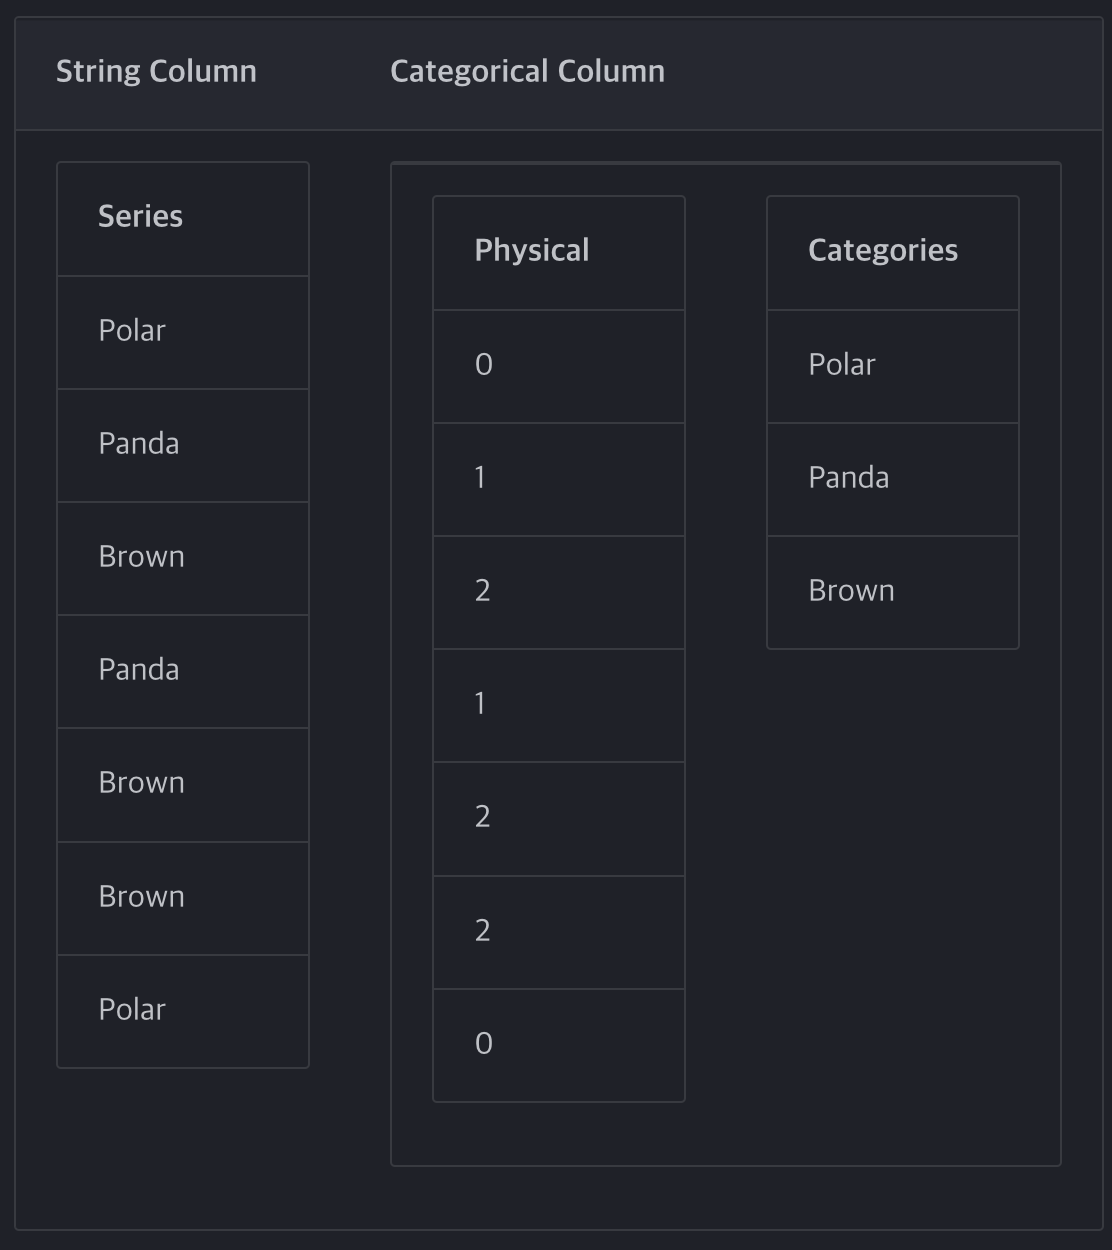

이 경우 물리적 0은 'Polar' 값에 해당하고, 1은 'Panda', 2는 'Brown'에 해당하는 값을 인코딩합니다. 이 인코딩의 장점은 문자열 값을 한 번만 저장한다는 것입니다. 또한, 작업(예: 정렬, 개수 세기)을 수행할 때 문자열 데이터를 사용하는 것보다 훨씬 빠른 물리적 표현을 직접 다룰 수 있습니다.

### Enum 데이터 유형의 인코딩은 전역적입니다
Enum 데이터 유형을 사용할 때, 우리는 범주를 미리 지정합니다. 이렇게 하면 Polars는 서로 다른 열이나 다른 데이터셋이 동일한 인코딩을 가지도록 보장할 수 있으며, 비싼 재인코딩이나 캐시 조회 없이 작업을 수행할 수 있습니다.

### Categorical 데이터 유형과 인코딩
Categorical 데이터 유형의 범주는 추론되므로 비용이 발생합니다. 이 주요 비용은 우리가 인코딩을 제어할 수 없다는 점입니다.

다음 시나리오를 고려해 보겠습니다. 두 개의 범주형 시리즈를 추가하는 경우:

Polars는 문자열 값을 나타나는 순서대로 인코딩합니다. 따라서 시리즈는 다음과 같이 보일 것입니다:


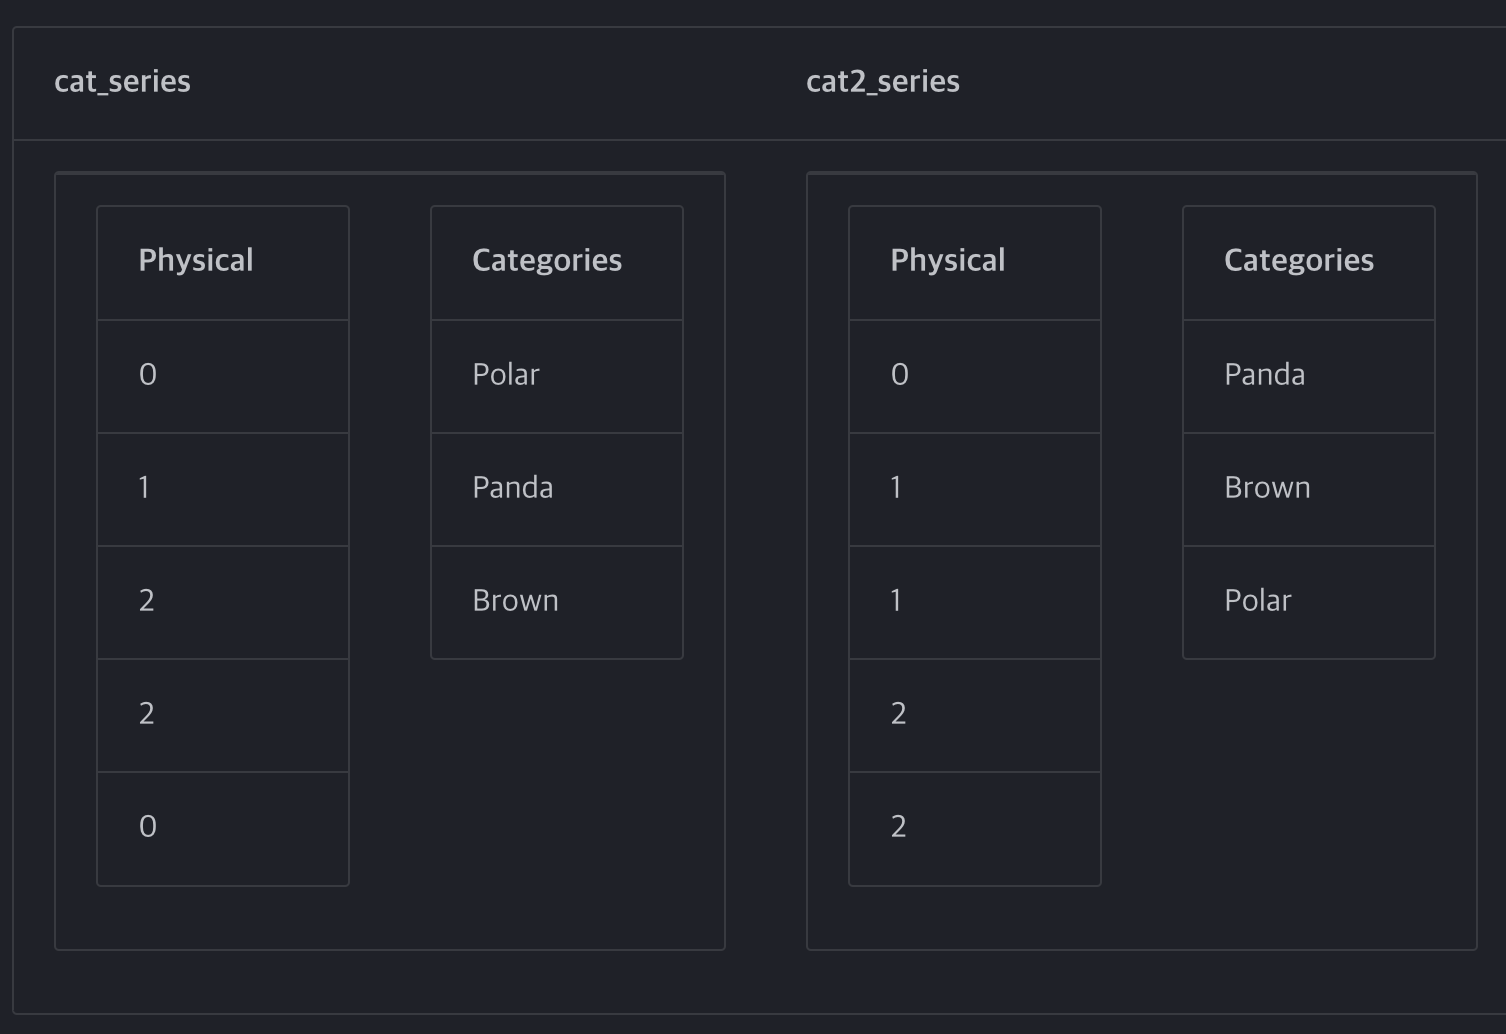

---

## 구조체(Structs)
데이터 유형 **Struct**는 여러 필드를 단일 열에 저장할 수 있는 복합 데이터 유형입니다.

#### Python 비유
Python 사용자에게 **Struct** 데이터 유형은 Python의 **딕셔너리(Dictionary)** 와 유사합니다. 더 나아가, Python의 **typing.TypedDict**와 비슷하다고 생각할 수도 있습니다.

이 사용자 가이드 페이지에서는 **Struct** 데이터 유형이 발생하는 상황을 살펴보고, 그 발생 이유를 이해하며, **Struct** 값을 다루는 방법을 알아봅니다.

먼저, 미국 여러 주에서 몇몇 영화에 대한 평균 평점을 담은 데이터프레임을 예시로 살펴보겠습니다.


In [ ]:
import polars as pl

ratings = pl.DataFrame(
    {
        "Movie": ["Cars", "IT", "ET", "Cars", "Up", "IT", "Cars", "ET", "Up", "Cars"],
        "Theatre": ["NE", "ME", "IL", "ND", "NE", "SD", "NE", "IL", "IL", "NE"],
        "Avg_Rating": [4.5, 4.4, 4.6, 4.3, 4.8, 4.7, 4.5, 4.9, 4.7, 4.6],
        "Count": [30, 27, 26, 29, 31, 28, 28, 26, 33, 28],
    }
)
print(ratings)

### **Struct 데이터 유형과 마주치기**

탐색적 데이터 분석(EDA)에서 자주 사용되는 **value_counts** 함수는 **Struct** 열을 생성하는 일반적인 작업입니다. 데이터에서 특정 주(state)가 등장한 횟수를 확인하는 방식은 다음과 같습니다:


In [ ]:
result = ratings.select(pl.col('Theatre').value_counts(sort= True))
print(result)

상당히 예상 밖의 출력일 수 있습니다. 특히 이런 데이터 유형이 없는 도구에 익숙하다면 더욱 그렇습니다. 그러나 걱정할 필요는 없습니다. 더 익숙한 형태의 출력으로 되돌아가려면 **Struct** 열에 **unnest** 함수를 사용하면 됩니다:


In [ ]:
result = ratings.select(pl.col('Theatre').value_counts(sort=True)).unnest('Theatre')
print(result)

**unnest** 함수는 **Struct**의 각 필드를 개별 열로 변환합니다.

#### 왜 `value_counts`가 Struct를 반환하는가
Polars 표현식은 항상 단일 시리즈에서 작동하고 다른 시리즈를 반환합니다. **Struct**는 여러 열을 표현식의 입력으로 제공하거나 여러 열을 출력으로 반환할 수 있도록 하는 데이터 유형입니다. 따라서 **value_counts**를 사용할 때 각 값과 그 개수를 지정하기 위해 **Struct** 데이터 유형을 사용할 수 있습니다.

### 딕셔너리에서 Struct 데이터 유형 추론하기
시리즈나 데이터프레임을 생성할 때, Polars는 딕셔너리를 **Struct** 데이터 유형으로 변환합니다:


In [ ]:
rating_series = pl.Series(
    "ratings",
    [
        {"Movie": "Cars", "Theatre": "NE", "Avg_Rating": 4.5},
        {"Movie": "Toy Story", "Theatre": "ME", "Avg_Rating": 4.9},
    ],
)
print(rating_series)

필드의 수, 이름, 그리고 유형은 첫 번째로 발견된 딕셔너리에서 추론됩니다. 이후에 일치하지 않는 항목들은 **null** 값으로 처리되거나 오류가 발생할 수 있습니다:


In [ ]:
null_rating_series = pl.Series(
    "ratings",
    [
        {"Movie": "Cars", "Theatre": "NE", "Avg_Rating": 4.5},
        {"Mov": "Toy Story", "Theatre": "ME", "Avg_Rating": 4.9},
        {"Movie": "Snow White", "Theatre": "IL", "Avg_Rating": "4.7"},
    ],
    strict=False,  # To show the final structs with `null` values.
)
print(null_rating_series)

### Struct의 개별 값 추출하기  
위에서 생성한 시리즈에서 **"Movie"** 필드만 추출해야 한다고 가정해봅시다. 이를 위해 **field** 함수를 사용할 수 있습니다:


In [ ]:
result = rating_series.struct.field('Movie')
print(result)

### Struct의 개별 필드 이름 변경하기  
Struct 열의 개별 필드 이름을 변경해야 한다면 **rename_fields** 함수를 사용할 수 있습니다:


In [ ]:
result = rating_series.struct.rename_fields(['Film', 'State', 'Value'])
print(result)

필드 이름이 실제로 변경되었는지 확인하려면, 결과가 유일한 열인 데이터프레임을 생성한 후 **unnest** 함수를 사용하여 각 필드를 개별 열로 변환합니다. 열 이름은 방금 수행한 이름 변경 작업을 반영합니다:








In [ ]:
print(
    result.to_frame().unnest('ratings')
)

### Struct 열의 실용적 사용 사례  
#### 중복 행 식별  
평점 데이터로 돌아가서 **"Movie"** 와 **"Theatre"** 수준에서 중복된 경우를 식별하려고 합니다.

이때 **Struct** 데이터 타입이 빛을 발합니다:


In [ ]:
print(ratings)

In [ ]:
result = ratings.filter(pl.struct('Movie', 'Theatre').is_duplicated())
print(result)

In [ ]:
print(ratings)

우리는 이 수준에서 **is_unique()** 함수를 사용하여 고유한 경우도 식별할 수 있습니다!

### 다중 열 순위 매기기  
중복이 존재한다는 것을 알았을 때, 어떤 평점이 더 높은 우선순위를 가져야 할지 결정하려고 합니다.  
가장 중요한 기준은 **"Count"** 열이며, **"Count"** 값이 같다면 **"Avg_Rating"** 열을 고려합니다.

다음과 같이 수행할 수 있습니다:


In [ ]:
result = ratings.with_columns(
    pl.struct('Count', 'Avg_Rating')
    .rank('dense',descending = True)
    .over('Movie', 'Theatre')
    .alias('Rank')
).filter(pl.struct('Movie', 'Theatre').is_duplicated())

print(result)

Polars에서 위와 같은 복잡한 요구사항을 우아하게 해결하는 방법은 정말 인상적입니다! 위에서 사용된 **over** 함수에 대해 더 알고 싶다면, 윈도우 함수에 대한 사용자 가이드 섹션을 참조하세요.

### 단일 표현식에서 여러 열 사용하기
앞서 언급한 것처럼, **Struct** 데이터 유형은 여러 열을 하나의 표현식으로 전달해야 할 때 유용합니다. 예를 들어, 데이터프레임의 두 열에 대해 Ackermann 함수 값을 계산하려고 한다면, Polars 표현식을 사용하여 Ackermann 함수를 계산할 방법이 없습니다. 따라서 우리는 사용자 정의 함수를 정의합니다:


In [ ]:
def ack(m, n):
    if not m:
        return n + 1
    if not n:
        return ack(m - 1, 1)
    return ack(m - 1, ack(m, n - 1))

이제 해당 인수에 대해 Ackermann 함수 값을 계산하기 위해, 먼저 `m`과 `n` 필드를 가진 Struct를 생성하고, 그런 다음 `map_elements` 함수를 사용하여 각 값에 대해 `ack` 함수를 적용합니다:


In [ ]:
values = pl.DataFrame(
    {
        "m": [0, 0, 0, 1, 1, 1, 2],
        "n": [2, 3, 4, 1, 2, 3, 1],
    }
)
result = values.with_columns(
    pl.struct(["m", "n"])
    .map_elements(lambda s: ack(s["m"], s["n"]), return_dtype=pl.Int64)
    .alias("ack")
)

print(result)

이 데이터에 사용자 정의 Python 함수를 적용하는 방법에 대해서는 이 사용자 가이드 섹션을 참조하세요.
https://docs.pola.rs/user-guide/expressions/user-defined-python-functions/

---

## 결측치(Missing Value)

이 섹션에서는 Polars에서 누락된 데이터를 다루는 방법에 대해 설명합니다.

### null 및 NaN 값
Polars에서 누락된 데이터는 null 값으로 표현됩니다. 이 누락된 값 null은 모든 데이터 유형, 특히 숫자형 데이터 유형에 대해 사용됩니다.

Polars는 또한 부동 소수점 숫자를 위한 NaN(“Not a Number”) 값을 지원합니다. NaN 값은 유효한 부동 소수점 값으로 간주되며, 이는 누락된 데이터와는 다릅니다. NaN 값에 대해서는 아래에서 따로 다룰 것입니다.

시리즈나 데이터프레임을 생성할 때, 적절한 언어 구문을 사용하여 값을 null로 설정할 수 있습니다:


In [ ]:
import polars as pl

df = pl.DataFrame(
    {
        "value": [1, None],
    },
)
print(df)

> Pandas와의 차이점

Pandas에서는 누락된 데이터를 나타내는 값이 열의 데이터 유형에 따라 달라집니다. 반면, Polars에서는 누락된 데이터가 항상 null 값으로 표현됩니다.

### 누락된 데이터 메타데이터
Polars는 각 시리즈에 대해 누락된 데이터와 관련된 메타데이터를 추적합니다. 이 메타데이터는 누락된 값의 수와 누락된 값이 무엇인지에 대한 기본적인 질문을 매우 효율적으로 처리할 수 있게 해줍니다.

열에서 누락된 값의 수를 확인하려면 `null_count` 함수를 사용할 수 있습니다:


In [ ]:
null_count_df = df.null_count()
print(null_count_df)

`null_count` 함수는 데이터프레임, 데이터프레임의 열, 또는 시리즈에서 직접 호출할 수 있습니다. 이 함수는 결과가 이미 알려져 있기 때문에 비용이 적은 연산입니다.

Polars는 "유효성 비트맵(validity bitmap)"이라는 것을 사용하여 시리즈에서 어떤 값이 누락되었는지 확인합니다. 유효성 비트맵은 메모리 효율적이며 비트로 인코딩됩니다. 만약 시리즈의 길이가 `n`이라면, 유효성 비트맵은 `n / 8` 바이트의 공간을 차지합니다. `is_null` 함수는 유효성 비트맵을 사용하여 값이 null인지 아닌지를 효율적으로 보고합니다:


In [ ]:
is_null_seires = df.select(
    pl.col('value').is_null()
)
print(is_null_seires)

`is_null` 함수는 데이터프레임의 열 또는 시리즈에서 직접 사용할 수 있습니다. 다시 말해, 이 연산은 결과가 Polars에 의해 이미 알려져 있기 때문에 비용이 적은 연산입니다.

### Polars가 유효성 비트맵에 메모리를 낭비하는 이유는 무엇인가요?
누락된 데이터를 채우기
시리즈의 누락된 데이터는 `fill_null` 함수를 사용하여 채울 수 있습니다. 누락된 데이터를 채우는 방법은 몇 가지가 있습니다:

- 올바른 데이터 유형의 리터럴 값으로 채우기;
- 다른 열에서 계산된 값과 같은 Polars 표현식으로 채우기;
- 이웃 값을 기반으로 하는 전략(예: 앞뒤로 채우기);
- 보간법(interpolation).

각 방법이 어떻게 작동하는지 설명하기 위해, 두 번째 열에 두 개의 누락된 값이 있는 간단한 데이터프레임을 정의하여 시작합니다:


In [ ]:
df = pl.DataFrame(
    {
        "col1": [0.5, 1, 1.5, 2, 2.5],
        "col2": [1, None, 3, None, 5],
    },
)
print(df)

### 지정된 리터럴 값으로 채우기
누락된 데이터를 지정된 리터럴 값으로 채울 수 있습니다. 이 리터럴 값은 모든 null 값을 대체합니다:

In [ ]:
fill_literal_df = df.with_columns(
    pl.col('col2').fill_null(3)
)
print(fill_literal_df)

그러나 이것은 실제로 `fill_null` 함수가 결측 값을 Polars 표현식의 결과에서 해당 값으로 대체하는 일반적인 경우의 특수한 사례에 불과합니다.


### 표현식으로 채우기

일반적인 경우, 결측 데이터는 Polars 표현식의 결과에서 해당 값을 추출하여 채울 수 있습니다. 예를 들어, 첫 번째 열의 값을 두 배로 늘린 값으로 두 번째 열을 채울 수 있습니다.


In [ ]:
fill_expression_df = df.with_columns(
    pl.col('col2').fill_null((2 * pl.col('col1')).cast(pl.Int64)),
)
print(fill_expression_df)

### 이웃 값을 기반으로 채우기 전략

결측값을 이웃 값을 기반으로 채우는 전략을 사용할 수도 있습니다. 두 가지 간단한 전략은 `null` 값이 채워지는 위치 바로 앞이나 뒤에 오는 첫 번째 `null`이 아닌 값을 찾습니다:


In [ ]:
fill_interpolation_df = df.with_columns(
    pl.col('col2').interpolate(),
)
print(fill_interpolation_df)

### 숫자가 아닌 값(Not a Number, NaN)

시리즈의 결측값은 항상 `null` 값으로 표현됩니다. 이는 시리즈의 데이터 유형에 관계없이 동일합니다. 그러나 부동 소수점 데이터 유형을 가진 열에는 때때로 `NaN` 값을 가질 수 있으며, 이는 `null`과 혼동될 수 있습니다.

특수 값 `NaN`은 다음과 같이 직접 생성할 수 있습니다:


In [ ]:
import numpy as np

nan_df = pl.DataFrame(
    {
        "value": [1.0, np.nan, float("nan"), 3.0],
    },
)
print(nan_df)

또한 이는 계산의 결과로 발생할 수도 있습니다.

In [ ]:
df = pl.DataFrame(
    {
        "dividend": [1, 0, -1],
        "divisor": [1, 0, -1],
    }
)
result = df.select(pl.col("dividend") / pl.col("divisor"))
print(result)

>정보

기본적으로, 정수형 열에서 `NaN` 값은 pandas에서 열을 부동 소수점 데이터 유형으로 변환합니다. 그러나 Polars에서는 이와 달리 예외가 발생합니다.

`NaN` 값은 부동 소수점 데이터의 일종으로 간주되며 Polars에서는 결측값으로 간주되지 않습니다. 즉, 다음과 같은 특징이 있습니다:

- `NaN` 값은 `null_count` 함수에서 계산되지 않습니다.
- `NaN` 값은 `fill_nan` 특수 함수를 사용할 때 채워지지만, `fill_null` 함수에서는 채워지지 않습니다.

Polars에는 `is_nan`과 `fill_nan` 함수가 있으며, 이는 `is_null`과 `fill_null` 함수와 유사한 방식으로 작동합니다. 결측값과 달리, Polars는 `NaN` 값에 대한 메타데이터를 저장하지 않기 때문에 `is_nan` 함수는 실제로 계산을 수행합니다.

`null` 값과 `NaN` 값의 또 다른 차이점은, 평균이나 합계와 같은 수치 집계 함수가 결과를 계산할 때 결측값을 건너뛰는 반면, `NaN` 값은 계산에 포함되며 일반적으로 결과에 전파된다는 점입니다. 원할 경우, 이 동작을 피하기 위해 `NaN` 값을 `null` 값으로 대체할 수 있습니다:


In [ ]:
mean_nan_df = nan_df.with_columns(
    pl.col('value').fill_nan(None).alias('replaced'),
    ).select(
        pl.all().mean().name.suffix('_mean'),
        pl.all().sum().name.suffix('_sum'),
    )
print(mean_nan_df)

`NaN` 값에 대해 더 알고 싶다면, 부동 소수점 숫자 데이터 유형에 대한 섹션을 참조하세요.

https://docs.pola.rs/user-guide/concepts/data-types-and-structures/#floating-point-numbers

---

## 집계(Aggregation)

Polars의 `group_by` 컨텍스트는 데이터를 그룹화하는 기준이 되는 열의 고유 값에 따라 열의 하위 집합에 대한 표현식을 적용할 수 있게 해줍니다. 이는 매우 강력한 기능으로, 이 사용자 가이드 섹션에서 이를 탐구합니다.

우리는 먼저 미국 의회 데이터를 읽어옵니다:


In [ ]:
import polars as pl

url = "hf://datasets/nameexhaustion/polars-docs/legislators-historical.csv"

schema_overrides = {
    "first_name": pl.Categorical,
    "gender": pl.Categorical,
    "type": pl.Categorical,
    "state": pl.Categorical,
    "party": pl.Categorical,
}

dataset = (
    pl.read_csv(url, schema_overrides=schema_overrides)
    .with_columns(pl.col("first", "middle", "last").name.suffix("_name"))
    .with_columns(pl.col("birthday").str.to_date(strict=False))
)

In [ ]:
print(dataset)

### 기본 집계

여러 개의 표현식을 집계 값에 쉽게 적용할 수 있습니다. `agg` 함수 안에 원하는 모든 표현식을 나열하기만 하면 됩니다. 집계의 개수에 제한은 없으며 원하는 모든 조합을 만들 수 있습니다. 아래 코드에서는 데이터를 "first_name" 열을 기준으로 그룹화한 후 다음 집계를 적용합니다:

- 그룹 내의 행 수를 계산 (즉, 데이터 세트에서 각 고유한 첫 번째 이름을 가진 사람 수를 셈);
- "gender" 열의 값을 집계 함수 없이 리스트로 결합;
- "last_name" 열의 첫 번째 값을 그룹 내에서 가져옴.

집계를 계산한 후에는 즉시 결과를 정렬하고 상위 5개의 행만 제한하여 간단한 요약을 만듭니다.


In [ ]:
q = (
    dataset.lazy()
    .group_by('first_name')
    .agg(
        pl.len(),
        pl.col('gender'), 
        pl.first('last_name') # short for 'pl.col('last_name').first()'
    )
    .sort('len', descending=True)
    .limit(5)
)
df = q.collect()
print(df)

정말 쉽죠! 한 단계 더 높여 볼까요.

### 조건문

만약 우리가 특정 주(state)의 대표들이 "Pro" 또는 "Anti" 행정부인지를 알고 싶다면, 람다 함수나 데이터프레임을 조정하는 과정 없이 직접 집계에서 이를 쿼리할 수 있습니다.




In [ ]:
q = (
    dataset.lazy()
    .group_by('state')
    .agg(
        (pl.col('party') == 'Anti-Administration').sum().alias('anti'),
        (pl.col('party') == 'Pro-Administration').sum().alias('pro'),
    )
    .sort('pro', descending=True)
    .limit(5)
)
df = q.collect()
print(df)

### 필터링

우리는 그룹에 대해 평균을 계산할 때, 그 그룹의 모든 값을 포함하고 싶지 않거나, 실제로 데이터프레임에서 행을 필터링하지 않으면서도 다른 집계를 위해 해당 행들이 필요할 수 있습니다.

아래 예시에서는 이를 어떻게 수행할 수 있는지 보여줍니다.

> **참고**  
> Python 함수는 명확성을 위해 정의할 수 있습니다. 이러한 함수는 Polars 표현식을 반환하기 때문에, 쿼리 실행 중에 커스텀 함수를 시리즈에 적용하지 않기 때문에 비용이 들지 않습니다. 물론, 표현식을 반환하는 함수는 Rust로도 작성할 수 있습니다.


In [ ]:
from datetime import date

def compute_age():
    return date.today().year - pl.col('birthday').dt.year()

def avg_birthday(gender: str) -> pl.Expr: 
    return(
        compute_age()
        .filter(pl.col('gender') == gender)
        .mean()
        .alias(f'avg {gender} birthday')
    )

q = (
    dataset.lazy()
    .group_by('state')
    .agg(
        avg_birthday('M'),
        avg_birthday('F'),
        (pl.col('gender') == 'M').sum().alias('# male'),
        (pl.col('gender') == 'F').sum().alias('# female'),
    )
    .limit(5)
)

df = q.collect()
print(df)


> 평균 나이 값이 비논리적으로 보이나요?

그 이유는 우리가 1800년대의 역사적 데이터를 사용하고 있기 때문입니다. 이 데이터를 기반으로 모든 사람이 아직 살아있다고 가정하여 계산을 수행하고 있습니다.

### 중첩된 그룹화

이전에 설명한 두 쿼리는 중첩된 `group_by`로도 수행할 수 있었지만, 이 기능들을 보여주기 위해서는 중첩된 `group_by`를 사용하지 않았습니다. 😉 중첩된 `group_by`를 사용하려면, 그룹화에 사용할 열들을 나열하면 됩니다.

우리는 먼저 중첩된 `group_by`를 사용하여 각 주(state)에서 "Pro" 또는 "Anti" 행정부를 지지하는 대표가 몇 명인지 알아보겠습니다:


In [ ]:
q = (
    dataset.lazy()
    .group_by('state', 'party')
    .agg(pl.len().alias('count'))
    .filter((pl.col('party') == 'Anti-Administaration') | (pl.col('party') == 'Pro-Administration'))
    .sort('count', descending=True)
    .limit(5)
)

df = q.collect()
print(df)

다음은 각 주와 성별에 따른 평균 나이를 계산하기 위해 중첩된 group_by를 사용하는 예제입니다. 이 방법은 그룹별로 추가적인 계산을 수행할 때 유용합니다.

In [ ]:
q = (
    dataset.lazy()
    .group_by('state', 'gender')
    .agg(
        compute_age().mean().alias('avg birthday'),
        pl.len().alias('#'),
    )
    .sort('#', descending= True)
    .limit(5)
)

df = q.collect()
print(df)   


우리는 동일한 결과를 얻지만 데이터의 형식이 다릅니다. 상황에 따라 다른 형식이 더 적합할 수 있습니다.

### 정렬(Sorting)
데이터프레임이 그룹화 작업 중 순서를 관리하기 위한 목적만으로 정렬되는 경우가 많습니다. 예를 들어, 각 주별로 가장 나이가 많은 정치인과 가장 어린 정치인의 이름을 얻고 싶다고 가정해봅시다. 우리는 먼저 정렬을 수행한 후, 그 다음에 그룹화를 할 수 있습니다.

In [ ]:
def get_name() -> pl.Expr:
    return pl.col('first_name') + pl.lit(" ") + pl.col('last_name') # pl.lit()는 리터럴 값을 생성

q = (
    dataset.lazy()
    .sort('birthday', descending=True)
    .group_by('state')
    .agg(
        get_name().first().alias('youngest'), # first()는 가장 빠른 값을 반환
        get_name().last().alias('oldest'), # last()는 가장 늦은 값을 반환   
    )
    .limit(5)
)

df = q.collect()
print(df)

그러나 만약 이름도 알파벳 순으로 정렬하고 싶다면, 추가적인 정렬 작업이 필요합니다. 다행히도, 우리는 기본 데이터프레임의 정렬을 변경하지 않고도 `group_by` 컨텍스트 내에서 정렬을 할 수 있습니다.


In [ ]:
q = (
    dataset.lazy()
    .sort("birthday", descending=True)
    .group_by("state")
    .agg(
        get_name().first().alias("youngest"),
        get_name().last().alias("oldest"),
        get_name().sort().first().alias("alphabetical_first"),
    )
    .limit(5)
)

df = q.collect()
print(df)

우리는 다른 열에 의해 유도된 순서로 열을 정렬할 수도 있으며, 이는 `group_by` 컨텍스트 내에서도 작동합니다. 이전 쿼리에 대한 이 수정은 첫 번째 이름을 가진 대리인이 남성인지 여성인지 확인할 수 있게 해줍니다.


In [ ]:
q = (
    dataset.lazy()
    .sort("birthday", descending=True)
    .group_by("state")
    .agg(
        get_name().first().alias("youngest"),
        get_name().last().alias("oldest"),
        get_name().sort().first().alias("alphabetical_first"),
        pl.col("gender").sort_by(get_name()).first(),
    )
    .sort("state")
    .limit(5)
)

df = q.collect()
print(df)

### 병렬화 방지
> 파이썬 사용자 전용

다음 섹션은 파이썬에만 해당되며, 러스트에는 적용되지 않습니다. 러스트에서는 블록과 클로저(람다)가 병렬로 실행될 수 있으며, 실제로 병렬로 실행됩니다.

파이썬은 일반적으로 러스트보다 느립니다. "느린" 바이트코드를 실행하는 오버헤드 외에도, 파이썬은 전역 인터프리터 락(GIL)의 제약을 받아야 합니다. 즉, 병렬화된 단계에서 람다나 사용자 정의 파이썬 함수를 사용하면, 파이썬 코드 실행이 속도를 제한하며 여러 스레드가 함수를 실행하는 것을 방지합니다.

Polars는 그룹에 대해 집계 함수의 계산을 병렬화하려고 시도하므로, 람다와 사용자 정의 파이썬 함수를 가능한 한 사용하지 않는 것이 좋습니다. 대신, Polars 표현식 API 내에서 작업하는 것이 권장됩니다. 그러나 항상 가능한 것은 아니므로, 람다 사용에 대해 더 알고 싶다면 사용자 정의 함수 사용에 관한 사용자 가이드 섹션을 참고할 수 있습니다.
https://docs.pola.rs/user-guide/expressions/user-defined-python-functions/

---

## **윈도우 함수(Window Function)**  
윈도우 함수는 강력한 기능을 가진 표현식입니다. 이를 사용하면 `select` 문맥 내에서 그룹에 대한 집계를 수행할 수 있습니다. 이러한 기능이 무엇을 의미하는지 감을 잡아봅시다.

먼저, 포켓몬 데이터셋을 불러옵니다:


In [ ]:
import polars as pl

types = (
    "Grass Water Fire Normal Ground Electric Psychic Fighting Bug Steel "
    "Flying Dragon Dark Ghost Poison Rock Ice Fairy".split()
)
type_enum = pl.Enum(types)
# then let's load some csv data with information about pokemon
pokemon = pl.read_csv(
    "/Users/ijian/Documents/Polars/pokemon.csv",
).cast({"Type 1": type_enum, "Type 2": type_enum})
print(pokemon.head())

### **그룹별 연산**  
윈도우 함수는 그룹 내에서 연산을 수행할 때 이상적입니다. 예를 들어, 포켓몬을 **Speed** 열에 따라 순위를 매기고 싶다고 가정합시다. 그러나 전체 데이터셋에서의 순위가 아니라, **Type 1** 열의 고유한 값으로 정의된 각 그룹 내에서 순위를 매기고 싶습니다.

이를 위해 **Speed** 열에 따라 데이터를 순위 매기는 표현식을 작성하고, 그다음에 `over` 함수를 추가하여 이 작업이 **Type 1** 열의 고유 값에 대해 수행되도록 지정합니다.


In [ ]:
result = pokemon.select(
    pl.col("Name", "Type 1", 'Speed'),
    pl.col("Speed").rank("dense", descending=True).over("Type 1").alias("Speed rank"),
)

print(result)

✅ 2. `pl.col("Speed").rank("dense", descending=True)`
 👉 Speed 컬럼에 순위 매기기

`rank()`는 데이터를 순위로 변환합니다.  
여기서 `"dense"` 방식은 **순위가 연속적으로 매겨지는 방식**입니다.

| 방식        | 순위 예시 |
|------------|------------------------|
| `"dense"`   | `1, 2, 3` (같은 값이면 동일 순위, 다음 값은 바로 다음 순위) |
| `"ordinal"` | `1, 2, 3, 4` (무조건 순서대로 매김) |
| `"average"` | **평균 순위**를 부여 |


### 작업 시각화  

이 작업을 시각화하기 위해, Polars가 **Type 1** 열에 대해 동일한 값을 공유하는 데이터 하위 집합을 선택한 다음, 해당 값들에 대해서만 순위 매기기 표현식을 계산한다고 상상할 수 있습니다.  

그 후, 특정 그룹에 대한 결과가 원래 행에 다시 투영되며, Polars는 모든 기존 그룹에 대해 이 작업을 수행합니다.  

아래 다이어그램은 **Type 1**이 **Grass**인 포켓몬에 대한 순위 계산을 강조합니다.

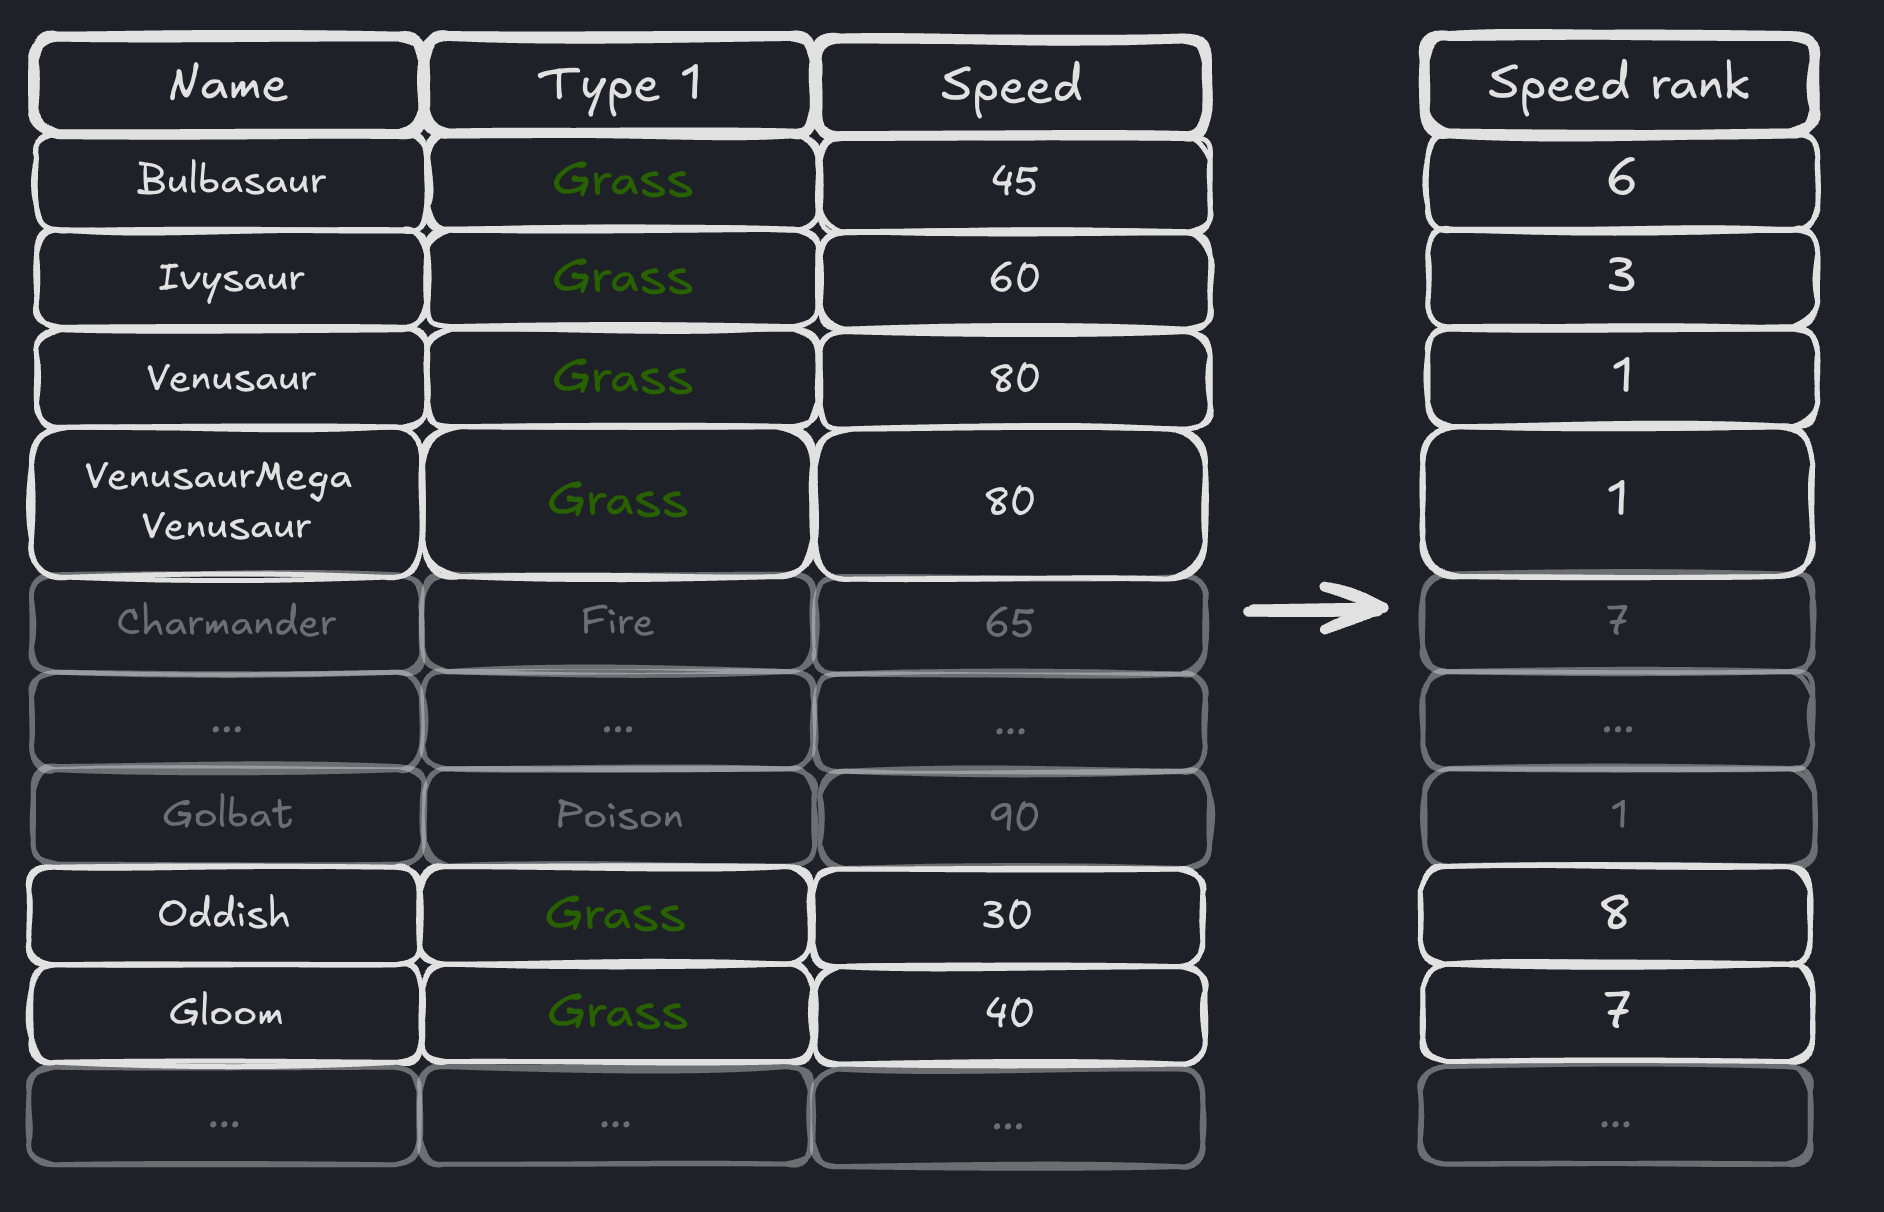


**참고:**  
포켓몬 **Golbat**의 **Speed** 값은 90으로, **Venusaur**의 값인 80보다 크지만, 두 포켓몬은 **Type 1** 열의 동일한 값을 공유하지 않기 때문에 **Venusaur**가 1위로 순위가 매겨졌습니다.

**over** 함수는 임의의 수의 표현식을 허용하여, 계산을 수행할 그룹을 지정할 수 있습니다.  
위의 순위 매기기를 반복하되, 보다 세분화된 순위를 위해 **Type 1** 및 **Type 2** 열의 조합에 대해 수행할 수 있습니다.


In [ ]:
result = pokemon.select(
    pl.col('Name', 'Type 1', 'Type 2', 'Speed'),
    pl.col('Speed')
    .rank('dense', descending=True)
    .over('Type 1', 'Type 2')
    .alias('Speed rank')    
)

print(result)

**일반적으로**  
**over** 함수를 사용하여 얻는 결과는 **집계(aggregation)** 후 **explode** 함수를 호출하여도 얻을 수 있습니다.  
그러나 이 경우 행의 순서는 다르게 나타날 수 있습니다.


In [ ]:
result = (
    pokemon.group_by('Type 1')
    .agg(
        pl.col('Name'),
        pl.col('Speed').rank('dense', descending=True).alias('Speed rank'),
    )
    .select(pl.col('Name'), pl.col('Type 1'), pl.col('Speed rank'))
    .explode('Name', 'Speed rank')
)
print(result)

**이것은 일반적으로 group_by와 over가 서로 다른 형태의 결과를 생성함을 보여줍니다:**

- **group_by**는 보통 집계를 위해 사용된 그룹 수와 동일한 수의 행을 가진 결과 데이터프레임을 생성합니다.
- **over**는 보통 원래 데이터프레임과 동일한 수의 행을 가진 데이터프레임을 생성합니다.

**over** 함수는 항상 원래 데이터프레임과 동일한 수의 행을 생성하지 않으며, 다음에서 이 점을 탐구합니다.

### 데이터프레임 행에 결과 매핑하기
**over** 함수는 **mapping_strategy** 매개변수를 허용하여 그룹에서 계산된 표현식의 결과가 데이터프레임 행에 어떻게 매핑되는지 결정합니다.

#### group_to_rows
기본 동작은 `"group_to_rows"`입니다. 그룹에서 계산된 표현식의 결과가 그룹과 동일한 길이가 되며, 결과는 해당 그룹의 행에 매핑됩니다.

행의 순서가 중요하지 않은 경우, **"explode"** 옵션이 더 성능이 좋습니다. 결과 값을 원래 행에 매핑하는 대신, Polars는 동일한 그룹의 값들이 서로 인접하게 나타나는 새로운 데이터프레임을 생성합니다.

이 차이를 이해하는 데 도움이 되도록 다음 데이터프레임을 고려해 보세요.


In [ ]:
# 데이터 생성
data = {
    "athlete": ["A", "B", "C", "D", "E", "F"],
    "country": ["PT", "NL", "NL", "PT", "PT", "NL"],
    "rank": [6, 1, 5, 4, 2, 3]
}

# Polars DataFrame 생성
athletes = pl.DataFrame(data)

# 출력
print(df)


우리는 선수들을 각 국가 내에서 순위에 따라 정렬할 수 있습니다. 그렇게 하면 네덜란드 선수들은 두 번째, 세 번째, 그리고 여섯 번째 행에 위치하며 그대로 유지됩니다. 변경되는 것은 선수들의 이름 순서로, **“B”**, **“C”**, **“F”** 에서 **“B”**, **“F”**, **“C”** 로 바뀝니다.


In [ ]:
result = athletes.select(
    pl.col("athlete", "rank").sort_by(pl.col("rank")).over(pl.col("country")),
    pl.col("country"),
)

print(result)

아래 다이어그램은 이러한 변환을 나타냅니다.

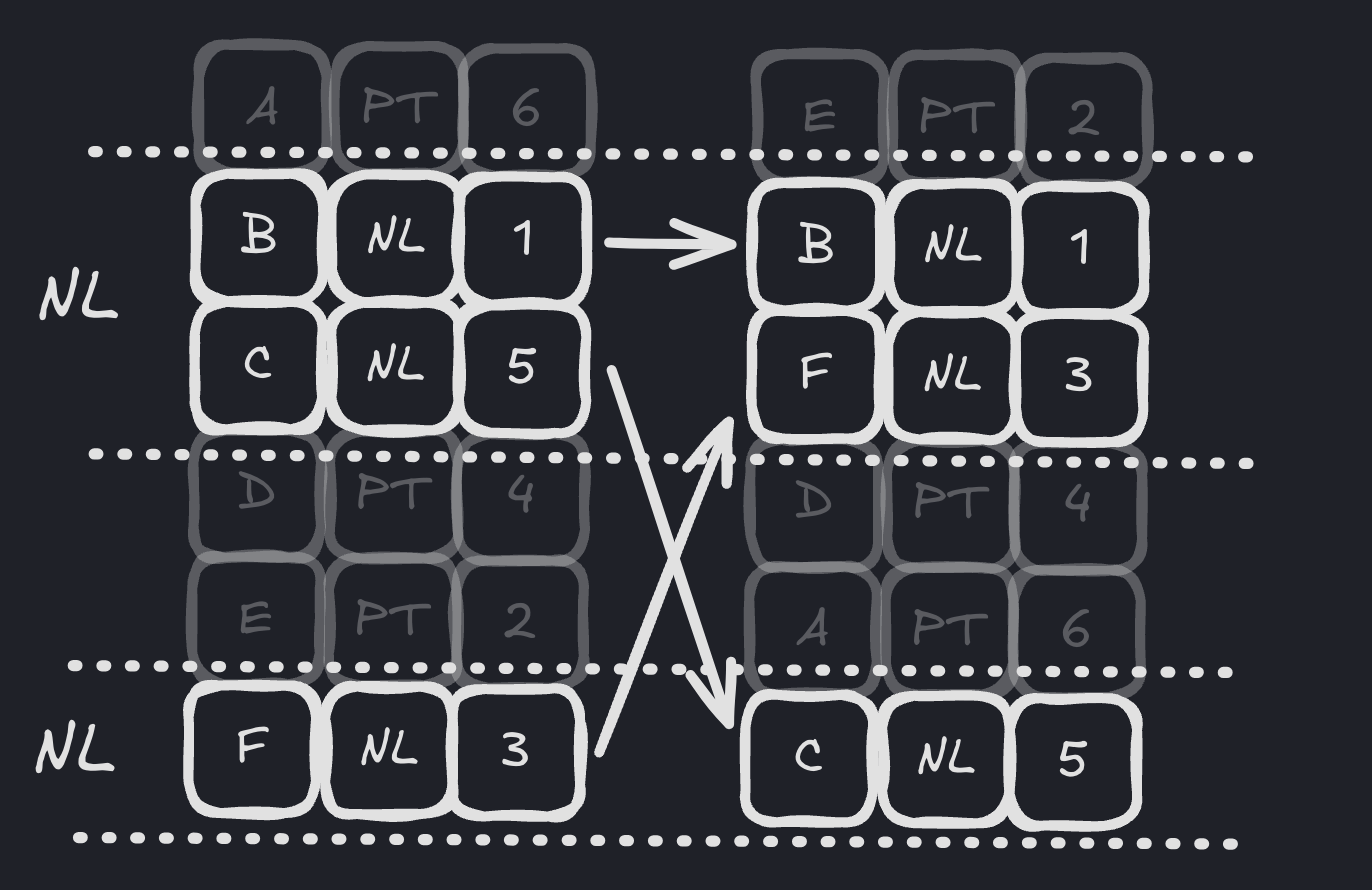

### explode
만약 매개변수 `mapping_strategy`를 "explode"로 설정하면, 동일한 국가의 선수들이 함께 그룹화되지만, 국가에 대한 최종 행의 순서는 다르게 될 것입니다. 아래 다이어그램에서 이를 확인할 수 있습니다:


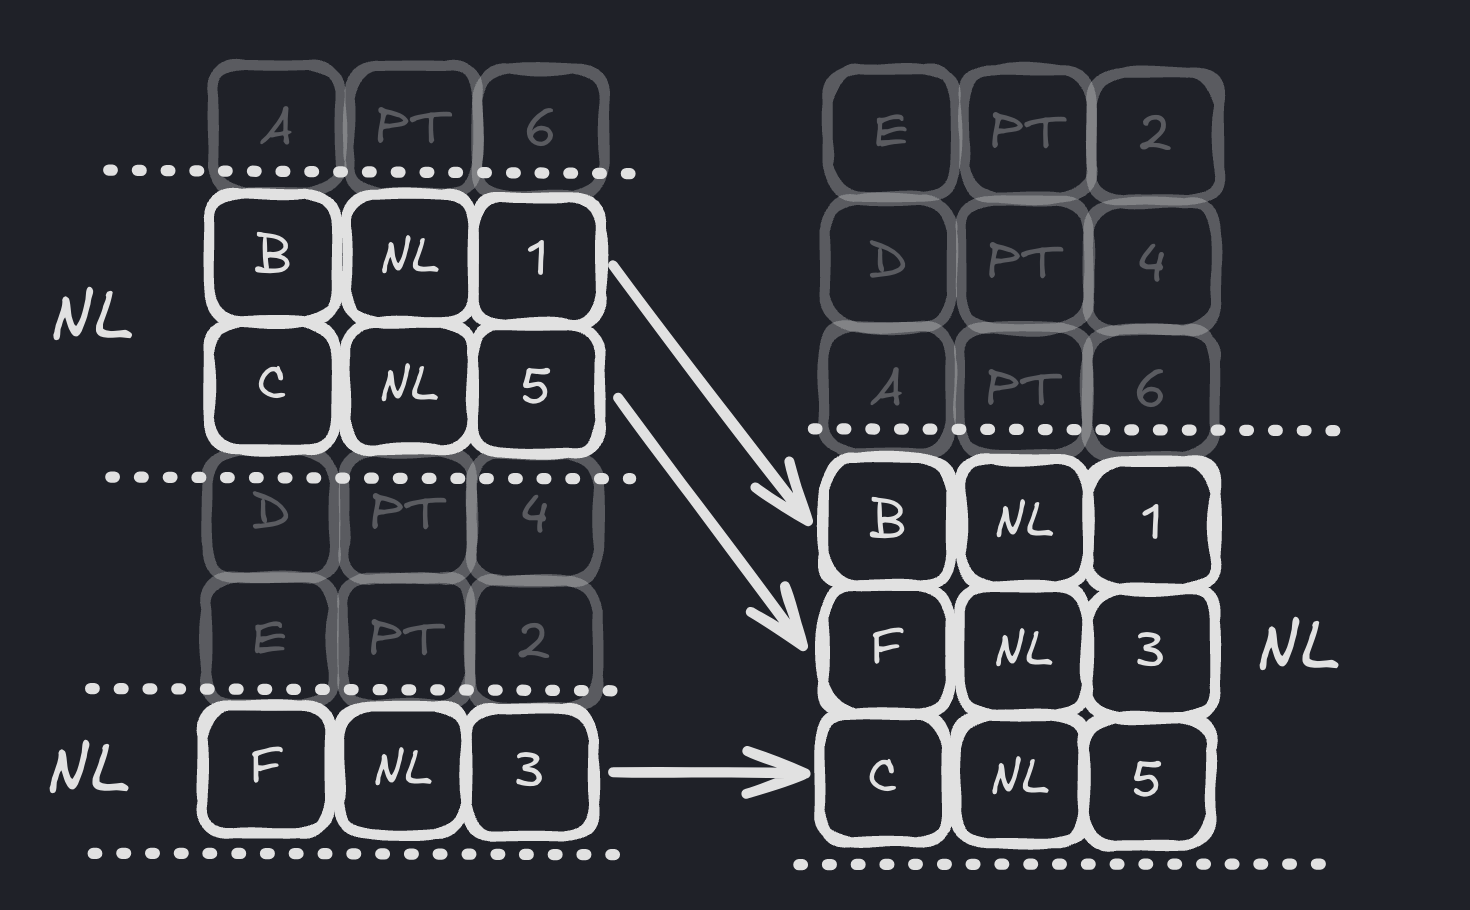

> **"explode" 사용**

Polars는 각 그룹의 행 위치를 추적할 필요가 없기 때문에, "explode"를 사용하는 것이 일반적으로 "group_to_rows"보다 더 빠릅니다. 그러나 "explode"를 사용할 때는 다른 열을 유지하려면 순서를 재정렬해야 하므로 더 주의가 필요합니다. 이 결과를 생성하는 코드는 다음과 같습니다:


In [ ]:
result = athletes.select(
    pl.all()
    .sort_by(pl.col('rank'))
    .over(pl.col('country'), mapping_strategy = 'explode')
)
print(result)

### 윈도우 집계 표현식  
그룹의 값에 적용된 표현식이 스칼라 값을 생성하는 경우, 스칼라 값은 그룹의 행 전체에 브로드캐스트됩니다:


In [ ]:
result = pokemon.select(
    pl.col("Name", "Type 1", "Speed"),
    pl.col("Speed").mean().over(pl.col("Type 1")).alias("Mean speed in group"),
)

print(result)

### 더 많은 예제  
연습을 위해 아래와 같은 윈도우 함수들을 계산해봅니다:

- 모든 포켓몬을 타입별로 정렬  
- "Type 1"으로 첫 3마리 포켓몬 선택  
- 타입 내에서 속도를 기준으로 내림차순 정렬 후 첫 3마리 선택 ("fastest/group")  
- 타입 내에서 공격력을 기준으로 내림차순 정렬 후 첫 3마리 선택 ("strongest/group")  
- 타입 내에서 이름순으로 정렬 후 첫 3마리 선택 ("sorted_by_alphabet")  


In [ ]:
result = pokemon.sort("Type 1").select(
    pl.col("Type 1").head(3).over("Type 1", mapping_strategy="explode"),
    pl.col("Name")
    .sort_by(pl.col("Speed"), descending=True)
    .head(3)
    .over("Type 1", mapping_strategy="explode")
    .alias("fastest/group"),
    pl.col("Name")
    .sort_by(pl.col("Attack"), descending=True)
    .head(3)
    .over("Type 1", mapping_strategy="explode")
    .alias("strongest/group"),
    pl.col("Name")
    .sort()
    .head(3)
    .over("Type 1", mapping_strategy="explode")
    .alias("sorted_by_alphabet"),
)
print(result)

---

### 폴드 (Folds)  
Polars는 `sum_horizontal`, `mean_horizontal`, `min_horizontal`과 같은 여러 표현식을 제공하여 열 간 연산을 수행합니다. 그러나 이러한 기능은 **폴드(fold)**라는 일반 알고리즘의 특수한 경우이며, Polars는 기본 제공 기능으로 충분하지 않을 때 사용자 정의 폴드를 계산할 수 있도록 일반적인 메커니즘을 제공합니다.

폴드는 전체 열에 대해 연산을 수행하도록 설계되어 최대 속도를 보장합니다. 데이터 레이아웃을 효율적으로 활용하며, 종종 벡터화된 방식으로 실행됩니다.

### 기본 예제  
첫 번째 예제로, `sum_horizontal`을 `fold` 함수를 사용하여 재구현합니다.


In [ ]:
import operator
import polars as pl

df = pl.DataFrame(
    {
        "label": ["foo", "bar", "spam"],
        "a": [1, 2, 3],
        "b": [10, 20, 30],
    }
)

result = df.select(
    pl.fold(
        acc=pl.lit(0),
        function=operator.add,
        exprs=pl.col("a", "b"),
    ).alias("sum_fold"),
    pl.sum_horizontal(pl.col("a", "b")).alias("sum_horz"),
)

print(result)

`fold` 함수는 **함수 `f`**를 매개변수로 받습니다. 함수 `f`는 두 개의 인자를 받아야 합니다:

1. **첫 번째 인자**: 누적된 결과 (초기값은 `0`으로 설정됨)  
2. **두 번째 인자**: 매개변수 `exprs`에 나열된 표현식의 순차적인 값 (이 예제에서는 열 `"a"`와 `"b"`)

아래 코드 스니펫에는 `fold` 함수가 수행하는 작업을 명시적으로 표현한 세 번째 표현식이 포함되어 있습니다.

In [ ]:
acc = pl.lit(0)
f = operator.add

result = df.select(
    f(f(acc, pl.col("a")), pl.col("b")),
    pl.fold(acc=acc, function=f, exprs=pl.col("a", "b")).alias("sum_fold"),
)

print(result)

### 파이썬의 fold  
대부분의 프로그래밍 언어에는 **고차 함수**가 포함되어 있으며, 이는 Polars의 `fold` 함수가 구현하는 알고리즘과 유사합니다. Polars의 `fold`는 파이썬의 `functools.reduce`와 매우 비슷합니다. `functools.reduce`의 강력한 기능에 대한 자세한 내용은 이 [기사](https://docs.python.org/3/library/functools.html#functools.reduce)를 참조하세요.

### 누산기(acc)의 초기값  
누산기 `acc`의 초기값은 일반적으로 수행하려는 연산의 **항등원(identity element)**입니다.  
예를 들어, 열에 대해 곱셈 연산을 수행하려면 초기 누산값이 0이면 올바른 결과를 얻을 수 없습니다.


In [ ]:
result = df.select(
    pl.fold(
        acc=pl.lit(0),
        function=operator.mul,
        exprs=pl.col("a", "b"),
    ).alias("prod"),
)

print(result)

이를 해결하려면 누산기 **`acc`**의 초기값을 **1**로 설정해야 합니다.


In [ ]:
result = df.select(
    pl.fold(
        acc=pl.lit(1),
        function=operator.mul,
        exprs=pl.col("a", "b"),
    ).alias("prod"),
)

print(result)

### 조건문  
데이터프레임의 모든 열에 조건/판별식을 적용하고 싶을 때, **폴드(fold)** 를 사용하면 이를 매우 간결하게 표현할 수 있습니다.


In [ ]:
df = pl.DataFrame(
    {
        "a": [1, 2, 3],
        "b": [0, 1, 2],
    }
)

result = df.filter(
    pl.fold(
        acc=pl.lit(True),
        function=lambda acc, x: acc & x,
        exprs=pl.all() > 1,
    )
)
print(result)

위의 스니펫은 모든 열이 1보다 큰 모든 행을 필터링합니다.

### 폴드와 문자열 데이터  
폴드는 문자열 데이터를 연결하는 데 사용할 수 있습니다. 그러나 중간 열의 실체화(materialization)로 인해 이 작업은 **제곱 복잡도(squared complexity)**를 가질 수 있습니다.

따라서 이 경우에는 **concat_str** 함수를 사용하는 것이 권장됩니다.


In [ ]:
df = pl.DataFrame(
    {
        "a": ["a", "b", "c"],
        "b": [1, 2, 3],
    }
)

result = df.select(pl.concat_str(["a", "b"]))
print(result)

---

### 사용자 정의 Python 함수  
Polars 표현식은 매우 강력하고 유연하여 다른 라이브러리와 비교했을 때 사용자 정의 Python 함수의 필요성이 훨씬 적습니다. 그러나 표현식의 상태를 타사 라이브러리에 전달하거나 Polars 데이터에 블랙박스 함수(black box function)를 적용해야 하는 경우가 있을 수 있습니다.

이 문서에서는 이러한 작업을 수행할 수 있도록 두 가지 API를 사용합니다:

- **map_elements**: 시리즈(Series)의 각 값을 개별적으로 처리하는 함수 호출  
- **map_batches**: 항상 전체 시리즈를 함수에 전달  

### map_elements()를 사용한 개별 값 처리  
가장 간단한 경우부터 시작합니다. 시리즈의 각 값을 개별적으로 처리하려고 합니다. 아래는 데이터 예시입니다.


In [ ]:
df = pl.DataFrame(
    {
        "keys": ["a", "a", "b", "b"],
        "values": [10, 7, 1, 23],
    }
)
print(df)

각 개별 값에 대해 **math.log()** 함수를 호출합니다:


In [ ]:
import math


def my_log(value):
    return math.log(value)


out = df.select(pl.col("values").map_elements(my_log, return_dtype=pl.Float64))
print(out)

이 방식은 작동하지만, **map_elements()**에는 두 가지 문제가 있습니다:

1. **개별 항목에만 제한됨**: 종종 계산을 한 번에 각 항목이 아니라 전체 시리즈에서 수행해야 할 때가 있습니다.
2. **성능 오버헤드**: 각 항목에 대해 개별적으로 함수를 호출하는 것은 느립니다. 각 항목마다 함수 호출이 추가되어 성능 오버헤드가 많이 발생합니다.

우리는 첫 번째 문제를 해결한 후 두 번째 문제를 어떻게 해결할지 살펴보겠습니다.

### 전체 시리즈 처리하기: map_batches()

전체 시리즈의 내용을 처리하는 사용자 정의 함수를 실행하고자 합니다. 예시로, 시리즈의 평균값과 각 값 사이의 차이를 계산해 보겠습니다.

**map_batches()** API를 사용하여 전체 시리즈나 **group_by()** 에서 개별 그룹에 대해 이 함수를 실행할 수 있습니다:


In [ ]:
def diff_from_mean(series):
    # This will be very slow for non-trivial Series, since it's all Python
    # code:
    total = 0
    for value in series:
        total += value
    mean = total / len(series)
    return pl.Series([value - mean for value in series])


# Apply our custom function to a full Series with map_batches():
out = df.select(pl.col("values").map_batches(diff_from_mean))
print("== select() with UDF ==")
print(out)

# Apply our custom function per group:
print("== group_by() with UDF ==")
out = df.group_by("keys").agg(pl.col("values").map_batches(diff_from_mean))
print(out)

### 사용자 정의 함수로 빠른 연산하기

순수 Python 구현의 문제는 느리다는 점입니다. 일반적으로 빠른 결과를 얻기 위해서는 가능한 한 Python 코드를 최소화하는 것이 좋습니다.

속도를 최대화하려면 컴파일된 언어로 작성된 함수를 사용하는 것이 중요합니다. 숫자 계산의 경우, Polars는 NumPy에서 정의한 "ufuncs"와 "generalized ufuncs"라는 두 가지 인터페이스를 지원합니다. 첫 번째는 각 항목을 개별적으로 실행하고, 두 번째는 전체 NumPy 배열을 받아 더 유연한 연산을 가능하게 합니다.

NumPy와 SciPy와 같은 다른 라이브러리에는 Polars와 함께 사용할 수 있는 미리 작성된 ufuncs가 포함되어 있습니다. 예를 들어:


In [ ]:
import numpy as np

out = df.select(pl.col("values").map_batches(np.log))
print(out)

### 예시: Numba를 이용한 빠른 사용자 정의 함수

NumPy에서 제공하는 미리 작성된 함수들은 유용하지만, 우리의 목표는 자신만의 함수를 작성하는 것입니다. 예를 들어, 위에서 설명한 `diff_from_mean()`의 빠른 버전을 작성한다고 가정해 봅시다. 이를 Python에서 가장 쉽게 작성하는 방법은 Numba를 사용하는 것입니다. Numba는 Python의 (부분적인) 하위 집합을 사용하여 사용자 정의 함수를 작성하면서도 컴파일된 코드의 이점을 얻을 수 있게 해줍니다.

특히, Numba는 `@guvectorize`라는 데코레이터를 제공합니다. 이 데코레이터는 Python 함수를 빠른 머신 코드로 컴파일하여 일반화된 ufunc를 생성하며, 이를 Polars에서 사용할 수 있게 해줍니다.

다음 예제에서 `diff_from_mean_numba()`는 import 시 빠른 머신 코드로 컴파일되며, 이 과정은 약간의 시간이 걸립니다. 그 후, 함수에 대한 모든 호출은 빠르게 실행됩니다. Series는 함수에 전달되기 전에 NumPy 배열로 변환됩니다.


In [ ]:
from numba import float64, guvectorize, int64


# This will be compiled to machine code, so it will be fast. The Series is
# converted to a NumPy array before being passed to the function. See the
# Numba documentation for more details:
# https://numba.readthedocs.io/en/stable/user/vectorize.html
@guvectorize([(int64[:], float64[:])], "(n)->(n)")
def diff_from_mean_numba(arr, result):
    total = 0
    for value in arr:
        total += value
    mean = total / len(arr)
    for i, value in enumerate(arr):
        result[i] = value - mean


out = df.select(pl.col("values").map_batches(diff_from_mean_numba))
print("== select() with UDF ==")
print(out)

out = df.group_by("keys").agg(pl.col("values").map_batches(diff_from_mean_numba))
print("== group_by() with UDF ==")
print(out)

### 결측값은 일반화된 ufunc 호출 시 허용되지 않음

`diff_from_mean_numba()`와 같은 사용자 정의 함수가 호출되기 전에, Series는 NumPy 배열로 변환됩니다. 불행히도, NumPy 배열은 결측값을 처리하는 개념을 가지고 있지 않습니다. 원본 Series에 결측값이 있을 경우, 변환된 배열은 실제로 Series와 일치하지 않을 수 있습니다.

값을 항목별로 계산할 때는 문제가 되지 않습니다. 예를 들어, `numpy.log()`는 각 개별 값에 대해 호출되므로 결측값이 계산에 영향을 미치지 않습니다. 그러나 사용자 정의 함수의 결과가 Series의 여러 값에 의존하는 경우, 결측값에 대해 정확히 무엇을 해야 할지 명확하지 않습니다.

따라서, Numba 함수와 같이 `@guvectorize`로 데코레이트된 일반화된 ufunc를 호출할 때, 결측값이 포함된 Series를 전달하려 하면 Polars는 오류를 발생시킵니다. 결측값을 처리하려면, 사용자 정의 함수를 호출하기 전에 결측값을 채우거나 제거해야 합니다.

### 여러 열 값을 결합하기

여러 열을 사용자 정의 함수에 전달하고 싶다면, Struct를 사용할 수 있습니다. Struct는 다른 섹션에서 자세히 다루고 있지만, 기본 아이디어는 여러 열을 Struct로 결합하고, 함수 내에서 다시 이 열들을 추출하는 방식입니다.


In [ ]:
# Add two arrays together:
@guvectorize([(int64[:], int64[:], float64[:])], "(n),(n)->(n)")
def add(arr, arr2, result):
    for i in range(len(arr)):
        result[i] = arr[i] + arr2[i]


df3 = pl.DataFrame({"values1": [1, 2, 3], "values2": [10, 20, 30]})

out = df3.select(
    # Create a struct that has two columns in it:
    pl.struct(["values1", "values2"])
    # Pass the struct to a lambda that then passes the individual columns to
    # the add() function:
    .map_batches(
        lambda combined: add(
            combined.struct.field("values1"), combined.struct.field("values2")
        )
    )
    .alias("add_columns")
)
print(out)

### 스트리밍 계산

전체 Series를 사용자 정의 함수에 전달하는 것은 비용이 들 수 있습니다. 그 내용물이 NumPy 배열로 복사되기 때문에 많은 메모리를 사용할 수 있기 때문입니다. `map_batches`에 `is_elementwise=True` 인수를 사용하면 결과를 함수로 스트리밍할 수 있습니다. 이는 모든 값을 한 번에 받지 않을 수 있음을 의미합니다.

**참고**  
`is_elementwise` 인수는 잘못 설정할 경우 부정확한 결과를 초래할 수 있습니다. `is_elementwise=True`로 설정할 때는 함수가 실제로 항목별로 작동하는지 확인해야 합니다 (예: "각 값의 로그를 계산하기"). 예를 들어, `diff_from_mean()` 함수는 그렇지 않으므로 이 경우 부적합합니다.

### 반환 타입

사용자 정의 Python 함수는 종종 "블랙 박스"입니다. Polars는 함수가 무엇을 하는지, 반환값이 무엇인지 알 수 없습니다. 따라서 반환되는 데이터 타입은 자동으로 추론됩니다. 이는 첫 번째 비결측값을 기다려서 그 값을 사용하여 결과 Series의 타입을 결정하는 방식으로 이루어집니다.

Python 타입과 Polars 데이터 타입의 매핑은 다음과 같습니다:

- `int` -> `Int64`
- `float` -> `Float64`
- `bool` -> `Boolean`
- `str` -> `String`
- `list[tp]` -> `List[tp]` (내부 타입은 동일한 규칙으로 추론)
- `dict[str, [tp]]` -> `struct`
- `Any` -> `object` (이 타입은 피해야 합니다)

Rust 타입은 다음과 같이 매핑됩니다:

- `i32` 또는 `i64` -> `Int64`
- `f32` 또는 `f64` -> `Float64`
- `bool` -> `Boolean`
- `String` 또는 `str` -> `String`
- `Vec<tp>` -> `List[tp]` (내부 타입은 동일한 규칙으로 추론)


---

## Numpy 함수

Polars 표현식은 NumPy의 ufuncs를 지원합니다. 지원되는 모든 NumPy 함수 목록은 NumPy 문서를 참조하세요.

즉, Polars에서 제공하지 않는 함수는 NumPy를 사용하여 여전히 빠른 열 연산을 할 수 있습니다.

### 예시

In [1]:
import polars as pl
import numpy as np
df = pl.DataFrame({
    'a': [1,2,3],
    'b' :[4,5,6]
})

out = df.select(np.log(pl.all()).name.suffix('_log'))
print(out)

shape: (3, 2)
┌──────────┬──────────┐
│ a_log    ┆ b_log    │
│ ---      ┆ ---      │
│ f64      ┆ f64      │
╞══════════╪══════════╡
│ 0.0      ┆ 1.386294 │
│ 0.693147 ┆ 1.609438 │
│ 1.098612 ┆ 1.791759 │
└──────────┴──────────┘


### 상호 운용성

Polars의 시리즈는 NumPy 유니버설 함수(ufuncs)와 일반화된 ufuncs를 지원합니다. np.exp, np.cos, np.div 등과 같은 원소별 함수는 거의 오버헤드 없이 작동합니다.

하지만 Polars는 누락된 값을 별도의 비트마스크로 추적하는 반면, NumPy는 이 정보를 받지 못합니다. 이로 인해 윈도우 함수나 np.convolve가 잘못되거나 불완전한 결과를 초래할 수 있습니다. 따라서 누락된 데이터가 있는 시리즈를 일반화된 ufunc에 전달하면 오류가 발생합니다. Polars 시리즈를 NumPy 배열로 변환하려면 `to_numpy` 함수를 사용하십시오. 변환 중에 누락된 값은 np.nan으로 대체됩니다.


---

# 변환(Transformation)
이 섹션의 초점은 다양한 유형의 데이터 변환을 설명하고, 이를 사용하는 방법에 대한 예시를 제공하는 것입니다.

## 조인 (Joins)

조인 작업은 하나 이상의 데이터프레임의 열을 결합하여 새로운 데이터프레임을 생성하는 작업입니다. 서로 다른 "조인 전략"과 일치 기준은 열을 결합하는 방법뿐만 아니라 조인 작업 결과에 포함될 행에도 영향을 미칩니다.

가장 일반적인 조인 유형은 "등호 조인(equi join)"으로, 이 조인에서는 행이 키 표현식으로 매칭됩니다. Polars는 등호 조인의 여러 가지 전략을 지원하며, 이는 행 매칭을 처리하는 방식에 영향을 줍니다. 또한 Polars는 "비등호 조인(non-equi join)"을 지원하는데, 이는 일치 기준이 등호가 아닌 조인 유형입니다. 또한 "Asof 조인(asof join)"이라는 유형도 지원하는데, 이는 행이 키 근접성에 의해 매칭되는 방식입니다.

### 빠른 참조 테이블

아래 테이블은 필요한 내용을 이미 알고 있는 사람들을 위한 빠른 참조로 제공됩니다. 조인에 대해 전반적으로 배우고 Polars에서 조인을 어떻게 사용하는지 알고 싶다면, 테이블을 건너뛰고 아래를 계속 읽어보세요.


### 조인 유형 (Types of Joins)

| **유형 (Type)**                | **함수 (Function)**                   | **간단한 설명 (Brief description)**                                                                 |
|--------------------------------|--------------------------------------|--------------------------------------------------------------------------------------------------|
| **등호 내부 조인 (Equi inner join)** | `join(..., how="inner")`            | 왼쪽과 오른쪽 모두에서 일치하는 행만 유지합니다.                                                     |
| **등호 왼쪽 외부 조인 (Equi left outer join)** | `join(..., how="left")`             | 왼쪽의 모든 행과 오른쪽의 일치하는 행을 유지합니다. 일치하지 않는 왼쪽 행은 오른쪽 열이 null로 채워집니다. |
| **등호 오른쪽 외부 조인 (Equi right outer join)** | `join(..., how="right")`            | 오른쪽의 모든 행과 왼쪽의 일치하는 행을 유지합니다. 일치하지 않는 오른쪽 행은 왼쪽 열이 null로 채워집니다. |
| **등호 전체 조인 (Equi full join)** | `join(..., how="full")`             | 양쪽 데이터프레임에서 모든 행을 유지하며, 일치 여부에 관계없이 비일치 행은 반대쪽에서 null로 채워집니다. |
| **등호 세미 조인 (Equi semi join)** | `join(..., how="semi")`             | 오른쪽에 일치하는 행이 있는 왼쪽의 행만 유지합니다.                                                  |
| **등호 앤티 조인 (Equi anti join)** | `join(..., how="anti")`             | 오른쪽에 일치하는 행이 없는 왼쪽의 행만 유지합니다.                                                  |
| **비등호 내부 조인 (Non-equi inner join)** | `join_where`                        | 주어진 조건을 만족하는 왼쪽과 오른쪽의 행들을 모두 찾습니다.                                          |
| **Asof 조인 (Asof join)**         | `join_asof/join_asof_by`            | 왼쪽 외부 조인처럼 동작하지만, 정확한 키 매칭 대신 가장 가까운 키에서 매칭됩니다.                    |
| **카르테시안 곱 (Cartesian product)** | `join(..., how="cross")`            | 두 데이터프레임의 카르테시안 곱을 계산합니다.                                                      |


### Equi Joins
동등 조인에서는 키 표현식의 동등성(equality)을 확인하여 행을 매칭합니다. `join` 함수를 사용하여 동등 조인을 수행할 수 있으며, 이때 키로 사용할 열의 이름을 지정합니다. 예시에서는 수정된 모노폴리(Property) 데이터셋을 로드하여 설명하겠습니다.

먼저, 게임에서 속성 이름과 색상 그룹이 포함된 데이터프레임을 로드합니다:


In [2]:
import polars as pl

# 데이터 생성
data = {
    "property_name": ["Old Ken Road", "Whitechapel Road", "The Shire", "Kings Cross Station", "The Angel, Islington"],
    "group": ["brown", "brown", "fantasy", "stations", "light_blue"]
}

# Polars DataFrame 생성
props_groups = pl.DataFrame(data)

# 출력
print(props_groups)

shape: (5, 2)
┌──────────────────────┬────────────┐
│ property_name        ┆ group      │
│ ---                  ┆ ---        │
│ str                  ┆ str        │
╞══════════════════════╪════════════╡
│ Old Ken Road         ┆ brown      │
│ Whitechapel Road     ┆ brown      │
│ The Shire            ┆ fantasy    │
│ Kings Cross Station  ┆ stations   │
│ The Angel, Islington ┆ light_blue │
└──────────────────────┴────────────┘


다음으로, 게임에서 속성 이름과 가격이 포함된 데이터프레임을 로드합니다:


In [3]:
# 데이터 생성
data = {
    "property_name": ["Old Ken Road", "Whitechapel Road", "Sesame Street", "Kings Cross Station", "The Angel, Islington"],
    "cost": [60, 60, 100, 200, 100]
}

# Polars DataFrame 생성
props_prices = pl.DataFrame(data)

# 출력
print(props_prices)

shape: (5, 2)
┌──────────────────────┬──────┐
│ property_name        ┆ cost │
│ ---                  ┆ ---  │
│ str                  ┆ i64  │
╞══════════════════════╪══════╡
│ Old Ken Road         ┆ 60   │
│ Whitechapel Road     ┆ 60   │
│ Sesame Street        ┆ 100  │
│ Kings Cross Station  ┆ 200  │
│ The Angel, Islington ┆ 100  │
└──────────────────────┴──────┘


이제 두 데이터프레임을 결합하여 속성 이름, 색상 그룹 및 가격을 포함하는 데이터프레임을 생성합니다:


In [4]:
result = props_groups.join(props_prices, on='property_name')
print(result)

shape: (4, 3)
┌──────────────────────┬────────────┬──────┐
│ property_name        ┆ group      ┆ cost │
│ ---                  ┆ ---        ┆ ---  │
│ str                  ┆ str        ┆ i64  │
╞══════════════════════╪════════════╪══════╡
│ Old Ken Road         ┆ brown      ┆ 60   │
│ Whitechapel Road     ┆ brown      ┆ 60   │
│ Kings Cross Station  ┆ stations   ┆ 200  │
│ The Angel, Islington ┆ light_blue ┆ 100  │
└──────────────────────┴────────────┴──────┘


결과는 4개의 행을 가집니다. 그러나 연산에 사용된 두 데이터프레임은 각각 5개의 행을 가졌습니다. Polars는 여러 일치 항목이 있는 행이나 일치하지 않는 행에 대해 어떤 작업을 수행할지 결정하는 결합 전략을 사용합니다. 기본적으로 Polars는 `inner join`을 계산하지만, 다음에서 다른 조인 전략도 보여줍니다.

위의 예시에서는 두 데이터프레임이 키로 사용할 열의 이름과 값의 형식이 동일했습니다. 그러나 한 데이터프레임의 열 이름이 다르고, 다른 데이터프레임의 속성 이름이 소문자로 되어 있다고 가정해봅시다:


In [5]:
# 소문자로된 데이터프레임 생성
props_groups2 = props_groups.with_columns(
    pl.col('property_name').str.to_lowercase(),

)
print(props_groups2)

shape: (5, 2)
┌──────────────────────┬────────────┐
│ property_name        ┆ group      │
│ ---                  ┆ ---        │
│ str                  ┆ str        │
╞══════════════════════╪════════════╡
│ old ken road         ┆ brown      │
│ whitechapel road     ┆ brown      │
│ the shire            ┆ fantasy    │
│ kings cross station  ┆ stations   │
│ the angel, islington ┆ light_blue │
└──────────────────────┴────────────┘


In [6]:
# 컬럼명 변경된 데이터프레임 생성
props_prices2 = props_prices.select(
    pl.col('property_name').alias('name'), pl.col('cost')
)
print(props_prices2)

shape: (5, 2)
┌──────────────────────┬──────┐
│ name                 ┆ cost │
│ ---                  ┆ ---  │
│ str                  ┆ i64  │
╞══════════════════════╪══════╡
│ Old Ken Road         ┆ 60   │
│ Whitechapel Road     ┆ 60   │
│ Sesame Street        ┆ 100  │
│ Kings Cross Station  ┆ 200  │
│ The Angel, Islington ┆ 100  │
└──────────────────────┴──────┘


이전과 동일한 조인을 수행하려는 경우, `join`의 유연성을 활용하여 왼쪽과 오른쪽에서 조인 키를 계산하는 임의의 표현식을 지정할 수 있습니다. 이를 통해 행 키를 동적으로 계산할 수 있습니다:


In [7]:
result = props_groups2.join(
    props_prices2,
    left_on='property_name',
    right_on = pl.col('name').str.to_lowercase(),
)
print(result)

shape: (4, 4)
┌──────────────────────┬────────────┬──────────────────────┬──────┐
│ property_name        ┆ group      ┆ name                 ┆ cost │
│ ---                  ┆ ---        ┆ ---                  ┆ ---  │
│ str                  ┆ str        ┆ str                  ┆ i64  │
╞══════════════════════╪════════════╪══════════════════════╪══════╡
│ old ken road         ┆ brown      ┆ Old Ken Road         ┆ 60   │
│ whitechapel road     ┆ brown      ┆ Whitechapel Road     ┆ 60   │
│ kings cross station  ┆ stations   ┆ Kings Cross Station  ┆ 200  │
│ the angel, islington ┆ light_blue ┆ The Angel, Islington ┆ 100  │
└──────────────────────┴────────────┴──────────────────────┴──────┘


오른쪽에 표현식을 사용하여 조인할 때, Polars는 왼쪽의 "property_name" 열과 오른쪽의 "name" 열을 유지하여 키 표현식이 적용된 원래 값에 액세스할 수 있도록 합니다.

### 조인 전략
`df1.join(df2, ...)`를 사용하여 조인을 계산할 때 여러 가지 다른 조인 전략 중 하나를 지정할 수 있습니다. 조인 전략은 각 데이터프레임에서 다른 데이터프레임의 행과 일치하는지 여부에 따라 유지할 행을 지정합니다.

### Inner Join
`inner join`에서는 왼쪽과 오른쪽 데이터프레임에서 일치하는 행만 포함된 데이터프레임이 생성됩니다. 이것이 `join`에서 기본적으로 사용되는 전략입니다. 위에서 해당 예시를 볼 수 있으며, 여기서 명시적으로 조인 전략을 지정하여 다시 나타냅니다:


In [8]:
result = props_groups.join(props_prices, on="property_name", how="inner")
print(result)

shape: (4, 3)
┌──────────────────────┬────────────┬──────┐
│ property_name        ┆ group      ┆ cost │
│ ---                  ┆ ---        ┆ ---  │
│ str                  ┆ str        ┆ i64  │
╞══════════════════════╪════════════╪══════╡
│ Old Ken Road         ┆ brown      ┆ 60   │
│ Whitechapel Road     ┆ brown      ┆ 60   │
│ Kings Cross Station  ┆ stations   ┆ 200  │
│ The Angel, Islington ┆ light_blue ┆ 100  │
└──────────────────────┴────────────┴──────┘


결과에는 `props_groups`에서 "The Shire"가 포함된 행이 포함되지 않으며, `props_prices`에서 "Sesame Street"가 포함된 행도 포함되지 않습니다.

### Left Join
`left outer join`에서는 결과에 왼쪽 데이터프레임의 모든 행과 왼쪽 데이터프레임의 행과 일치하는 오른쪽 데이터프레임의 행이 포함됩니다.


In [9]:
result = props_groups.join(props_prices, on = 'property_name', how = 'left')
print(result)

shape: (5, 3)
┌──────────────────────┬────────────┬──────┐
│ property_name        ┆ group      ┆ cost │
│ ---                  ┆ ---        ┆ ---  │
│ str                  ┆ str        ┆ i64  │
╞══════════════════════╪════════════╪══════╡
│ Old Ken Road         ┆ brown      ┆ 60   │
│ Whitechapel Road     ┆ brown      ┆ 60   │
│ The Shire            ┆ fantasy    ┆ null │
│ Kings Cross Station  ┆ stations   ┆ 200  │
│ The Angel, Islington ┆ light_blue ┆ 100  │
└──────────────────────┴────────────┴──────┘


왼쪽 데이터프레임의 행 중에서 오른쪽 데이터프레임과 일치하는 행이 없으면 새로운 열에 대해 `null` 값이 할당됩니다.

### Right Join
계산적으로 볼 때, `right outer join`은 `left outer join`과 동일하지만 인수가 교환됩니다. 다음은 예시입니다:


In [10]:
result = props_groups.join(props_prices, on="property_name", how="right")
print(result)

shape: (5, 3)
┌────────────┬──────────────────────┬──────┐
│ group      ┆ property_name        ┆ cost │
│ ---        ┆ ---                  ┆ ---  │
│ str        ┆ str                  ┆ i64  │
╞════════════╪══════════════════════╪══════╡
│ brown      ┆ Old Ken Road         ┆ 60   │
│ brown      ┆ Whitechapel Road     ┆ 60   │
│ null       ┆ Sesame Street        ┆ 100  │
│ stations   ┆ Kings Cross Station  ┆ 200  │
│ light_blue ┆ The Angel, Islington ┆ 100  │
└────────────┴──────────────────────┴──────┘


우리는 `df1.join(df2, how="right", ...)`가 결과 열의 순서를 제외하고는 `df2.join(df1, how="left", ...)`와 동일하다는 것을 아래의 계산을 통해 보여줍니다:


In [ ]:
print(
    # result 데이터프레임은 위에서 생성된 데이터프레임
    # equals() 메서드는 데이터프레임의 값과 컬럼 순서가 모두 동일해야 True를 반환한다.
    result.equals(
        props_prices.join(
            props_groups,
            on='property_name',
            how='left',
            # Reorder the columns to match the order from avove.
        ).select(pl.col('group'), pl.col('property_name'), pl.col('cost'))
    )
)

True


### Full Join  
`Full Outer Join`은 왼쪽과 오른쪽 데이터프레임의 모든 행을 유지합니다. 다른 데이터프레임에서 일치하는 행이 없더라도 포함됩니다:


In [13]:
result = props_groups.join(props_prices, on="property_name", how="full")
print(result)

shape: (6, 4)
┌──────────────────────┬────────────┬──────────────────────┬──────┐
│ property_name        ┆ group      ┆ property_name_right  ┆ cost │
│ ---                  ┆ ---        ┆ ---                  ┆ ---  │
│ str                  ┆ str        ┆ str                  ┆ i64  │
╞══════════════════════╪════════════╪══════════════════════╪══════╡
│ Old Ken Road         ┆ brown      ┆ Old Ken Road         ┆ 60   │
│ Whitechapel Road     ┆ brown      ┆ Whitechapel Road     ┆ 60   │
│ null                 ┆ null       ┆ Sesame Street        ┆ 100  │
│ Kings Cross Station  ┆ stations   ┆ Kings Cross Station  ┆ 200  │
│ The Angel, Islington ┆ light_blue ┆ The Angel, Islington ┆ 100  │
│ The Shire            ┆ fantasy    ┆ null                 ┆ null │
└──────────────────────┴────────────┴──────────────────────┴──────┘


이 경우, 두 데이터프레임의 `property_name` 열을 기준으로 매칭했지만 일부 이름에 대해 일치하는 항목이 없으므로 `property_name`과 `property_name_right` 두 열이 생성됩니다. 각 행 데이터의 출처를 구분하기 위함입니다.  
만약 두 `property_name` 열을 하나의 열로 병합하고 싶다면 `coalesce=True` 옵션을 명시적으로 설정할 수 있습니다:


In [15]:
result = props_groups.join(
    props_prices,
    on='property_name',
    how='full',
    coalesce=True
)
print(result)

shape: (6, 3)
┌──────────────────────┬────────────┬──────┐
│ property_name        ┆ group      ┆ cost │
│ ---                  ┆ ---        ┆ ---  │
│ str                  ┆ str        ┆ i64  │
╞══════════════════════╪════════════╪══════╡
│ Old Ken Road         ┆ brown      ┆ 60   │
│ Whitechapel Road     ┆ brown      ┆ 60   │
│ Sesame Street        ┆ null       ┆ 100  │
│ Kings Cross Station  ┆ stations   ┆ 200  │
│ The Angel, Islington ┆ light_blue ┆ 100  │
│ The Shire            ┆ fantasy    ┆ null │
└──────────────────────┴────────────┴──────┘


`coalesce` 매개변수를 설정하지 않으면 조인 전략과 지정된 키에 따라 자동으로 결정됩니다. 따라서 내부 조인(inner join), 왼쪽 조인(left join), 그리고 오른쪽 조인(right join)은 명시적으로 설정하지 않았음에도 불구하고 `coalesce=True`처럼 작동했습니다.

### Semi join
`semi join`은 오른쪽 데이터프레임에 일치하는 행이 있는 왼쪽 데이터프레임의 행만 반환하지만, 실제로 일치하는 행을 병합하지는 않습니다:


In [17]:
result = props_groups.join(props_prices, on='property_name', how='semi')
print(result)

shape: (4, 2)
┌──────────────────────┬────────────┐
│ property_name        ┆ group      │
│ ---                  ┆ ---        │
│ str                  ┆ str        │
╞══════════════════════╪════════════╡
│ Old Ken Road         ┆ brown      │
│ Whitechapel Road     ┆ brown      │
│ Kings Cross Station  ┆ stations   │
│ The Angel, Islington ┆ light_blue │
└──────────────────────┴────────────┘


세미 조인(Semi join)은 두 번째 데이터프레임을 기준으로 행 필터 역할을 합니다.

### Anti join
반대로, `anti join`은 오른쪽 데이터프레임에 일치하는 행이 없는 왼쪽 데이터프레임의 행을 반환합니다:


In [18]:
result = props_groups.join(props_prices, on="property_name", how="anti")
print(result)

shape: (1, 2)
┌───────────────┬─────────┐
│ property_name ┆ group   │
│ ---           ┆ ---     │
│ str           ┆ str     │
╞═══════════════╪═════════╡
│ The Shire     ┆ fantasy │
└───────────────┴─────────┘


### Non-equi joins
`non-equi join`에서는 왼쪽과 오른쪽 데이터프레임 간의 일치를 계산하는 방식이 다릅니다. 키 표현식에서 일치를 찾는 대신, 우리는 단일 조건을 제공하여 왼쪽 데이터프레임의 어떤 행이 오른쪽 데이터프레임의 어떤 행과 결합될 수 있는지를 결정합니다.

예를 들어, 다음은 모노폴리 플레이어들과 그들의 현재 현금을 나타낸 데이터입니다:


In [19]:
players = pl.DataFrame(
    {
        "name": ["Alice", "Bob"],
        "cash": [78, 135],
    }
)
print(players)

shape: (2, 2)
┌───────┬──────┐
│ name  ┆ cash │
│ ---   ┆ ---  │
│ str   ┆ i64  │
╞═══════╪══════╡
│ Alice ┆ 78   │
│ Bob   ┆ 135  │
└───────┴──────┘


`non-equi join`을 사용하여 각 플레이어가 구매할 수 있는 모든 가능한 속성을 포함하는 데이터프레임을 쉽게 만들 수 있습니다. 우리는 `join_where` 함수를 사용하여 비동등 조인을 계산합니다:


In [20]:
result = players.join_where(props_prices, pl.col('cash') > pl.col('cost'))
print(result)

shape: (6, 4)
┌───────┬──────┬──────────────────────┬──────┐
│ name  ┆ cash ┆ property_name        ┆ cost │
│ ---   ┆ ---  ┆ ---                  ┆ ---  │
│ str   ┆ i64  ┆ str                  ┆ i64  │
╞═══════╪══════╪══════════════════════╪══════╡
│ Alice ┆ 78   ┆ Old Ken Road         ┆ 60   │
│ Alice ┆ 78   ┆ Whitechapel Road     ┆ 60   │
│ Bob   ┆ 135  ┆ Old Ken Road         ┆ 60   │
│ Bob   ┆ 135  ┆ Whitechapel Road     ┆ 60   │
│ Bob   ┆ 135  ┆ Sesame Street        ┆ 100  │
│ Bob   ┆ 135  ┆ The Angel, Islington ┆ 100  │
└───────┴──────┴──────────────────────┴──────┘


여러 개의 표현식을 조건으로 제공할 수 있지만, 모든 표현식은 비교 연산자를 사용하여 부울(Boolean) 결과를 반환해야 하며 두 데이터프레임의 열을 모두 참조해야 합니다.

> 주의: `join_where`는 여전히 실험적이며 아직 임의의 부울(Boolean) 표현식을 조건으로 지원하지 않습니다.

### Asof Join
`Asof join`은 `left join`과 유사하지만, 정확한 키가 아닌 가장 가까운 키를 기준으로 매칭합니다. Polars에서는 `join_asof` 메서드를 사용하여 `asof join`을 수행할 수 있습니다.

`Asof join`에서는 주식 시장에서 영감을 받은 시나리오를 고려하겠습니다. 주식 시장 중개인이 `df_trades`라는 데이터프레임을 보유하고 있다고 가정해 봅시다. 이 데이터프레임은 다양한 주식에 대해 수행한 거래 내역을 나타냅니다.


In [21]:
from datetime import datetime

df_trades = pl.DataFrame(
    {
        "time": [
            datetime(2020, 1, 1, 9, 1, 0),
            datetime(2020, 1, 1, 9, 1, 0),
            datetime(2020, 1, 1, 9, 3, 0),
            datetime(2020, 1, 1, 9, 6, 0),
        ],
        "stock": ["A", "B", "B", "C"],
        "trade": [101, 299, 301, 500],
    }
)
print(df_trades)

shape: (4, 3)
┌─────────────────────┬───────┬───────┐
│ time                ┆ stock ┆ trade │
│ ---                 ┆ ---   ┆ ---   │
│ datetime[μs]        ┆ str   ┆ i64   │
╞═════════════════════╪═══════╪═══════╡
│ 2020-01-01 09:01:00 ┆ A     ┆ 101   │
│ 2020-01-01 09:01:00 ┆ B     ┆ 299   │
│ 2020-01-01 09:03:00 ┆ B     ┆ 301   │
│ 2020-01-01 09:06:00 ┆ C     ┆ 500   │
└─────────────────────┴───────┴───────┘


중개인에게는 이러한 주식에 대해 견적한 가격을 보여주는 `df_quotes`라는 또 다른 데이터프레임이 있습니다:


In [22]:
df_quotes = pl.DataFrame(
    {
        "time": [
            datetime(2020, 1, 1, 9, 0, 0),
            datetime(2020, 1, 1, 9, 2, 0),
            datetime(2020, 1, 1, 9, 4, 0),
            datetime(2020, 1, 1, 9, 6, 0),
        ],
        "stock": ["A", "B", "C", "A"],
        "quote": [100, 300, 501, 102],
    }
)

print(df_quotes)

shape: (4, 3)
┌─────────────────────┬───────┬───────┐
│ time                ┆ stock ┆ quote │
│ ---                 ┆ ---   ┆ ---   │
│ datetime[μs]        ┆ str   ┆ i64   │
╞═════════════════════╪═══════╪═══════╡
│ 2020-01-01 09:00:00 ┆ A     ┆ 100   │
│ 2020-01-01 09:02:00 ┆ B     ┆ 300   │
│ 2020-01-01 09:04:00 ┆ C     ┆ 501   │
│ 2020-01-01 09:06:00 ┆ A     ┆ 102   │
└─────────────────────┴───────┴───────┘


당신은 각 거래에 대해 거래 시간 이전 또는 해당 시간에 제공된 가장 최근의 견적을 보여주는 데이터프레임을 생성하려고 합니다. 이를 위해 `join_asof`를 사용하며 (default: `'strategy =  "backward"`입니다.) 한 주식에 대한 거래와 다른 주식의 견적이 잘못 결합되지 않도록, 주식 열을 기준으로 정확한 사전 조인을 지정해야 하며, 이를 위해 `by="stock"`을 사용해야 합니다.


In [23]:
df_asof_join = df_trades.join_asof(df_quotes, on="time", by="stock")
print(df_asof_join)

shape: (4, 4)
┌─────────────────────┬───────┬───────┬───────┐
│ time                ┆ stock ┆ trade ┆ quote │
│ ---                 ┆ ---   ┆ ---   ┆ ---   │
│ datetime[μs]        ┆ str   ┆ i64   ┆ i64   │
╞═════════════════════╪═══════╪═══════╪═══════╡
│ 2020-01-01 09:01:00 ┆ A     ┆ 101   ┆ 100   │
│ 2020-01-01 09:01:00 ┆ B     ┆ 299   ┆ null  │
│ 2020-01-01 09:03:00 ┆ B     ┆ 301   ┆ 300   │
│ 2020-01-01 09:06:00 ┆ C     ┆ 500   ┆ 501   │
└─────────────────────┴───────┴───────┴───────┘


만약 특정 시간 범위 내의 견적만 거래에 결합되도록 하고 싶다면 `tolerance` 인자를 지정할 수 있습니다. 이 경우, 거래 이전의 마지막 견적이 거래로부터 1분 이내에 있는지 확인하려면 `tolerance = "1m"`으로 설정합니다.


In [24]:
df_asof_tolerance_join = df_trades.join_asof(
    df_quotes, on="time", by="stock", tolerance="1m"
)
print(df_asof_tolerance_join)

shape: (4, 4)
┌─────────────────────┬───────┬───────┬───────┐
│ time                ┆ stock ┆ trade ┆ quote │
│ ---                 ┆ ---   ┆ ---   ┆ ---   │
│ datetime[μs]        ┆ str   ┆ i64   ┆ i64   │
╞═════════════════════╪═══════╪═══════╪═══════╡
│ 2020-01-01 09:01:00 ┆ A     ┆ 101   ┆ 100   │
│ 2020-01-01 09:01:00 ┆ B     ┆ 299   ┆ null  │
│ 2020-01-01 09:03:00 ┆ B     ┆ 301   ┆ 300   │
│ 2020-01-01 09:06:00 ┆ C     ┆ 500   ┆ null  │
└─────────────────────┴───────┴───────┴───────┘


### Cartesian Product

Polars는 두 데이터프레임의 Cartesian Product을 계산할 수 있게 해줍니다. 이로써 왼쪽 데이터프레임의 모든 행이 오른쪽 데이터프레임의 모든 행과 결합된 새로운 데이터프레임을 생성합니다. 두 데이터프레임의 Cartesian Product을 계산하려면, `join` 함수에 `how="cross"` 전략을 전달하고 `on`, `left_on`, `right_on`을 지정하지 않습니다.


In [25]:
tokens = pl.DataFrame({"monopoly_token": ["hat", "shoe", "boat"]})

result = players.select(pl.col("name")).join(tokens, how="cross")
print(result)

shape: (6, 2)
┌───────┬────────────────┐
│ name  ┆ monopoly_token │
│ ---   ┆ ---            │
│ str   ┆ str            │
╞═══════╪════════════════╡
│ Alice ┆ hat            │
│ Alice ┆ shoe           │
│ Alice ┆ boat           │
│ Bob   ┆ hat            │
│ Bob   ┆ shoe           │
│ Bob   ┆ boat           │
└───────┴────────────────┘


---

## **Concatenation**

데이터프레임을 결합하는 방법에는 여러 가지가 있습니다:

- 동일한 열을 가진 두 데이터프레임은 세로로 결합하여 더 긴 데이터프레임을 만들 수 있습니다.
- 겹치지 않는 열을 가진 두 데이터프레임은 가로로 결합하여 더 넓은 데이터프레임을 만들 수 있습니다.
- 서로 다른 행과 열 개수를 가진 두 데이터프레임은 대각선으로 결합하여 길거나 넓은 데이터프레임을 만들 수 있습니다. 열 이름이 겹치는 곳에서는 값이 세로로 결합되고, 열 이름이 겹치지 않는 곳에서는 새로운 행과 열이 추가되며 누락된 값은 null로 설정됩니다.

### 수직 결합(Vertical concatenation) - 더 길게 만들기

수직 결합에서는 데이터프레임 목록에서 모든 행을 결합하여 더 긴 단일 데이터프레임을 만듭니다.


In [26]:
df_v1 = pl.DataFrame(
    {
        "a": [1],
        "b": [3],
    }
)
df_v2 = pl.DataFrame(
    {
        "a": [2],
        "b": [4],
    }
)

df_vertical_concat = pl.concat(
    [df_v1,df_v2],
    how='vertical',
)
print(df_vertical_concat)

shape: (2, 2)
┌─────┬─────┐
│ a   ┆ b   │
│ --- ┆ --- │
│ i64 ┆ i64 │
╞═════╪═════╡
│ 1   ┆ 3   │
│ 2   ┆ 4   │
└─────┴─────┘


세로 결합은 데이터프레임의 열 이름이 동일하지 않을 경우 실패할 수 있습니다.

### 가로 결합 - 더 넓게 만들기

가로 결합에서는 데이터프레임 목록에서 모든 열을 결합하여 더 넓은 단일 데이터프레임을 만듭니다.


In [28]:
df_h1 = pl.DataFrame(
    {
        "l1": [1, 2],
        "l2": [3, 4],
    }
)
df_h2 = pl.DataFrame(
    {
        "r1": [5, 6],
        "r2": [7, 8],
        "r3": [9, 10],
    }
)

df_horizontal_concat = pl.concat(
    [df_h1, df_h2],
    how='horizontal'
)
print(df_horizontal_concat)

shape: (2, 5)
┌─────┬─────┬─────┬─────┬─────┐
│ l1  ┆ l2  ┆ r1  ┆ r2  ┆ r3  │
│ --- ┆ --- ┆ --- ┆ --- ┆ --- │
│ i64 ┆ i64 ┆ i64 ┆ i64 ┆ i64 │
╞═════╪═════╪═════╪═════╪═════╡
│ 1   ┆ 3   ┆ 5   ┆ 7   ┆ 9   │
│ 2   ┆ 4   ┆ 6   ┆ 8   ┆ 10  │
└─────┴─────┴─────┴─────┴─────┘


가로 결합은 데이터프레임에 중복된 열이 있을 경우 실패할 수 있습니다.

데이터프레임의 행 개수가 다를 경우, 최대 길이에 맞춰 끝부분이 null 값으로 채워집니다.


In [29]:
df_h1 = pl.DataFrame(
    {
        "l1": [1, 2],
        "l2": [3, 4],
    }
)
df_h2 = pl.DataFrame(
    {
        "r1": [5, 6, 7],
        "r2": [8, 9, 10],
    }
)
df_horizontal_concat = pl.concat(
    [
        df_h1,
        df_h2,
    ],
    how="horizontal",
)
print(df_horizontal_concat)

shape: (3, 4)
┌──────┬──────┬─────┬─────┐
│ l1   ┆ l2   ┆ r1  ┆ r2  │
│ ---  ┆ ---  ┆ --- ┆ --- │
│ i64  ┆ i64  ┆ i64 ┆ i64 │
╞══════╪══════╪═════╪═════╡
│ 1    ┆ 3    ┆ 5   ┆ 8   │
│ 2    ┆ 4    ┆ 6   ┆ 9   │
│ null ┆ null ┆ 7   ┆ 10  │
└──────┴──────┴─────┴─────┘


### 대각선 결합 - 더 길고, 더 넓고, 더 많은 null 값 포함

대각선 결합에서는 여러 데이터프레임의 모든 행과 열을 결합하여 더 길거나 넓은 데이터프레임을 만듭니다.



In [30]:
df_d1 = pl.DataFrame(
    {
        "a": [1],
        "b": [3],
    }
)
df_d2 = pl.DataFrame(
    {
        "a": [2],
        "d": [4],
    }
)

df_diagonal_concat = pl.concat(
    [
        df_d1,
        df_d2,
    ],
    how="diagonal",
)
print(df_diagonal_concat)

shape: (2, 3)
┌─────┬──────┬──────┐
│ a   ┆ b    ┆ d    │
│ --- ┆ ---  ┆ ---  │
│ i64 ┆ i64  ┆ i64  │
╞═════╪══════╪══════╡
│ 1   ┆ 3    ┆ null │
│ 2   ┆ null ┆ 4    │
└─────┴──────┴──────┘


### 대각선 결합 시 null 값 생성

대각선 결합에서는 열 이름이 겹치지 않을 경우 null 값이 생성됩니다.

데이터프레임의 형태가 일치하지 않고 의미상 동일한 키가 있는 경우, 결합(concatenation) 대신 조인(join)을 수행할 수도 있습니다.

### 재청킹(Rechunking)

데이터프레임 `df1`과 `df2`를 결합하기 전에, `df1`과 `df2`의 각 열은 메모리 내 여러 청크(chunks)로 구성될 수 있습니다. 기본적으로 결합 과정에서 각 열의 청크는 연속적인 형태(contiguous memory)로 변환되지 않습니다. 이는 결합 연산을 더 빠르게 수행하고 메모리 사용량을 줄이지만, 이후 연속적인 메모리 배치가 필요한 연산에서는 성능이 저하될 수 있습니다.

이러한 분할된 청크를 하나의 연속적인 청크로 복사하는 과정을 **재청킹(rechunking)** 이라고 합니다. 재청킹은 연산 비용이 많이 드는 작업입니다. **버전 0.20.26 이전까지는 기본적으로 재청킹을 수행했지만, 이후 버전에서는 기본적으로 수행하지 않습니다.**  
만약 결합된 데이터프레임에 대해 재청킹을 수행하려면 `rechunk=True`를 설정하면 됩니다.


---

## 피벗(Pivots)

데이터프레임에서 특정 열을 피벗하여 다음과 같은 집계를 수행할 수 있습니다:

- `first`: 첫 번째 값
- `last`: 마지막 값
- `sum`: 합계
- `min`: 최소값
- `max`: 최대값
- `mean`: 평균값
- `median`: 중앙값
- `len`: 개수

피벗 연산은 다음 세 단계로 구성됩니다:

1. 하나 이상의 열을 기준으로 그룹화 (새로운 y축 생성)
2. 피벗할 열 선택 (새로운 x축 생성)
3. 지정된 집계 함수를 적용


In [31]:
df = pl.DataFrame(
    {
        "foo": ["A", "A", "B", "B", "C"],
        "N": [1, 2, 2, 4, 2],
        "bar": ["k", "l", "m", "n", "o"],
    }
)
print(df)

shape: (5, 3)
┌─────┬─────┬─────┐
│ foo ┆ N   ┆ bar │
│ --- ┆ --- ┆ --- │
│ str ┆ i64 ┆ str │
╞═════╪═════╪═════╡
│ A   ┆ 1   ┆ k   │
│ A   ┆ 2   ┆ l   │
│ B   ┆ 2   ┆ m   │
│ B   ┆ 4   ┆ n   │
│ C   ┆ 2   ┆ o   │
└─────┴─────┴─────┘


In [32]:
out = df.pivot('bar', index='foo', values='N', aggregate_function='first')
print(out)

shape: (3, 6)
┌─────┬──────┬──────┬──────┬──────┬──────┐
│ foo ┆ k    ┆ l    ┆ m    ┆ n    ┆ o    │
│ --- ┆ ---  ┆ ---  ┆ ---  ┆ ---  ┆ ---  │
│ str ┆ i64  ┆ i64  ┆ i64  ┆ i64  ┆ i64  │
╞═════╪══════╪══════╪══════╪══════╪══════╡
│ A   ┆ 1    ┆ 2    ┆ null ┆ null ┆ null │
│ B   ┆ null ┆ null ┆ 2    ┆ 4    ┆ null │
│ C   ┆ null ┆ null ┆ null ┆ null ┆ 2    │
└─────┴──────┴──────┴──────┴──────┴──────┘


### Lazy (지연 실행)

Polars의 `LazyFrame`은 항상 정적(컴파일 시간)으로 연산의 스키마를 알아야 합니다. 그러나 피벗 연산의 출력 스키마는 데이터에 따라 달라지므로, 쿼리를 실행하기 전에는 스키마를 결정할 수 없습니다.

Polars는 Spark처럼 이러한 복잡성을 숨길 수도 있었지만, 사용자가 예상치 못한 성능 문제를 겪지 않도록 명확하게 비용을 드러내는 방식을 채택하고 있습니다.


In [33]:
q = (
    df.lazy()
    .collect()
    .pivot(index='foo', on='bar', values='N', aggregate_function='first')
    .lazy()
)
out = q.collect()
print(out)

shape: (3, 6)
┌─────┬──────┬──────┬──────┬──────┬──────┐
│ foo ┆ k    ┆ l    ┆ m    ┆ n    ┆ o    │
│ --- ┆ ---  ┆ ---  ┆ ---  ┆ ---  ┆ ---  │
│ str ┆ i64  ┆ i64  ┆ i64  ┆ i64  ┆ i64  │
╞═════╪══════╪══════╪══════╪══════╪══════╡
│ A   ┆ 1    ┆ 2    ┆ null ┆ null ┆ null │
│ B   ┆ null ┆ null ┆ 2    ┆ 4    ┆ null │
│ C   ┆ null ┆ null ┆ null ┆ null ┆ 2    │
└─────┴──────┴──────┴──────┴──────┴──────┘


### Unpivots (역 피벗)

`Unpivot`는 데이터프레임을 **넓은 형식(wide format)** 에서 **긴 형식(long format)** 으로 변환합니다.


In [34]:
import polars as pl

df = pl.DataFrame(
    {
        "A": ["a", "b", "a"],
        "B": [1, 3, 5],
        "C": [10, 11, 12],
        "D": [2, 4, 6],
    }
)
print(df)

shape: (3, 4)
┌─────┬─────┬─────┬─────┐
│ A   ┆ B   ┆ C   ┆ D   │
│ --- ┆ --- ┆ --- ┆ --- │
│ str ┆ i64 ┆ i64 ┆ i64 │
╞═════╪═════╪═════╪═════╡
│ a   ┆ 1   ┆ 10  ┆ 2   │
│ b   ┆ 3   ┆ 11  ┆ 4   │
│ a   ┆ 5   ┆ 12  ┆ 6   │
└─────┴─────┴─────┴─────┘



### Eager + Lazy

Polars의 **즉시 실행(eager execution)** 과 **지연 실행(lazy execution)** 은 동일한 API를 사용합니다.

In [35]:
out = df.unpivot(['C','D'], index=['A', 'B'])
print(out)

shape: (6, 4)
┌─────┬─────┬──────────┬───────┐
│ A   ┆ B   ┆ variable ┆ value │
│ --- ┆ --- ┆ ---      ┆ ---   │
│ str ┆ i64 ┆ str      ┆ i64   │
╞═════╪═════╪══════════╪═══════╡
│ a   ┆ 1   ┆ C        ┆ 10    │
│ b   ┆ 3   ┆ C        ┆ 11    │
│ a   ┆ 5   ┆ C        ┆ 12    │
│ a   ┆ 1   ┆ D        ┆ 2     │
│ b   ┆ 3   ┆ D        ┆ 4     │
│ a   ┆ 5   ┆ D        ┆ 6     │
└─────┴─────┴──────────┴───────┘


## Time seires

## Parsing (파싱)

Polars는 **시계열 데이터(time series data)** 를 원활하게 처리할 수 있으며, **시간별 그룹화(temporal grouping)** 및 **리샘플링(resampling)** 과 같은 고급 연산을 지원합니다.

---

### Datatypes (데이터 타입)

Polars에서 지원하는 날짜 및 시간 관련 데이터 타입은 다음과 같습니다:

- **Date**: 날짜 표현 (예: `2014-07-08`).  
  - 내부적으로 **UNIX epoch** 기준 **일수(days)** 를 32비트 정수로 저장.
- **Datetime**: 날짜 및 시간 표현 (예: `2014-07-08 07:00:00`).  
  - 내부적으로 **UNIX epoch** 기준 64비트 정수로 저장되며, 단위는 **ns(나노초), us(마이크로초), ms(밀리초)** 중 선택 가능.
- **Duration**: `Date` 또는 `Datetime` 간의 차이를 나타내는 타입.  
  - **Python의 `timedelta`와 유사**.
- **Time**: 시간 표현.  
  - 내부적으로 **자정(midnight) 이후의 나노초(ns)** 로 저장.

---

### Parsing Dates from a File (파일에서 날짜 파싱)

CSV 파일을 로드할 때, `try_parse_dates=True` 플래그를 설정하면 Polars가 자동으로 날짜 및 시간을 파싱합니다.
